# 你的第一个神经网络

在此项目中，你将构建你的第一个神经网络，并用该网络预测每日自行车租客人数。我们提供了一些代码，但是需要你来实现神经网络（大部分内容）。提交此项目后，欢迎进一步探索该数据和模型。

In [83]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## 加载和准备数据

构建神经网络的关键一步是正确地准备数据。不同尺度级别的变量使网络难以高效地掌握正确的权重。我们在下方已经提供了加载和准备数据的代码。你很快将进一步学习这些代码！

In [84]:
data_path = 'Bike-Sharing-Dataset/hour.csv'

rides = pd.read_csv(data_path)

In [85]:
rides.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


## 数据简介

此数据集包含的是从 2011 年 1 月 1 日到 2012 年 12 月 31 日期间每天每小时的骑车人数。骑车用户分成临时用户和注册用户，cnt 列是骑车用户数汇总列。你可以在上方看到前几行数据。

下图展示的是数据集中前 10 天左右的骑车人数（某些天不一定是 24 个条目，所以不是精确的 10 天）。你可以在这里看到每小时租金。这些数据很复杂！周末的骑行人数少些，工作日上下班期间是骑行高峰期。我们还可以从上方的数据中看到温度、湿度和风速信息，所有这些信息都会影响骑行人数。你需要用你的模型展示所有这些数据。

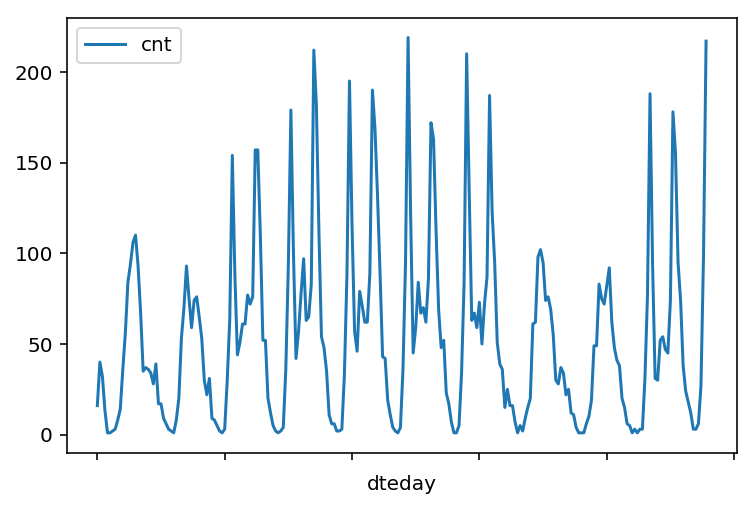

In [86]:
rides[:24*10].plot(x='dteday', y='cnt')

### 虚拟变量（哑变量）

下面是一些分类变量，例如季节、天气、月份。要在我们的模型中包含这些数据，我们需要创建二进制虚拟变量。用 Pandas 库中的 `get_dummies()` 就可以轻松实现。

In [87]:
dummy_fields = ['season', 'weathersit', 'mnth', 'hr', 'weekday']
for each in dummy_fields:
    dummies = pd.get_dummies(rides[each], prefix=each, drop_first=False)
    rides = pd.concat([rides, dummies], axis=1)

fields_to_drop = ['instant', 'dteday', 'season', 'weathersit', 
                  'weekday', 'atemp', 'mnth', 'workingday', 'hr']
data = rides.drop(fields_to_drop, axis=1)
data.head()

,yr,holiday,temp,hum,windspeed,casual,registered,cnt,season_1,season_2,...,hr_21,hr_22,hr_23,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,0,0,0.24,0.81,0.0,3,13,16,1,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0.22,0.80,0.0,8,32,40,1,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0.22,0.80,0.0,5,27,32,1,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0.24,0.75,0.0,3,10,13,1,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0.24,0.75,0.0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,1


### 调整目标变量

为了更轻松地训练网络，我们将对每个连续变量标准化，即转换和调整变量，使它们的均值为 0，标准差为 1。

我们会保存换算因子，以便当我们使用网络进行预测时可以还原数据。

In [88]:
quant_features = ['casual', 'registered', 'cnt', 'temp', 'hum', 'windspeed']
# Store scalings in a dictionary so we can convert back later
scaled_features = {}
for each in quant_features:
    mean, std = data[each].mean(), data[each].std()
    scaled_features[each] = [mean, std]
    data.loc[:, each] = (data[each] - mean)/std

### 将数据拆分为训练、测试和验证数据集

我们将大约最后 21 天的数据保存为测试数据集，这些数据集会在训练完网络后使用。我们将使用该数据集进行预测，并与实际的骑行人数进行对比。

In [89]:
# Save data for approximately the last 21 days 
test_data = data[-21*24:]

# Now remove the test data from the data set 
data = data[:-21*24]

# Separate the data into features and targets
target_fields = ['cnt', 'casual', 'registered']
features, targets = data.drop(target_fields, axis=1), data[target_fields]
test_features, test_targets = test_data.drop(target_fields, axis=1), test_data[target_fields]

我们将数据拆分为两个数据集，一个用作训练，一个在网络训练完后用来验证网络。因为数据是有时间序列特性的，所以我们用历史数据进行训练，然后尝试预测未来数据（验证数据集）。

In [90]:
# Hold out the last 60 days or so of the remaining data as a validation set
train_features, train_targets = features[:-60*24], targets[:-60*24]
val_features, val_targets = features[-60*24:], targets[-60*24:]

## 开始构建网络

下面你将构建自己的网络。我们已经构建好结构和反向传递部分。你将实现网络的前向传递部分。还需要设置超参数：学习速率、隐藏单元的数量，以及训练传递数量。

<img src="C:\Users\carmen wong/A_uda-deep learning/1simple NN/Bike-Sharing-Dataset" width=300px>

该网络有两个层级，一个隐藏层和一个输出层。隐藏层级将使用 S 型函数作为激活函数。输出层只有一个节点，用于递归，节点的输出和节点的输入相同。即激活函数是 $f(x)=x$。这种函数获得输入信号，并生成输出信号，但是会考虑阈值，称为激活函数。我们完成网络的每个层级，并计算每个神经元的输出。一个层级的所有输出变成下一层级神经元的输入。这一流程叫做前向传播（forward propagation）。

我们在神经网络中使用权重将信号从输入层传播到输出层。我们还使用权重将错误从输出层传播回网络，以便更新权重。这叫做反向传播（backpropagation）。

> **提示**：你需要为反向传播实现计算输出激活函数 ($f(x) = x$) 的导数。如果你不熟悉微积分，其实该函数就等同于等式 $y = x$。该等式的斜率是多少？也就是导数 $f(x)$。


你需要完成以下任务：

1. 实现 S 型激活函数。将 `__init__` 中的 `self.activation_function`  设为你的 S 型函数。
2. 在 `train` 方法中实现前向传递。
3. 在 `train` 方法中实现反向传播算法，包括计算输出错误。
4. 在 `run` 方法中实现前向传递。

  

In [91]:
class NeuralNetwork(object):
    def __init__(self, input_nodes, hidden_nodes, output_nodes, learning_rate):
        # Set number of nodes in input, hidden and output layers.
        self.input_nodes = input_nodes
        self.hidden_nodes = hidden_nodes
        self.output_nodes = output_nodes

        # Initialize weights
        self.weights_input_to_hidden = np.random.normal(0.0, self.input_nodes**-0.5, 
                                       (self.input_nodes, self.hidden_nodes))

        self.weights_hidden_to_output = np.random.normal(0.0, self.hidden_nodes**-0.5, 
                                       (self.hidden_nodes, self.output_nodes))
        self.lr = learning_rate
        
        #### TODO: Set self.activation_function to your implemented sigmoid function ####
        #
        # Note: in Python, you can define a function with a lambda expression,
        # as shown below.
        self.activation_function = lambda x : 1/(1+np.exp(-x))  # Replace 0 with your sigmoid calculation.
        
        ### If the lambda code above is not something you're familiar with,
        # You can uncomment out the following three lines and put your 
        # implementation there instead.
        #
        #def sigmoid(x):
        #    return 0  # Replace 0 with your sigmoid calculation here
        #self.activation_function = sigmoid
                    
    
    def train(self, features, targets):
        ''' Train the network on batch of features and targets. 
        
            Arguments
            ---------
            
            features: 2D array, each row is one data record, each column is a feature
            targets: 1D array of target values
        
        '''
        n_records = features.shape[0]
        delta_weights_i_h = np.zeros(self.weights_input_to_hidden.shape)
        delta_weights_h_o = np.zeros(self.weights_hidden_to_output.shape)
        for X, y in zip(features, targets):
            #### Implement the forward pass here ####
            ### Forward pass ###
            # TODO: Hidden layer - Replace these values with your calculations.
            hidden_inputs = np.dot(X,self.weights_input_to_hidden) # signals into hidden layer
            hidden_outputs = self.activation_function(hidden_inputs) # signals from hidden layer

            # TODO: Output layer - Replace these values with your calculations.
            final_inputs =np.dot(hidden_outputs,self.weights_hidden_to_output) # signals into final output layer
            final_outputs =final_inputs  # signals from final output layer
            (1,1)##助教说这里代码一定要写（1,1），因为（1，1）是矩阵，（1，）是向量
            #### Implement the backward pass here ####
            ### Backward pass ###

            # TODO: Output error - Replace this value with your calculations.
            #助教说这里代码一定要写（1,1），因为（1，1）是矩阵，（1，）是向量
            error = y-final_outputs  # Output layer error is the difference between desired target and actual output.
            (1,1)
            # TODO: Calculate the hidden layer's contribution to the error
            hidden_error = np.dot(self.weights_hidden_to_output,error)
            
            # TODO: Backpropagated error terms - Replace these values with your calculations.
            output_error_term = np.array(1)
            hidden_error_term = hidden_outputs*(1-hidden_outputs)

            # Weight step (input to hidden)
            delta_weights_i_h += np.dot(X.reshape((-1,1)),(hidden_error*hidden_error_term).reshape((1,-1)))
            # Weight step (hidden to output)
            delta_weights_h_o += np.dot(hidden_outputs.reshape((-1,1)),(error*output_error_term).reshape((1,-1)))

        # TODO: Update the weights - Replace these values with your calculations.
        self.weights_hidden_to_output += self.lr*delta_weights_h_o/n_records # update hidden-to-output weights with gradient descent step
        self.weights_input_to_hidden += self.lr*delta_weights_i_h/n_records # update input-to-hidden weights with gradient descent step
 
    def run(self, features):
        ''' Run a forward pass through the network with input features 
        
            Arguments
            ---------
            features: 1D array of feature values
        '''
        
        #### Implement the forward pass here ####
        # TODO: Hidden layer - replace these values with the appropriate calculations.
        hidden_inputs = np.dot(features,self.weights_input_to_hidden) # signals into hidden layer
        hidden_outputs = self.activation_function(hidden_inputs) # signals from hidden layer
        
        # TODO: Output layer - Replace these values with the appropriate calculations.
        final_inputs =  np.dot(hidden_outputs,self.weights_hidden_to_output) # signals into final output layer
        final_outputs = final_inputs # signals from final output layer 
        
        return final_outputs

In [92]:
def MSE(y, Y):
    return np.mean((y-Y)**2)

## 单元测试

运行这些单元测试，检查你的网络实现是否正确。这样可以帮助你确保网络已正确实现，然后再开始训练网络。这些测试必须成功才能通过此项目。

In [93]:
import unittest

inputs = np.array([[0.5, -0.2, 0.1]])
targets = np.array([[0.4]])
test_w_i_h = np.array([[0.1, -0.2],
                       [0.4, 0.5],
                       [-0.3, 0.2]])
test_w_h_o = np.array([[0.3],
                       [-0.1]])

class TestMethods(unittest.TestCase):
    
    ##########
    # Unit tests for data loading
    ##########
    
    def test_data_path(self):
        # Test that file path to dataset has been unaltered
        self.assertTrue(data_path.lower() == 'bike-sharing-dataset/hour.csv')
        
    def test_data_loaded(self):
        # Test that data frame loaded
        self.assertTrue(isinstance(rides, pd.DataFrame))
    
    ##########
    # Unit tests for network functionality
    ##########

    def test_activation(self):
        network = NeuralNetwork(3, 2, 1, 0.5)
        # Test that the activation function is a sigmoid
        self.assertTrue(np.all(network.activation_function(0.5) == 1/(1+np.exp(-0.5))))

    def test_train(self):
        # Test that weights are updated correctly on training
        network = NeuralNetwork(3, 2, 1, 0.5)
        network.weights_input_to_hidden = test_w_i_h.copy()
        network.weights_hidden_to_output = test_w_h_o.copy()
        
        network.train(inputs, targets)
        self.assertTrue(np.allclose(network.weights_hidden_to_output, 
                                    np.array([[ 0.37275328], 
                                              [-0.03172939]])))
        self.assertTrue(np.allclose(network.weights_input_to_hidden,
                                    np.array([[ 0.10562014, -0.20185996], 
                                              [0.39775194, 0.50074398], 
                                              [-0.29887597, 0.19962801]])))

    def test_run(self):
        # Test correctness of run method
        network = NeuralNetwork(3, 2, 1, 0.5)
        network.weights_input_to_hidden = test_w_i_h.copy()
        network.weights_hidden_to_output = test_w_h_o.copy()

        self.assertTrue(np.allclose(network.run(inputs), 0.09998924))

suite = unittest.TestLoader().loadTestsFromModule(TestMethods())
unittest.TextTestRunner().run(suite)

.....
----------------------------------------------------------------------
Ran 5 tests in 0.023s

OK


<unittest.runner.TextTestResult run=5 errors=0 failures=0>

## 训练网络

现在你将设置网络的超参数。策略是设置的超参数使训练集上的错误很小但是数据不会过拟合。如果网络训练时间太长，或者有太多的隐藏节点，可能就会过于针对特定训练集，无法泛化到验证数据集。即当训练集的损失降低时，验证集的损失将开始增大。

你还将采用随机梯度下降 (SGD) 方法训练网络。对于每次训练，都获取随机样本数据，而不是整个数据集。与普通梯度下降相比，训练次数要更多，但是每次时间更短。这样的话，网络训练效率更高。稍后你将详细了解 SGD。


### 选择迭代次数

也就是训练网络时从训练数据中抽样的批次数量。迭代次数越多，模型就与数据越拟合。但是，如果迭代次数太多，模型就无法很好地泛化到其他数据，这叫做过拟合。你需要选择一个使训练损失很低并且验证损失保持中等水平的数字。当你开始过拟合时，你会发现训练损失继续下降，但是验证损失开始上升。

### 选择学习速率

速率可以调整权重更新幅度。如果速率太大，权重就会太大，导致网络无法与数据相拟合。建议从 0.1 开始。如果网络在与数据拟合时遇到问题，尝试降低学习速率。注意，学习速率越低，权重更新的步长就越小，神经网络收敛的时间就越长。


### 选择隐藏节点数量

隐藏节点越多，模型的预测结果就越准确。尝试不同的隐藏节点的数量，看看对性能有何影响。你可以查看损失字典，寻找网络性能指标。如果隐藏单元的数量太少，那么模型就没有足够的空间进行学习，如果太多，则学习方向就有太多的选择。选择隐藏单元数量的技巧在于找到合适的平衡点。

In [94]:
import sys

### Set the hyperparameters here ###
iterations = 10000
learning_rate = 0.5
hidden_nodes = 10
output_nodes = 1

N_i = train_features.shape[1]
network = NeuralNetwork(N_i, hidden_nodes, output_nodes, learning_rate)

losses = {'train':[], 'validation':[]}
for ii in range(iterations):
    # Go through a random batch of 128 records from the training data set
    batch = np.random.choice(train_features.index, size=128)
    X, y = train_features.ix[batch].values, train_targets.ix[batch]['cnt']
                             
    network.train(X, y)
    
    # Printing out the training progress
    train_loss = MSE(network.run(train_features).T, train_targets['cnt'].values)
    val_loss = MSE(network.run(val_features).T, val_targets['cnt'].values)
    sys.stdout.write("\rProgress: {:2.1f}".format(100 * ii/float(iterations)) \
                     + "% ... Training loss: " + str(train_loss)[:5] \
                     + " ... Validation loss: " + str(val_loss)[:5])
    sys.stdout.flush()
    
    losses['train'].append(train_loss)
    losses['validation'].append(val_loss)
    #增加
    print("iteration:",ii),print("train_loss:",train_loss),print("val_loss:",val_loss)

Progress: 0.0% ... Training loss: 0.930 ... Validation loss: 1.263iteration: 0
train_loss: 0.9305221939227614
val_loss: 1.263986978316298
Progress: 0.0% ... Training loss: 0.880 ... Validation loss: 1.351iteration: 1
train_loss: 0.8809668450420257
val_loss: 1.351496685670542
Progress: 0.0% ... Training loss: 0.868 ... Validation loss: 1.285iteration: 2
train_loss: 0.8683427249203824
val_loss: 1.285676443299597
Progress: 0.0% ... Training loss: 0.847 ... Validation loss: 1.334

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  app.launch_new_instance()


iteration: 3
train_loss: 0.847914428928384
val_loss: 1.3348236634410293
Progress: 0.0% ... Training loss: 0.838 ... Validation loss: 1.234iteration: 4
train_loss: 0.8386512862865876
val_loss: 1.2347621355903757
Progress: 0.1% ... Training loss: 0.823 ... Validation loss: 1.221iteration: 5
train_loss: 0.8231528181204832
val_loss: 1.2216029541831235
Progress: 0.1% ... Training loss: 0.803 ... Validation loss: 1.367iteration: 6
train_loss: 0.8031305992415131
val_loss: 1.3676512913976695
Progress: 0.1% ... Training loss: 0.807 ... Validation loss: 1.415iteration: 7
train_loss: 0.807158567811122
val_loss: 1.415108523690836
Progress: 0.1% ... Training loss: 0.774 ... Validation loss: 1.247iteration: 8
train_loss: 0.7744470923047433
val_loss: 1.2477923552780135
Progress: 0.1% ... Training loss: 0.786 ... Validation loss: 1.417iteration: 9
train_loss: 0.7862795994391175
val_loss: 1.417817816251733
Progress: 0.1% ... Training loss: 0.746 ... Validation loss: 1.277iteration: 10
train_loss: 0.746

Progress: 0.6% ... Training loss: 0.535 ... Validation loss: 0.914iteration: 62
train_loss: 0.5352045519058685
val_loss: 0.9141746713147312
Progress: 0.6% ... Training loss: 0.540 ... Validation loss: 0.851iteration: 63
train_loss: 0.540015979812777
val_loss: 0.8512426725809717
Progress: 0.6% ... Training loss: 0.531 ... Validation loss: 0.914iteration: 64
train_loss: 0.531712507545926
val_loss: 0.9140415748795745
Progress: 0.7% ... Training loss: 0.526 ... Validation loss: 0.857iteration: 65
train_loss: 0.526008875036568
val_loss: 0.857669800941107
Progress: 0.7% ... Training loss: 0.526 ... Validation loss: 0.907iteration: 66
train_loss: 0.5262840214859571
val_loss: 0.9074879477914728
Progress: 0.7% ... Training loss: 0.528 ... Validation loss: 0.828iteration: 67
train_loss: 0.5288445119060748
val_loss: 0.8288768587004023
Progress: 0.7% ... Training loss: 0.545 ... Validation loss: 0.953iteration: 68
train_loss: 0.5451917412388514
val_loss: 0.953274850980235
Progress: 0.7% ... Traini

Progress: 1.2% ... Training loss: 0.401 ... Validation loss: 0.635iteration: 120
train_loss: 0.4016689697245631
val_loss: 0.6350833145303205
Progress: 1.2% ... Training loss: 0.412 ... Validation loss: 0.658iteration: 121
train_loss: 0.41225794881362926
val_loss: 0.6588210956141082
Progress: 1.2% ... Training loss: 0.382 ... Validation loss: 0.627iteration: 122
train_loss: 0.3827538805073876
val_loss: 0.6272947234505676
Progress: 1.2% ... Training loss: 0.401 ... Validation loss: 0.642iteration: 123
train_loss: 0.4013179548244593
val_loss: 0.6429242059537041
Progress: 1.2% ... Training loss: 0.384 ... Validation loss: 0.627iteration: 124
train_loss: 0.38431959710384117
val_loss: 0.627732381620869
Progress: 1.2% ... Training loss: 0.383 ... Validation loss: 0.623iteration: 125
train_loss: 0.3832182104403969
val_loss: 0.6234556646618052
Progress: 1.3% ... Training loss: 0.378 ... Validation loss: 0.618iteration: 126
train_loss: 0.37856702468937964
val_loss: 0.6182209302862185
Progress: 1

Progress: 1.8% ... Training loss: 0.319 ... Validation loss: 0.515iteration: 178
train_loss: 0.3192075569169959
val_loss: 0.5152390512699582
Progress: 1.8% ... Training loss: 0.328 ... Validation loss: 0.516iteration: 179
train_loss: 0.32810255906625063
val_loss: 0.5161893881824844
Progress: 1.8% ... Training loss: 0.319 ... Validation loss: 0.512iteration: 180
train_loss: 0.31910692762811316
val_loss: 0.5123654606528781
Progress: 1.8% ... Training loss: 0.322 ... Validation loss: 0.498iteration: 181
train_loss: 0.32257108147849284
val_loss: 0.4988774909646089
Progress: 1.8% ... Training loss: 0.323 ... Validation loss: 0.516iteration: 182
train_loss: 0.323159639069863
val_loss: 0.5165809393134357
Progress: 1.8% ... Training loss: 0.339 ... Validation loss: 0.527iteration: 183
train_loss: 0.3398124099960122
val_loss: 0.5278623332841947
Progress: 1.8% ... Training loss: 0.316 ... Validation loss: 0.504iteration: 184
train_loss: 0.31650063522631183
val_loss: 0.5047474536093974
Progress: 

Progress: 2.4% ... Training loss: 0.327 ... Validation loss: 0.507iteration: 236
train_loss: 0.3277871856953315
val_loss: 0.5075486963333445
Progress: 2.4% ... Training loss: 0.335 ... Validation loss: 0.502iteration: 237
train_loss: 0.3354530728104609
val_loss: 0.5021043081794366
Progress: 2.4% ... Training loss: 0.322 ... Validation loss: 0.487iteration: 238
train_loss: 0.3221659332828317
val_loss: 0.48766107020816557
Progress: 2.4% ... Training loss: 0.306 ... Validation loss: 0.475iteration: 239
train_loss: 0.30631601577577067
val_loss: 0.4753968550786928
Progress: 2.4% ... Training loss: 0.304 ... Validation loss: 0.473iteration: 240
train_loss: 0.30410104203310784
val_loss: 0.4735118394760001
Progress: 2.4% ... Training loss: 0.310 ... Validation loss: 0.468iteration: 241
train_loss: 0.3102919179478342
val_loss: 0.46805995684748986
Progress: 2.4% ... Training loss: 0.327 ... Validation loss: 0.500iteration: 242
train_loss: 0.32730411686202443
val_loss: 0.5006872778729984
Progress

Progress: 2.9% ... Training loss: 0.303 ... Validation loss: 0.471iteration: 294
train_loss: 0.30389755186813583
val_loss: 0.47153131513306434
Progress: 3.0% ... Training loss: 0.311 ... Validation loss: 0.481iteration: 295
train_loss: 0.31107972517176363
val_loss: 0.4816782590911059
Progress: 3.0% ... Training loss: 0.356 ... Validation loss: 0.514iteration: 296
train_loss: 0.35677392711633665
val_loss: 0.5143211369883767
Progress: 3.0% ... Training loss: 0.321 ... Validation loss: 0.500iteration: 297
train_loss: 0.321304822823218
val_loss: 0.5005512526312663
Progress: 3.0% ... Training loss: 0.337 ... Validation loss: 0.500iteration: 298
train_loss: 0.3375369134811655
val_loss: 0.5000361753823996
Progress: 3.0% ... Training loss: 0.300 ... Validation loss: 0.477iteration: 299
train_loss: 0.30075503797489855
val_loss: 0.4770700871640638
Progress: 3.0% ... Training loss: 0.316 ... Validation loss: 0.479iteration: 300
train_loss: 0.31609511023835657
val_loss: 0.4792610562550275
Progress

Progress: 3.5% ... Training loss: 0.289 ... Validation loss: 0.452iteration: 352
train_loss: 0.28957992143164757
val_loss: 0.4521624227501328
Progress: 3.5% ... Training loss: 0.305 ... Validation loss: 0.473iteration: 353
train_loss: 0.30529390012505503
val_loss: 0.47308760465848554
Progress: 3.5% ... Training loss: 0.385 ... Validation loss: 0.517iteration: 354
train_loss: 0.3856063678690764
val_loss: 0.5173141051403973
Progress: 3.5% ... Training loss: 0.326 ... Validation loss: 0.520iteration: 355
train_loss: 0.3264874159778399
val_loss: 0.5200138113709794
Progress: 3.6% ... Training loss: 0.303 ... Validation loss: 0.457iteration: 356
train_loss: 0.30303960543234637
val_loss: 0.4575337667250662
Progress: 3.6% ... Training loss: 0.294 ... Validation loss: 0.469iteration: 357
train_loss: 0.2940102677570817
val_loss: 0.4695157265422662
Progress: 3.6% ... Training loss: 0.292 ... Validation loss: 0.457iteration: 358
train_loss: 0.2921555510240358
val_loss: 0.45732537089550873
Progress

Progress: 4.1% ... Training loss: 0.283 ... Validation loss: 0.463iteration: 410
train_loss: 0.28313343693901255
val_loss: 0.4633453643015588
Progress: 4.1% ... Training loss: 0.282 ... Validation loss: 0.458iteration: 411
train_loss: 0.28240752065534436
val_loss: 0.45841042088069944
Progress: 4.1% ... Training loss: 0.288 ... Validation loss: 0.464iteration: 412
train_loss: 0.2886600947508168
val_loss: 0.46477509400987127
Progress: 4.1% ... Training loss: 0.293 ... Validation loss: 0.455iteration: 413
train_loss: 0.2938332501800394
val_loss: 0.4557005755145894
Progress: 4.1% ... Training loss: 0.287 ... Validation loss: 0.451iteration: 414
train_loss: 0.2877095334970807
val_loss: 0.45124332535073663
Progress: 4.2% ... Training loss: 0.288 ... Validation loss: 0.471iteration: 415
train_loss: 0.28810339569182153
val_loss: 0.47143384117530646
Progress: 4.2% ... Training loss: 0.287 ... Validation loss: 0.454iteration: 416
train_loss: 0.28716860645790043
val_loss: 0.4541888851687626
Progr

Progress: 4.7% ... Training loss: 0.279 ... Validation loss: 0.459iteration: 468
train_loss: 0.27929241748726996
val_loss: 0.45907521001797197
Progress: 4.7% ... Training loss: 0.276 ... Validation loss: 0.461iteration: 469
train_loss: 0.27649384881256484
val_loss: 0.4614968436802515
Progress: 4.7% ... Training loss: 0.275 ... Validation loss: 0.449iteration: 470
train_loss: 0.27577583648312387
val_loss: 0.449881869153747
Progress: 4.7% ... Training loss: 0.275 ... Validation loss: 0.452iteration: 471
train_loss: 0.2755543393116397
val_loss: 0.45230069356039987
Progress: 4.7% ... Training loss: 0.281 ... Validation loss: 0.450iteration: 472
train_loss: 0.28152967679951846
val_loss: 0.4507925840416572
Progress: 4.7% ... Training loss: 0.282 ... Validation loss: 0.456iteration: 473
train_loss: 0.28293427164414237
val_loss: 0.45664268179688994
Progress: 4.7% ... Training loss: 0.279 ... Validation loss: 0.454iteration: 474
train_loss: 0.27928303739867
val_loss: 0.45457036800671385
Progres

Progress: 5.3% ... Training loss: 0.276 ... Validation loss: 0.458iteration: 526
train_loss: 0.27680982169700435
val_loss: 0.45854789522622763
Progress: 5.3% ... Training loss: 0.275 ... Validation loss: 0.459iteration: 527
train_loss: 0.2753684957111453
val_loss: 0.45933077614467854
Progress: 5.3% ... Training loss: 0.269 ... Validation loss: 0.446iteration: 528
train_loss: 0.2691396943525338
val_loss: 0.4467572076600471
Progress: 5.3% ... Training loss: 0.270 ... Validation loss: 0.444iteration: 529
train_loss: 0.27056633494931387
val_loss: 0.44487334703043324
Progress: 5.3% ... Training loss: 0.270 ... Validation loss: 0.446iteration: 530
train_loss: 0.270641028105806
val_loss: 0.44694644669835715
Progress: 5.3% ... Training loss: 0.268 ... Validation loss: 0.446iteration: 531
train_loss: 0.26876421362194625
val_loss: 0.4465355145869866
Progress: 5.3% ... Training loss: 0.276 ... Validation loss: 0.464iteration: 532
train_loss: 0.2769078474285469
val_loss: 0.46481027605716413
Progre

Progress: 5.8% ... Training loss: 0.269 ... Validation loss: 0.458iteration: 584
train_loss: 0.26955082275146963
val_loss: 0.4584828425313066
Progress: 5.8% ... Training loss: 0.289 ... Validation loss: 0.463iteration: 585
train_loss: 0.28933347027721806
val_loss: 0.46323956907197406
Progress: 5.9% ... Training loss: 0.271 ... Validation loss: 0.456iteration: 586
train_loss: 0.27112911141494844
val_loss: 0.45678483180829993
Progress: 5.9% ... Training loss: 0.275 ... Validation loss: 0.451iteration: 587
train_loss: 0.2753944358574998
val_loss: 0.4512828661182141
Progress: 5.9% ... Training loss: 0.275 ... Validation loss: 0.461iteration: 588
train_loss: 0.27513354399057827
val_loss: 0.4611586071037824
Progress: 5.9% ... Training loss: 0.279 ... Validation loss: 0.453iteration: 589
train_loss: 0.2792063360461917
val_loss: 0.45366771846905835
Progress: 5.9% ... Training loss: 0.287 ... Validation loss: 0.491iteration: 590
train_loss: 0.2876753509494626
val_loss: 0.49110275586374963
Progr

Progress: 6.4% ... Training loss: 0.265 ... Validation loss: 0.450iteration: 642
train_loss: 0.26583499740266003
val_loss: 0.4503913375686788
Progress: 6.4% ... Training loss: 0.265 ... Validation loss: 0.454iteration: 643
train_loss: 0.26501043695184945
val_loss: 0.45402511141452917
Progress: 6.4% ... Training loss: 0.281 ... Validation loss: 0.454iteration: 644
train_loss: 0.2817258472220909
val_loss: 0.4547704829988499
Progress: 6.5% ... Training loss: 0.264 ... Validation loss: 0.452iteration: 645
train_loss: 0.2642212154123989
val_loss: 0.4528870857617581
Progress: 6.5% ... Training loss: 0.267 ... Validation loss: 0.449iteration: 646
train_loss: 0.2672700938475119
val_loss: 0.4494912696929664
Progress: 6.5% ... Training loss: 0.264 ... Validation loss: 0.451iteration: 647
train_loss: 0.26433116280140845
val_loss: 0.4511871598638354
Progress: 6.5% ... Training loss: 0.272 ... Validation loss: 0.464iteration: 648
train_loss: 0.2729889691141816
val_loss: 0.46482316310088084
Progress

Progress: 7.0% ... Training loss: 0.267 ... Validation loss: 0.460iteration: 700
train_loss: 0.26712133028643725
val_loss: 0.4606949233846415
Progress: 7.0% ... Training loss: 0.269 ... Validation loss: 0.463iteration: 701
train_loss: 0.269538290439212
val_loss: 0.4635521975815514
Progress: 7.0% ... Training loss: 0.276 ... Validation loss: 0.469iteration: 702
train_loss: 0.27676828332587916
val_loss: 0.46985864012578055
Progress: 7.0% ... Training loss: 0.264 ... Validation loss: 0.454iteration: 703
train_loss: 0.2641404426250103
val_loss: 0.4542281159299583
Progress: 7.0% ... Training loss: 0.275 ... Validation loss: 0.466iteration: 704
train_loss: 0.2757998911125097
val_loss: 0.46627274096395227
Progress: 7.0% ... Training loss: 0.301 ... Validation loss: 0.477iteration: 705
train_loss: 0.3019249239155794
val_loss: 0.4773078310151434
Progress: 7.1% ... Training loss: 0.268 ... Validation loss: 0.455iteration: 706
train_loss: 0.26850339594453604
val_loss: 0.4550762228800243
Progress:

Progress: 7.6% ... Training loss: 0.259 ... Validation loss: 0.441iteration: 758
train_loss: 0.25951967986484886
val_loss: 0.44130232328232194
Progress: 7.6% ... Training loss: 0.263 ... Validation loss: 0.444iteration: 759
train_loss: 0.2632722946647635
val_loss: 0.444961278212166
Progress: 7.6% ... Training loss: 0.276 ... Validation loss: 0.455iteration: 760
train_loss: 0.27607907306102497
val_loss: 0.45581567070404155
Progress: 7.6% ... Training loss: 0.262 ... Validation loss: 0.443iteration: 761
train_loss: 0.26279670425016805
val_loss: 0.4438608906988435
Progress: 7.6% ... Training loss: 0.266 ... Validation loss: 0.457iteration: 762
train_loss: 0.2660309820372125
val_loss: 0.4575332330795313
Progress: 7.6% ... Training loss: 0.268 ... Validation loss: 0.454iteration: 763
train_loss: 0.2686951911810942
val_loss: 0.45451650512291764
Progress: 7.6% ... Training loss: 0.259 ... Validation loss: 0.443iteration: 764
train_loss: 0.25928600294629
val_loss: 0.44306660748268506
Progress:

Progress: 8.2% ... Training loss: 0.260 ... Validation loss: 0.431iteration: 816
train_loss: 0.2600876708073371
val_loss: 0.43127918735647497
Progress: 8.2% ... Training loss: 0.265 ... Validation loss: 0.443iteration: 817
train_loss: 0.2654268941150273
val_loss: 0.443895404650548
Progress: 8.2% ... Training loss: 0.276 ... Validation loss: 0.444iteration: 818
train_loss: 0.27695825695921256
val_loss: 0.44456538824513536
Progress: 8.2% ... Training loss: 0.257 ... Validation loss: 0.433iteration: 819
train_loss: 0.2575261008949498
val_loss: 0.4339630582402745
Progress: 8.2% ... Training loss: 0.262 ... Validation loss: 0.455iteration: 820
train_loss: 0.26221298713733643
val_loss: 0.45540818234662395
Progress: 8.2% ... Training loss: 0.261 ... Validation loss: 0.445iteration: 821
train_loss: 0.2613918703776736
val_loss: 0.4456568936088503
Progress: 8.2% ... Training loss: 0.259 ... Validation loss: 0.437iteration: 822
train_loss: 0.2594257720957763
val_loss: 0.43768770584661226
Progress

Progress: 8.7% ... Training loss: 0.257 ... Validation loss: 0.451iteration: 874
train_loss: 0.2575347617320374
val_loss: 0.4518757222464098
Progress: 8.8% ... Training loss: 0.257 ... Validation loss: 0.452iteration: 875
train_loss: 0.2573351775716062
val_loss: 0.45250754526278963
Progress: 8.8% ... Training loss: 0.257 ... Validation loss: 0.454iteration: 876
train_loss: 0.2571783881086556
val_loss: 0.45433176099341394
Progress: 8.8% ... Training loss: 0.277 ... Validation loss: 0.464iteration: 877
train_loss: 0.27746659136175406
val_loss: 0.4646049274402929
Progress: 8.8% ... Training loss: 0.270 ... Validation loss: 0.463iteration: 878
train_loss: 0.2704390659136243
val_loss: 0.4638106297329718
Progress: 8.8% ... Training loss: 0.260 ... Validation loss: 0.457iteration: 879
train_loss: 0.2604288599882194
val_loss: 0.45720830029047743
Progress: 8.8% ... Training loss: 0.273 ... Validation loss: 0.467iteration: 880
train_loss: 0.27336893217368424
val_loss: 0.4678333017235632
Progress

Progress: 9.3% ... Training loss: 0.257 ... Validation loss: 0.451iteration: 932
train_loss: 0.2571854897370629
val_loss: 0.45147330508793604
Progress: 9.3% ... Training loss: 0.259 ... Validation loss: 0.442iteration: 933
train_loss: 0.25906239447880086
val_loss: 0.44213755778944314
Progress: 9.3% ... Training loss: 0.256 ... Validation loss: 0.437iteration: 934
train_loss: 0.2563725076851228
val_loss: 0.43754174695930126
Progress: 9.3% ... Training loss: 0.257 ... Validation loss: 0.436iteration: 935
train_loss: 0.25786979765285933
val_loss: 0.4366336099364103
Progress: 9.4% ... Training loss: 0.267 ... Validation loss: 0.462iteration: 936
train_loss: 0.2670487428512591
val_loss: 0.4623819318829173
Progress: 9.4% ... Training loss: 0.256 ... Validation loss: 0.446iteration: 937
train_loss: 0.2563645260101751
val_loss: 0.4461912771185252
Progress: 9.4% ... Training loss: 0.256 ... Validation loss: 0.437iteration: 938
train_loss: 0.2560766863679972
val_loss: 0.4377541632684742
Progress

Progress: 9.9% ... Training loss: 0.259 ... Validation loss: 0.450iteration: 990
train_loss: 0.2597286345597087
val_loss: 0.4504771869145956
Progress: 9.9% ... Training loss: 0.259 ... Validation loss: 0.452iteration: 991
train_loss: 0.25946863448078245
val_loss: 0.452498030353938
Progress: 9.9% ... Training loss: 0.267 ... Validation loss: 0.450iteration: 992
train_loss: 0.2674025539913747
val_loss: 0.450367638496158
Progress: 9.9% ... Training loss: 0.255 ... Validation loss: 0.446iteration: 993
train_loss: 0.2558091878126293
val_loss: 0.44688271569937804
Progress: 9.9% ... Training loss: 0.258 ... Validation loss: 0.455iteration: 994
train_loss: 0.25823529096220205
val_loss: 0.45526811805949685
Progress: 9.9% ... Training loss: 0.252 ... Validation loss: 0.454iteration: 995
train_loss: 0.25283302344170333
val_loss: 0.4549842832344645
Progress: 10.0% ... Training loss: 0.253 ... Validation loss: 0.453iteration: 996
train_loss: 0.2530833214888711
val_loss: 0.45323083427364835
Progress

Progress: 10.5% ... Training loss: 0.252 ... Validation loss: 0.440iteration: 1047
train_loss: 0.2524516101262584
val_loss: 0.4405584682848236
Progress: 10.5% ... Training loss: 0.252 ... Validation loss: 0.437iteration: 1048
train_loss: 0.2525512306705887
val_loss: 0.4379496131080279
Progress: 10.5% ... Training loss: 0.253 ... Validation loss: 0.444iteration: 1049
train_loss: 0.2535743918950314
val_loss: 0.4443662675452786
Progress: 10.5% ... Training loss: 0.260 ... Validation loss: 0.435iteration: 1050
train_loss: 0.26032455543362626
val_loss: 0.43537276006994763
Progress: 10.5% ... Training loss: 0.263 ... Validation loss: 0.462iteration: 1051
train_loss: 0.2631603988310139
val_loss: 0.4623391716525725
Progress: 10.5% ... Training loss: 0.252 ... Validation loss: 0.437iteration: 1052
train_loss: 0.2523598199800397
val_loss: 0.4372955179558086
Progress: 10.5% ... Training loss: 0.252 ... Validation loss: 0.434iteration: 1053
train_loss: 0.2529436073903767
val_loss: 0.43404840360292

Progress: 11.0% ... Training loss: 0.251 ... Validation loss: 0.446iteration: 1104
train_loss: 0.25116310380238777
val_loss: 0.4468742802141063
Progress: 11.1% ... Training loss: 0.250 ... Validation loss: 0.440iteration: 1105
train_loss: 0.25071808297697395
val_loss: 0.4401357048307188
Progress: 11.1% ... Training loss: 0.247 ... Validation loss: 0.437iteration: 1106
train_loss: 0.2477211178111947
val_loss: 0.43745802544304085
Progress: 11.1% ... Training loss: 0.249 ... Validation loss: 0.435iteration: 1107
train_loss: 0.24919514087133146
val_loss: 0.43558305196125374
Progress: 11.1% ... Training loss: 0.256 ... Validation loss: 0.442iteration: 1108
train_loss: 0.25611481996451796
val_loss: 0.44215154278494234
Progress: 11.1% ... Training loss: 0.291 ... Validation loss: 0.463iteration: 1109
train_loss: 0.29135100334031805
val_loss: 0.4633072936636668
Progress: 11.1% ... Training loss: 0.256 ... Validation loss: 0.449iteration: 1110
train_loss: 0.256710497044176
val_loss: 0.449658595

Progress: 11.6% ... Training loss: 0.246 ... Validation loss: 0.433iteration: 1161
train_loss: 0.24695849590500837
val_loss: 0.4334350338798455
Progress: 11.6% ... Training loss: 0.246 ... Validation loss: 0.437iteration: 1162
train_loss: 0.24666681520509662
val_loss: 0.4379909588799714
Progress: 11.6% ... Training loss: 0.247 ... Validation loss: 0.435iteration: 1163
train_loss: 0.24791731747950635
val_loss: 0.4355560760586993
Progress: 11.6% ... Training loss: 0.244 ... Validation loss: 0.429iteration: 1164
train_loss: 0.24487044442964423
val_loss: 0.4295321322570419
Progress: 11.7% ... Training loss: 0.250 ... Validation loss: 0.428iteration: 1165
train_loss: 0.2500431889063178
val_loss: 0.4283147323414909
Progress: 11.7% ... Training loss: 0.269 ... Validation loss: 0.428iteration: 1166
train_loss: 0.2695921455150998
val_loss: 0.42818142653369345
Progress: 11.7% ... Training loss: 0.254 ... Validation loss: 0.422iteration: 1167
train_loss: 0.25444040739323454
val_loss: 0.4229741469

Progress: 12.2% ... Training loss: 0.247 ... Validation loss: 0.451iteration: 1218
train_loss: 0.24756727657507255
val_loss: 0.45106695313834144
Progress: 12.2% ... Training loss: 0.249 ... Validation loss: 0.449iteration: 1219
train_loss: 0.24975454781307455
val_loss: 0.4499746498742511
Progress: 12.2% ... Training loss: 0.241 ... Validation loss: 0.435iteration: 1220
train_loss: 0.24143024293431126
val_loss: 0.43556645058419546
Progress: 12.2% ... Training loss: 0.241 ... Validation loss: 0.431iteration: 1221
train_loss: 0.24154791293095482
val_loss: 0.431511178571644
Progress: 12.2% ... Training loss: 0.241 ... Validation loss: 0.430iteration: 1222
train_loss: 0.24153175424166362
val_loss: 0.43009002613457487
Progress: 12.2% ... Training loss: 0.241 ... Validation loss: 0.427iteration: 1223
train_loss: 0.24159702092860585
val_loss: 0.4273563658361926
Progress: 12.2% ... Training loss: 0.240 ... Validation loss: 0.427iteration: 1224
train_loss: 0.24087705678719482
val_loss: 0.4274576

Progress: 12.8% ... Training loss: 0.240 ... Validation loss: 0.435iteration: 1275
train_loss: 0.24028613395707238
val_loss: 0.43508850392240767
Progress: 12.8% ... Training loss: 0.251 ... Validation loss: 0.446iteration: 1276
train_loss: 0.2511922669916092
val_loss: 0.44696323876073835
Progress: 12.8% ... Training loss: 0.243 ... Validation loss: 0.445iteration: 1277
train_loss: 0.2434200815567963
val_loss: 0.44549328438156616
Progress: 12.8% ... Training loss: 0.241 ... Validation loss: 0.437iteration: 1278
train_loss: 0.24196840973191291
val_loss: 0.43715810012592227
Progress: 12.8% ... Training loss: 0.238 ... Validation loss: 0.431iteration: 1279
train_loss: 0.23832741514710598
val_loss: 0.4318609726259496
Progress: 12.8% ... Training loss: 0.237 ... Validation loss: 0.430iteration: 1280
train_loss: 0.23783842955105
val_loss: 0.4302964878296025
Progress: 12.8% ... Training loss: 0.244 ... Validation loss: 0.443iteration: 1281
train_loss: 0.24463140792348168
val_loss: 0.4439757231

Progress: 13.3% ... Training loss: 0.236 ... Validation loss: 0.424iteration: 1332
train_loss: 0.23662808845833677
val_loss: 0.42461691926764805
Progress: 13.3% ... Training loss: 0.235 ... Validation loss: 0.423iteration: 1333
train_loss: 0.23533120696526855
val_loss: 0.42301884558495984
Progress: 13.3% ... Training loss: 0.234 ... Validation loss: 0.422iteration: 1334
train_loss: 0.23428881638077792
val_loss: 0.4223213285654927
Progress: 13.3% ... Training loss: 0.242 ... Validation loss: 0.425iteration: 1335
train_loss: 0.2422246718940994
val_loss: 0.4253505188847579
Progress: 13.4% ... Training loss: 0.236 ... Validation loss: 0.424iteration: 1336
train_loss: 0.23612868673789633
val_loss: 0.42471046056082107
Progress: 13.4% ... Training loss: 0.238 ... Validation loss: 0.431iteration: 1337
train_loss: 0.23834863039810092
val_loss: 0.43175658718170035
Progress: 13.4% ... Training loss: 0.234 ... Validation loss: 0.419iteration: 1338
train_loss: 0.2346507915088417
val_loss: 0.4194735

Progress: 13.9% ... Training loss: 0.228 ... Validation loss: 0.414iteration: 1389
train_loss: 0.22880357676589697
val_loss: 0.4144244111864905
Progress: 13.9% ... Training loss: 0.228 ... Validation loss: 0.413iteration: 1390
train_loss: 0.2289832725475713
val_loss: 0.4139765873643122
Progress: 13.9% ... Training loss: 0.228 ... Validation loss: 0.416iteration: 1391
train_loss: 0.22893298566539352
val_loss: 0.41642726492062165
Progress: 13.9% ... Training loss: 0.229 ... Validation loss: 0.420iteration: 1392
train_loss: 0.2290648335857497
val_loss: 0.4201317255425938
Progress: 13.9% ... Training loss: 0.228 ... Validation loss: 0.416iteration: 1393
train_loss: 0.22842654901761317
val_loss: 0.4165465926012924
Progress: 13.9% ... Training loss: 0.236 ... Validation loss: 0.423iteration: 1394
train_loss: 0.23638912253954952
val_loss: 0.4234061544663907
Progress: 13.9% ... Training loss: 0.229 ... Validation loss: 0.418iteration: 1395
train_loss: 0.22921188978234303
val_loss: 0.4182493628

Progress: 14.5% ... Training loss: 0.225 ... Validation loss: 0.412iteration: 1446
train_loss: 0.22545652535227081
val_loss: 0.41270954485636097
Progress: 14.5% ... Training loss: 0.225 ... Validation loss: 0.409iteration: 1447
train_loss: 0.22554478227791563
val_loss: 0.4098872041692679
Progress: 14.5% ... Training loss: 0.229 ... Validation loss: 0.425iteration: 1448
train_loss: 0.22915570803808896
val_loss: 0.42565484686103516
Progress: 14.5% ... Training loss: 0.228 ... Validation loss: 0.408iteration: 1449
train_loss: 0.22830033737128433
val_loss: 0.40852135876842205
Progress: 14.5% ... Training loss: 0.240 ... Validation loss: 0.446iteration: 1450
train_loss: 0.24028652181051538
val_loss: 0.4461045468801808
Progress: 14.5% ... Training loss: 0.241 ... Validation loss: 0.408iteration: 1451
train_loss: 0.24149205899260615
val_loss: 0.4089417259738941
Progress: 14.5% ... Training loss: 0.229 ... Validation loss: 0.429iteration: 1452
train_loss: 0.229093287946945
val_loss: 0.42942378

Progress: 15.0% ... Training loss: 0.221 ... Validation loss: 0.407iteration: 1503
train_loss: 0.22160412530211868
val_loss: 0.4073263070758364
Progress: 15.0% ... Training loss: 0.219 ... Validation loss: 0.400iteration: 1504
train_loss: 0.21947862450534808
val_loss: 0.40009192723469394
Progress: 15.1% ... Training loss: 0.223 ... Validation loss: 0.402iteration: 1505
train_loss: 0.2233743998444528
val_loss: 0.402128441114676
Progress: 15.1% ... Training loss: 0.226 ... Validation loss: 0.415iteration: 1506
train_loss: 0.22608758483772673
val_loss: 0.4156092294808642
Progress: 15.1% ... Training loss: 0.218 ... Validation loss: 0.405iteration: 1507
train_loss: 0.21817528007976852
val_loss: 0.40553556745888775
Progress: 15.1% ... Training loss: 0.238 ... Validation loss: 0.423iteration: 1508
train_loss: 0.2389036741179387
val_loss: 0.42306293891125246
Progress: 15.1% ... Training loss: 0.227 ... Validation loss: 0.414iteration: 1509
train_loss: 0.2277148439352758
val_loss: 0.4144776007

Progress: 15.6% ... Training loss: 0.212 ... Validation loss: 0.400iteration: 1560
train_loss: 0.21291917824942544
val_loss: 0.4001617459442288
Progress: 15.6% ... Training loss: 0.212 ... Validation loss: 0.402iteration: 1561
train_loss: 0.21238391167075626
val_loss: 0.4021118336447079
Progress: 15.6% ... Training loss: 0.212 ... Validation loss: 0.398iteration: 1562
train_loss: 0.21208203381435584
val_loss: 0.39850333807800364
Progress: 15.6% ... Training loss: 0.212 ... Validation loss: 0.400iteration: 1563
train_loss: 0.21276271622402004
val_loss: 0.40083688845492355
Progress: 15.6% ... Training loss: 0.218 ... Validation loss: 0.411iteration: 1564
train_loss: 0.21872371757212553
val_loss: 0.4117750297334474
Progress: 15.7% ... Training loss: 0.212 ... Validation loss: 0.392iteration: 1565
train_loss: 0.21274878370442832
val_loss: 0.3920672052719676
Progress: 15.7% ... Training loss: 0.215 ... Validation loss: 0.401iteration: 1566
train_loss: 0.21554935119942026
val_loss: 0.4019020

Progress: 16.2% ... Training loss: 0.220 ... Validation loss: 0.414iteration: 1617
train_loss: 0.22060986643805247
val_loss: 0.41481142926296594
Progress: 16.2% ... Training loss: 0.206 ... Validation loss: 0.380iteration: 1618
train_loss: 0.2068472035615224
val_loss: 0.38069860638237857
Progress: 16.2% ... Training loss: 0.206 ... Validation loss: 0.380iteration: 1619
train_loss: 0.20690856962786802
val_loss: 0.3801608563253048
Progress: 16.2% ... Training loss: 0.240 ... Validation loss: 0.443iteration: 1620
train_loss: 0.24045637508562215
val_loss: 0.4431750180157255
Progress: 16.2% ... Training loss: 0.207 ... Validation loss: 0.376iteration: 1621
train_loss: 0.20735415981272834
val_loss: 0.3768417580212099
Progress: 16.2% ... Training loss: 0.207 ... Validation loss: 0.382iteration: 1622
train_loss: 0.2075993962031747
val_loss: 0.3820942223037872
Progress: 16.2% ... Training loss: 0.205 ... Validation loss: 0.378iteration: 1623
train_loss: 0.20582759020770247
val_loss: 0.378044381

Progress: 16.7% ... Training loss: 0.203 ... Validation loss: 0.375iteration: 1674
train_loss: 0.20357009400888124
val_loss: 0.37541314053956404
Progress: 16.8% ... Training loss: 0.208 ... Validation loss: 0.375iteration: 1675
train_loss: 0.20838697144246227
val_loss: 0.3754013719610447
Progress: 16.8% ... Training loss: 0.205 ... Validation loss: 0.409iteration: 1676
train_loss: 0.2054038250740902
val_loss: 0.4096737455609246
Progress: 16.8% ... Training loss: 0.202 ... Validation loss: 0.377iteration: 1677
train_loss: 0.20251444756332374
val_loss: 0.37723549436386256
Progress: 16.8% ... Training loss: 0.202 ... Validation loss: 0.377iteration: 1678
train_loss: 0.20267064251428157
val_loss: 0.3771572184656153
Progress: 16.8% ... Training loss: 0.198 ... Validation loss: 0.378iteration: 1679
train_loss: 0.19898816099359773
val_loss: 0.3787447496580316
Progress: 16.8% ... Training loss: 0.203 ... Validation loss: 0.388iteration: 1680
train_loss: 0.20304840665201665
val_loss: 0.38850175

Progress: 17.3% ... Training loss: 0.193 ... Validation loss: 0.369iteration: 1731
train_loss: 0.1932663608908522
val_loss: 0.36942698376092464
Progress: 17.3% ... Training loss: 0.194 ... Validation loss: 0.364iteration: 1732
train_loss: 0.19416671506648195
val_loss: 0.36416193538928315
Progress: 17.3% ... Training loss: 0.196 ... Validation loss: 0.363iteration: 1733
train_loss: 0.1965426867922636
val_loss: 0.36347723911487856
Progress: 17.3% ... Training loss: 0.194 ... Validation loss: 0.365iteration: 1734
train_loss: 0.19404921613406992
val_loss: 0.36515268658464556
Progress: 17.4% ... Training loss: 0.193 ... Validation loss: 0.363iteration: 1735
train_loss: 0.19384621343646524
val_loss: 0.36302937636335886
Progress: 17.4% ... Training loss: 0.199 ... Validation loss: 0.381iteration: 1736
train_loss: 0.1992190470871822
val_loss: 0.38161047336466225
Progress: 17.4% ... Training loss: 0.202 ... Validation loss: 0.375iteration: 1737
train_loss: 0.2026802252924643
val_loss: 0.3757459

Progress: 17.9% ... Training loss: 0.190 ... Validation loss: 0.351iteration: 1788
train_loss: 0.1903275348514495
val_loss: 0.3510103038040899
Progress: 17.9% ... Training loss: 0.188 ... Validation loss: 0.351iteration: 1789
train_loss: 0.18859071128216529
val_loss: 0.3518110980043393
Progress: 17.9% ... Training loss: 0.188 ... Validation loss: 0.346iteration: 1790
train_loss: 0.188967979698572
val_loss: 0.34630910967405315
Progress: 17.9% ... Training loss: 0.187 ... Validation loss: 0.364iteration: 1791
train_loss: 0.18794538811556635
val_loss: 0.3645817886852087
Progress: 17.9% ... Training loss: 0.189 ... Validation loss: 0.355iteration: 1792
train_loss: 0.18947836533735943
val_loss: 0.35510904473894916
Progress: 17.9% ... Training loss: 0.192 ... Validation loss: 0.377iteration: 1793
train_loss: 0.19238833721740278
val_loss: 0.3776525707475751
Progress: 17.9% ... Training loss: 0.194 ... Validation loss: 0.353iteration: 1794
train_loss: 0.19453942371505997
val_loss: 0.3531922443

Progress: 18.4% ... Training loss: 0.181 ... Validation loss: 0.353iteration: 1845
train_loss: 0.18177747751455417
val_loss: 0.3533867042814272
Progress: 18.5% ... Training loss: 0.181 ... Validation loss: 0.347iteration: 1846
train_loss: 0.18135554358395245
val_loss: 0.34757087895215344
Progress: 18.5% ... Training loss: 0.182 ... Validation loss: 0.348iteration: 1847
train_loss: 0.18264678686434682
val_loss: 0.3483567425121854
Progress: 18.5% ... Training loss: 0.192 ... Validation loss: 0.359iteration: 1848
train_loss: 0.19258858638516516
val_loss: 0.3599904411287476
Progress: 18.5% ... Training loss: 0.192 ... Validation loss: 0.339iteration: 1849
train_loss: 0.1928547743321635
val_loss: 0.3399376981809925
Progress: 18.5% ... Training loss: 0.182 ... Validation loss: 0.345iteration: 1850
train_loss: 0.18204598913412068
val_loss: 0.3457815321844189
Progress: 18.5% ... Training loss: 0.182 ... Validation loss: 0.335iteration: 1851
train_loss: 0.1823498944717483
val_loss: 0.3352728479

Progress: 19.0% ... Training loss: 0.181 ... Validation loss: 0.340iteration: 1902
train_loss: 0.18103426571463532
val_loss: 0.3408034469871493
Progress: 19.0% ... Training loss: 0.186 ... Validation loss: 0.338iteration: 1903
train_loss: 0.18696953739597433
val_loss: 0.33836853247236365
Progress: 19.0% ... Training loss: 0.178 ... Validation loss: 0.335iteration: 1904
train_loss: 0.17876925503428287
val_loss: 0.3352087434123027
Progress: 19.1% ... Training loss: 0.177 ... Validation loss: 0.332iteration: 1905
train_loss: 0.1772700141127901
val_loss: 0.3327091684935823
Progress: 19.1% ... Training loss: 0.176 ... Validation loss: 0.332iteration: 1906
train_loss: 0.17639364718586545
val_loss: 0.3321838904816737
Progress: 19.1% ... Training loss: 0.177 ... Validation loss: 0.333iteration: 1907
train_loss: 0.17783546546585252
val_loss: 0.3336574787843636
Progress: 19.1% ... Training loss: 0.175 ... Validation loss: 0.326iteration: 1908
train_loss: 0.17558260700308173
val_loss: 0.326599623

Progress: 19.6% ... Training loss: 0.171 ... Validation loss: 0.325iteration: 1959
train_loss: 0.17173465264138021
val_loss: 0.3251987340683827
Progress: 19.6% ... Training loss: 0.172 ... Validation loss: 0.323iteration: 1960
train_loss: 0.17292860238395508
val_loss: 0.3230090895276909
Progress: 19.6% ... Training loss: 0.172 ... Validation loss: 0.311iteration: 1961
train_loss: 0.17246029170160646
val_loss: 0.3117980419279951
Progress: 19.6% ... Training loss: 0.170 ... Validation loss: 0.322iteration: 1962
train_loss: 0.17055770933982772
val_loss: 0.3221154926093111
Progress: 19.6% ... Training loss: 0.171 ... Validation loss: 0.316iteration: 1963
train_loss: 0.17181343957817588
val_loss: 0.3167152024535759
Progress: 19.6% ... Training loss: 0.169 ... Validation loss: 0.310iteration: 1964
train_loss: 0.16946260906577126
val_loss: 0.3108648642368825
Progress: 19.6% ... Training loss: 0.171 ... Validation loss: 0.314iteration: 1965
train_loss: 0.17162500771752137
val_loss: 0.314897916

Progress: 20.2% ... Training loss: 0.166 ... Validation loss: 0.316iteration: 2016
train_loss: 0.16696452353265606
val_loss: 0.3161125706704283
Progress: 20.2% ... Training loss: 0.167 ... Validation loss: 0.315iteration: 2017
train_loss: 0.1674204230687514
val_loss: 0.31590000768618587
Progress: 20.2% ... Training loss: 0.179 ... Validation loss: 0.311iteration: 2018
train_loss: 0.17916035588952445
val_loss: 0.31117672616934167
Progress: 20.2% ... Training loss: 0.175 ... Validation loss: 0.352iteration: 2019
train_loss: 0.17574200633099743
val_loss: 0.3524093399689606
Progress: 20.2% ... Training loss: 0.167 ... Validation loss: 0.314iteration: 2020
train_loss: 0.16722312147530508
val_loss: 0.31460388281533114
Progress: 20.2% ... Training loss: 0.165 ... Validation loss: 0.310iteration: 2021
train_loss: 0.16503709492849034
val_loss: 0.31000649905716277
Progress: 20.2% ... Training loss: 0.164 ... Validation loss: 0.319iteration: 2022
train_loss: 0.1647941190782188
val_loss: 0.3192992

Progress: 20.7% ... Training loss: 0.164 ... Validation loss: 0.301iteration: 2073
train_loss: 0.16439543522054392
val_loss: 0.30100863647352966
Progress: 20.7% ... Training loss: 0.160 ... Validation loss: 0.297iteration: 2074
train_loss: 0.1602083869821433
val_loss: 0.29765048812269396
Progress: 20.8% ... Training loss: 0.159 ... Validation loss: 0.308iteration: 2075
train_loss: 0.15986446421662207
val_loss: 0.30880800267649405
Progress: 20.8% ... Training loss: 0.160 ... Validation loss: 0.317iteration: 2076
train_loss: 0.16071705428573171
val_loss: 0.3170710128892915
Progress: 20.8% ... Training loss: 0.160 ... Validation loss: 0.310iteration: 2077
train_loss: 0.160439952005997
val_loss: 0.3105514893208001
Progress: 20.8% ... Training loss: 0.159 ... Validation loss: 0.300iteration: 2078
train_loss: 0.15947097630002152
val_loss: 0.30089875055993975
Progress: 20.8% ... Training loss: 0.159 ... Validation loss: 0.301iteration: 2079
train_loss: 0.1590334492243808
val_loss: 0.301136235

Progress: 21.3% ... Training loss: 0.159 ... Validation loss: 0.290iteration: 2130
train_loss: 0.1596553222230748
val_loss: 0.2907019046382257
Progress: 21.3% ... Training loss: 0.159 ... Validation loss: 0.317iteration: 2131
train_loss: 0.1596748290881091
val_loss: 0.3171183196716576
Progress: 21.3% ... Training loss: 0.155 ... Validation loss: 0.290iteration: 2132
train_loss: 0.15528363664042757
val_loss: 0.29068408277850843
Progress: 21.3% ... Training loss: 0.154 ... Validation loss: 0.302iteration: 2133
train_loss: 0.15431744959676572
val_loss: 0.30229639818851456
Progress: 21.3% ... Training loss: 0.154 ... Validation loss: 0.298iteration: 2134
train_loss: 0.15468657536688088
val_loss: 0.29877395671610424
Progress: 21.4% ... Training loss: 0.161 ... Validation loss: 0.320iteration: 2135
train_loss: 0.16125970521733446
val_loss: 0.32075282175884284
Progress: 21.4% ... Training loss: 0.154 ... Validation loss: 0.294iteration: 2136
train_loss: 0.1541630295503987
val_loss: 0.29475056

Progress: 21.9% ... Training loss: 0.150 ... Validation loss: 0.279iteration: 2187
train_loss: 0.15003265330326662
val_loss: 0.2791280209355625
Progress: 21.9% ... Training loss: 0.149 ... Validation loss: 0.279iteration: 2188
train_loss: 0.1496255656955763
val_loss: 0.2795271779220438
Progress: 21.9% ... Training loss: 0.151 ... Validation loss: 0.278iteration: 2189
train_loss: 0.15139960876897382
val_loss: 0.27869931995519476
Progress: 21.9% ... Training loss: 0.150 ... Validation loss: 0.287iteration: 2190
train_loss: 0.15026782409157835
val_loss: 0.28765105724210427
Progress: 21.9% ... Training loss: 0.150 ... Validation loss: 0.282iteration: 2191
train_loss: 0.15035838153847766
val_loss: 0.2826095072436879
Progress: 21.9% ... Training loss: 0.150 ... Validation loss: 0.285iteration: 2192
train_loss: 0.15057576475382717
val_loss: 0.2858620240181021
Progress: 21.9% ... Training loss: 0.152 ... Validation loss: 0.278iteration: 2193
train_loss: 0.15280841245125903
val_loss: 0.27802461

Progress: 22.4% ... Training loss: 0.144 ... Validation loss: 0.267iteration: 2244
train_loss: 0.1441220819206156
val_loss: 0.2676170224874778
Progress: 22.4% ... Training loss: 0.144 ... Validation loss: 0.271iteration: 2245
train_loss: 0.1447691313644616
val_loss: 0.27184012909085625
Progress: 22.5% ... Training loss: 0.151 ... Validation loss: 0.286iteration: 2246
train_loss: 0.15153742803571763
val_loss: 0.28617482096466246
Progress: 22.5% ... Training loss: 0.145 ... Validation loss: 0.267iteration: 2247
train_loss: 0.1454187709124903
val_loss: 0.2670961614141693
Progress: 22.5% ... Training loss: 0.151 ... Validation loss: 0.273iteration: 2248
train_loss: 0.1512138608691357
val_loss: 0.2736115303173214
Progress: 22.5% ... Training loss: 0.144 ... Validation loss: 0.274iteration: 2249
train_loss: 0.14499701632103698
val_loss: 0.2743097702718165
Progress: 22.5% ... Training loss: 0.143 ... Validation loss: 0.273iteration: 2250
train_loss: 0.14359904613999433
val_loss: 0.27308926581

Progress: 23.0% ... Training loss: 0.141 ... Validation loss: 0.263iteration: 2301
train_loss: 0.14102740469508976
val_loss: 0.26390401501192545
Progress: 23.0% ... Training loss: 0.140 ... Validation loss: 0.273iteration: 2302
train_loss: 0.14072685826342635
val_loss: 0.2730314892041237
Progress: 23.0% ... Training loss: 0.140 ... Validation loss: 0.272iteration: 2303
train_loss: 0.14082487683390696
val_loss: 0.2723807284254844
Progress: 23.0% ... Training loss: 0.145 ... Validation loss: 0.264iteration: 2304
train_loss: 0.14543892945179535
val_loss: 0.26496625790231
Progress: 23.1% ... Training loss: 0.140 ... Validation loss: 0.271iteration: 2305
train_loss: 0.140271951887633
val_loss: 0.27146409360427165
Progress: 23.1% ... Training loss: 0.139 ... Validation loss: 0.265iteration: 2306
train_loss: 0.13976619221763256
val_loss: 0.2655452038236197
Progress: 23.1% ... Training loss: 0.140 ... Validation loss: 0.273iteration: 2307
train_loss: 0.1402416520740013
val_loss: 0.273936299578

Progress: 23.6% ... Training loss: 0.148 ... Validation loss: 0.264iteration: 2358
train_loss: 0.14868885524665723
val_loss: 0.26475726312757225
Progress: 23.6% ... Training loss: 0.137 ... Validation loss: 0.264iteration: 2359
train_loss: 0.1379067406720981
val_loss: 0.26433474309074356
Progress: 23.6% ... Training loss: 0.135 ... Validation loss: 0.270iteration: 2360
train_loss: 0.13565249061668616
val_loss: 0.27053317106811814
Progress: 23.6% ... Training loss: 0.141 ... Validation loss: 0.283iteration: 2361
train_loss: 0.14128954314416609
val_loss: 0.2832083202834093
Progress: 23.6% ... Training loss: 0.141 ... Validation loss: 0.261iteration: 2362
train_loss: 0.14190797027924423
val_loss: 0.26188912967620115
Progress: 23.6% ... Training loss: 0.137 ... Validation loss: 0.265iteration: 2363
train_loss: 0.13793256162917517
val_loss: 0.26530231860503345
Progress: 23.6% ... Training loss: 0.137 ... Validation loss: 0.265iteration: 2364
train_loss: 0.13752338980403742
val_loss: 0.26570

Progress: 24.1% ... Training loss: 0.131 ... Validation loss: 0.260iteration: 2415
train_loss: 0.13153379776679666
val_loss: 0.26051662095647593
Progress: 24.2% ... Training loss: 0.134 ... Validation loss: 0.264iteration: 2416
train_loss: 0.13428426027700174
val_loss: 0.26442765504684385
Progress: 24.2% ... Training loss: 0.133 ... Validation loss: 0.251iteration: 2417
train_loss: 0.1333357125297916
val_loss: 0.2514201864743525
Progress: 24.2% ... Training loss: 0.131 ... Validation loss: 0.254iteration: 2418
train_loss: 0.13158829239803227
val_loss: 0.25433835072803634
Progress: 24.2% ... Training loss: 0.136 ... Validation loss: 0.254iteration: 2419
train_loss: 0.1360569185025706
val_loss: 0.2545786616242693
Progress: 24.2% ... Training loss: 0.131 ... Validation loss: 0.256iteration: 2420
train_loss: 0.1319573077779118
val_loss: 0.25674853639454537
Progress: 24.2% ... Training loss: 0.135 ... Validation loss: 0.249iteration: 2421
train_loss: 0.13555973629580734
val_loss: 0.24951769

Progress: 24.7% ... Training loss: 0.127 ... Validation loss: 0.242iteration: 2472
train_loss: 0.12776396223450245
val_loss: 0.2423913577305338
Progress: 24.7% ... Training loss: 0.126 ... Validation loss: 0.244iteration: 2473
train_loss: 0.12699310062604238
val_loss: 0.2448299168195457
Progress: 24.7% ... Training loss: 0.139 ... Validation loss: 0.252iteration: 2474
train_loss: 0.13980715850699937
val_loss: 0.2526246411180225
Progress: 24.8% ... Training loss: 0.140 ... Validation loss: 0.276iteration: 2475
train_loss: 0.1400448140456513
val_loss: 0.2766900964020699
Progress: 24.8% ... Training loss: 0.127 ... Validation loss: 0.251iteration: 2476
train_loss: 0.1273391601455256
val_loss: 0.2510297396987161
Progress: 24.8% ... Training loss: 0.128 ... Validation loss: 0.255iteration: 2477
train_loss: 0.12829734251263286
val_loss: 0.25533596786163093
Progress: 24.8% ... Training loss: 0.130 ... Validation loss: 0.261iteration: 2478
train_loss: 0.1307556006208511
val_loss: 0.26127201263

Progress: 25.3% ... Training loss: 0.132 ... Validation loss: 0.274iteration: 2529
train_loss: 0.1328420143233499
val_loss: 0.27457548735114157
Progress: 25.3% ... Training loss: 0.138 ... Validation loss: 0.245iteration: 2530
train_loss: 0.1384128380369354
val_loss: 0.24527885223412327
Progress: 25.3% ... Training loss: 0.130 ... Validation loss: 0.269iteration: 2531
train_loss: 0.13000632241022161
val_loss: 0.2697372335053367
Progress: 25.3% ... Training loss: 0.124 ... Validation loss: 0.247iteration: 2532
train_loss: 0.12454455095279923
val_loss: 0.24753410517587504
Progress: 25.3% ... Training loss: 0.123 ... Validation loss: 0.239iteration: 2533
train_loss: 0.1233093509826509
val_loss: 0.23911022777658072
Progress: 25.3% ... Training loss: 0.125 ... Validation loss: 0.251iteration: 2534
train_loss: 0.12550083396053516
val_loss: 0.25144145724987627
Progress: 25.4% ... Training loss: 0.124 ... Validation loss: 0.247iteration: 2535
train_loss: 0.12491762747950962
val_loss: 0.2471355

Progress: 25.9% ... Training loss: 0.122 ... Validation loss: 0.237iteration: 2586
train_loss: 0.12259584678734377
val_loss: 0.23757350140060834
Progress: 25.9% ... Training loss: 0.120 ... Validation loss: 0.229iteration: 2587
train_loss: 0.12063193562866698
val_loss: 0.2293959860836835
Progress: 25.9% ... Training loss: 0.125 ... Validation loss: 0.227iteration: 2588
train_loss: 0.12550291276919628
val_loss: 0.22793710374795195
Progress: 25.9% ... Training loss: 0.124 ... Validation loss: 0.222iteration: 2589
train_loss: 0.12490937400772974
val_loss: 0.22279819287917704
Progress: 25.9% ... Training loss: 0.127 ... Validation loss: 0.228iteration: 2590
train_loss: 0.12781669864841488
val_loss: 0.22861522685052074
Progress: 25.9% ... Training loss: 0.123 ... Validation loss: 0.237iteration: 2591
train_loss: 0.12348097423694385
val_loss: 0.237485546529684
Progress: 25.9% ... Training loss: 0.124 ... Validation loss: 0.241iteration: 2592
train_loss: 0.1245961630677506
val_loss: 0.2416823

Progress: 26.4% ... Training loss: 0.119 ... Validation loss: 0.229iteration: 2643
train_loss: 0.11989482382603082
val_loss: 0.2290031224898163
Progress: 26.4% ... Training loss: 0.117 ... Validation loss: 0.231iteration: 2644
train_loss: 0.11777217615363078
val_loss: 0.23113423355305163
Progress: 26.4% ... Training loss: 0.127 ... Validation loss: 0.224iteration: 2645
train_loss: 0.12712795433767413
val_loss: 0.2243182699053887
Progress: 26.5% ... Training loss: 0.127 ... Validation loss: 0.240iteration: 2646
train_loss: 0.12761804307339644
val_loss: 0.24007091539126302
Progress: 26.5% ... Training loss: 0.122 ... Validation loss: 0.223iteration: 2647
train_loss: 0.12210944260164976
val_loss: 0.2233475922497495
Progress: 26.5% ... Training loss: 0.120 ... Validation loss: 0.230iteration: 2648
train_loss: 0.12063035311797458
val_loss: 0.23017912676121802
Progress: 26.5% ... Training loss: 0.118 ... Validation loss: 0.223iteration: 2649
train_loss: 0.11853557217826138
val_loss: 0.223677

Progress: 27.0% ... Training loss: 0.115 ... Validation loss: 0.223iteration: 2700
train_loss: 0.11591256445783872
val_loss: 0.223558333651896
Progress: 27.0% ... Training loss: 0.125 ... Validation loss: 0.255iteration: 2701
train_loss: 0.12551843916740854
val_loss: 0.2559717440410518
Progress: 27.0% ... Training loss: 0.121 ... Validation loss: 0.219iteration: 2702
train_loss: 0.1215907071028038
val_loss: 0.21979278874120145
Progress: 27.0% ... Training loss: 0.119 ... Validation loss: 0.244iteration: 2703
train_loss: 0.11910220975198113
val_loss: 0.2447163250351595
Progress: 27.0% ... Training loss: 0.118 ... Validation loss: 0.221iteration: 2704
train_loss: 0.11878225744438495
val_loss: 0.22153514631061724
Progress: 27.1% ... Training loss: 0.114 ... Validation loss: 0.222iteration: 2705
train_loss: 0.11401576043930788
val_loss: 0.22296788546889665
Progress: 27.1% ... Training loss: 0.114 ... Validation loss: 0.236iteration: 2706
train_loss: 0.11447856589751627
val_loss: 0.23612558

Progress: 27.6% ... Training loss: 0.116 ... Validation loss: 0.217iteration: 2757
train_loss: 0.11634523290558342
val_loss: 0.2171601353663164
Progress: 27.6% ... Training loss: 0.111 ... Validation loss: 0.224iteration: 2758
train_loss: 0.1115724973638545
val_loss: 0.2247866420129755
Progress: 27.6% ... Training loss: 0.123 ... Validation loss: 0.222iteration: 2759
train_loss: 0.12384859599453177
val_loss: 0.22274960502537122
Progress: 27.6% ... Training loss: 0.113 ... Validation loss: 0.222iteration: 2760
train_loss: 0.11385314849614994
val_loss: 0.22218501134800098
Progress: 27.6% ... Training loss: 0.110 ... Validation loss: 0.216iteration: 2761
train_loss: 0.11023634731312937
val_loss: 0.21629670362590037
Progress: 27.6% ... Training loss: 0.122 ... Validation loss: 0.225iteration: 2762
train_loss: 0.12233333222486871
val_loss: 0.22535611254074614
Progress: 27.6% ... Training loss: 0.111 ... Validation loss: 0.221iteration: 2763
train_loss: 0.11115721092782102
val_loss: 0.221655

Progress: 28.1% ... Training loss: 0.110 ... Validation loss: 0.211iteration: 2814
train_loss: 0.11000593740780178
val_loss: 0.2112388031653211
Progress: 28.1% ... Training loss: 0.109 ... Validation loss: 0.207iteration: 2815
train_loss: 0.1093628123602997
val_loss: 0.2070894145939576
Progress: 28.2% ... Training loss: 0.109 ... Validation loss: 0.217iteration: 2816
train_loss: 0.10971296402174513
val_loss: 0.21796148521265196
Progress: 28.2% ... Training loss: 0.108 ... Validation loss: 0.216iteration: 2817
train_loss: 0.10817935829700949
val_loss: 0.2160780692178467
Progress: 28.2% ... Training loss: 0.108 ... Validation loss: 0.210iteration: 2818
train_loss: 0.10837212685386798
val_loss: 0.2102945668501156
Progress: 28.2% ... Training loss: 0.109 ... Validation loss: 0.216iteration: 2819
train_loss: 0.10909142383661445
val_loss: 0.21632163514497682
Progress: 28.2% ... Training loss: 0.109 ... Validation loss: 0.223iteration: 2820
train_loss: 0.10940299094267052
val_loss: 0.22304397

Progress: 28.7% ... Training loss: 0.107 ... Validation loss: 0.202iteration: 2871
train_loss: 0.10751360351843005
val_loss: 0.20226686981413328
Progress: 28.7% ... Training loss: 0.105 ... Validation loss: 0.201iteration: 2872
train_loss: 0.105530544174673
val_loss: 0.20180995899349455
Progress: 28.7% ... Training loss: 0.109 ... Validation loss: 0.214iteration: 2873
train_loss: 0.10944109414817438
val_loss: 0.21435556893561475
Progress: 28.7% ... Training loss: 0.106 ... Validation loss: 0.211iteration: 2874
train_loss: 0.10681484805198176
val_loss: 0.21192511179457824
Progress: 28.8% ... Training loss: 0.107 ... Validation loss: 0.204iteration: 2875
train_loss: 0.1078418672104808
val_loss: 0.20470670948713934
Progress: 28.8% ... Training loss: 0.110 ... Validation loss: 0.224iteration: 2876
train_loss: 0.11070459232778894
val_loss: 0.22458440151494294
Progress: 28.8% ... Training loss: 0.106 ... Validation loss: 0.204iteration: 2877
train_loss: 0.10646563243144579
val_loss: 0.204302

Progress: 29.3% ... Training loss: 0.108 ... Validation loss: 0.203iteration: 2928
train_loss: 0.10854521480991063
val_loss: 0.20310626854263852
Progress: 29.3% ... Training loss: 0.114 ... Validation loss: 0.227iteration: 2929
train_loss: 0.1144846930633356
val_loss: 0.22793919574879817
Progress: 29.3% ... Training loss: 0.109 ... Validation loss: 0.202iteration: 2930
train_loss: 0.10975509223229958
val_loss: 0.2025712672728901
Progress: 29.3% ... Training loss: 0.104 ... Validation loss: 0.219iteration: 2931
train_loss: 0.10486681379917656
val_loss: 0.21910403321075086
Progress: 29.3% ... Training loss: 0.113 ... Validation loss: 0.206iteration: 2932
train_loss: 0.11312918488314476
val_loss: 0.20671646240413963
Progress: 29.3% ... Training loss: 0.106 ... Validation loss: 0.222iteration: 2933
train_loss: 0.10619425750502091
val_loss: 0.22231318967907532
Progress: 29.3% ... Training loss: 0.105 ... Validation loss: 0.206iteration: 2934
train_loss: 0.10529348853306424
val_loss: 0.20693

Progress: 29.9% ... Training loss: 0.107 ... Validation loss: 0.196iteration: 2985
train_loss: 0.10761992968752107
val_loss: 0.196865748159149
Progress: 29.9% ... Training loss: 0.128 ... Validation loss: 0.243iteration: 2986
train_loss: 0.12871580948215555
val_loss: 0.2439980692140823
Progress: 29.9% ... Training loss: 0.110 ... Validation loss: 0.198iteration: 2987
train_loss: 0.11058787580610899
val_loss: 0.19893618779453215
Progress: 29.9% ... Training loss: 0.102 ... Validation loss: 0.213iteration: 2988
train_loss: 0.1029993336289211
val_loss: 0.21387442977230647
Progress: 29.9% ... Training loss: 0.102 ... Validation loss: 0.206iteration: 2989
train_loss: 0.10254295389567838
val_loss: 0.2064567043572227
Progress: 29.9% ... Training loss: 0.101 ... Validation loss: 0.203iteration: 2990
train_loss: 0.10185413591335066
val_loss: 0.20351763793405872
Progress: 29.9% ... Training loss: 0.102 ... Validation loss: 0.209iteration: 2991
train_loss: 0.10217040239956546
val_loss: 0.20984641

Progress: 30.4% ... Training loss: 0.099 ... Validation loss: 0.196iteration: 3042
train_loss: 0.09980552156186473
val_loss: 0.19692781517773272
Progress: 30.4% ... Training loss: 0.102 ... Validation loss: 0.208iteration: 3043
train_loss: 0.10277159136987038
val_loss: 0.20897254780582497
Progress: 30.4% ... Training loss: 0.104 ... Validation loss: 0.195iteration: 3044
train_loss: 0.10445001469448942
val_loss: 0.19583592051909549
Progress: 30.4% ... Training loss: 0.105 ... Validation loss: 0.210iteration: 3045
train_loss: 0.10548262333669899
val_loss: 0.21069979335268357
Progress: 30.5% ... Training loss: 0.105 ... Validation loss: 0.192iteration: 3046
train_loss: 0.1050050665733697
val_loss: 0.19204491508530994
Progress: 30.5% ... Training loss: 0.099 ... Validation loss: 0.207iteration: 3047
train_loss: 0.09935083977249036
val_loss: 0.2075936028584937
Progress: 30.5% ... Training loss: 0.112 ... Validation loss: 0.194iteration: 3048
train_loss: 0.11237723750201736
val_loss: 0.19460

Progress: 31.0% ... Training loss: 0.103 ... Validation loss: 0.191iteration: 3099
train_loss: 0.10339328609244576
val_loss: 0.1917571483362369
Progress: 31.0% ... Training loss: 0.098 ... Validation loss: 0.196iteration: 3100
train_loss: 0.09887737192065894
val_loss: 0.19687086983741048
Progress: 31.0% ... Training loss: 0.096 ... Validation loss: 0.195iteration: 3101
train_loss: 0.09693958476033761
val_loss: 0.19520202895849512
Progress: 31.0% ... Training loss: 0.097 ... Validation loss: 0.194iteration: 3102
train_loss: 0.09731437073060445
val_loss: 0.19423557425151566
Progress: 31.0% ... Training loss: 0.100 ... Validation loss: 0.194iteration: 3103
train_loss: 0.10078533679525453
val_loss: 0.19411384271145601
Progress: 31.0% ... Training loss: 0.100 ... Validation loss: 0.205iteration: 3104
train_loss: 0.10026202912503905
val_loss: 0.20569878191075183
Progress: 31.1% ... Training loss: 0.100 ... Validation loss: 0.187iteration: 3105
train_loss: 0.1008666588308173
val_loss: 0.18747

Progress: 31.6% ... Training loss: 0.096 ... Validation loss: 0.200iteration: 3156
train_loss: 0.09615267840722082
val_loss: 0.2001682808297351
Progress: 31.6% ... Training loss: 0.100 ... Validation loss: 0.192iteration: 3157
train_loss: 0.10033815113830867
val_loss: 0.1927165626249152
Progress: 31.6% ... Training loss: 0.104 ... Validation loss: 0.217iteration: 3158
train_loss: 0.10469999135357531
val_loss: 0.21730200447481998
Progress: 31.6% ... Training loss: 0.095 ... Validation loss: 0.186iteration: 3159
train_loss: 0.09522193494758138
val_loss: 0.1865388248038757
Progress: 31.6% ... Training loss: 0.096 ... Validation loss: 0.189iteration: 3160
train_loss: 0.09694338531871381
val_loss: 0.18975139863028403
Progress: 31.6% ... Training loss: 0.095 ... Validation loss: 0.197iteration: 3161
train_loss: 0.09500654386807558
val_loss: 0.19790468982737378
Progress: 31.6% ... Training loss: 0.101 ... Validation loss: 0.207iteration: 3162
train_loss: 0.10157037952715557
val_loss: 0.207132

Progress: 32.1% ... Training loss: 0.093 ... Validation loss: 0.186iteration: 3213
train_loss: 0.09395293751608833
val_loss: 0.18625135751883992
Progress: 32.1% ... Training loss: 0.093 ... Validation loss: 0.190iteration: 3214
train_loss: 0.09396927934944067
val_loss: 0.1907075536921714
Progress: 32.1% ... Training loss: 0.096 ... Validation loss: 0.199iteration: 3215
train_loss: 0.09637122420187506
val_loss: 0.19972160735456823
Progress: 32.2% ... Training loss: 0.093 ... Validation loss: 0.193iteration: 3216
train_loss: 0.09397847019326495
val_loss: 0.1933248207097938
Progress: 32.2% ... Training loss: 0.093 ... Validation loss: 0.195iteration: 3217
train_loss: 0.09337977067494399
val_loss: 0.19511287902056462
Progress: 32.2% ... Training loss: 0.094 ... Validation loss: 0.184iteration: 3218
train_loss: 0.09434533034956648
val_loss: 0.18475867966097848
Progress: 32.2% ... Training loss: 0.095 ... Validation loss: 0.185iteration: 3219
train_loss: 0.09540935829981899
val_loss: 0.18542

Progress: 32.7% ... Training loss: 0.105 ... Validation loss: 0.228iteration: 3270
train_loss: 0.10512192362841624
val_loss: 0.22889629386582236
Progress: 32.7% ... Training loss: 0.098 ... Validation loss: 0.178iteration: 3271
train_loss: 0.09811374497089642
val_loss: 0.17822870291079104
Progress: 32.7% ... Training loss: 0.100 ... Validation loss: 0.191iteration: 3272
train_loss: 0.10081271131349863
val_loss: 0.1917059238840515
Progress: 32.7% ... Training loss: 0.092 ... Validation loss: 0.177iteration: 3273
train_loss: 0.0921057836069752
val_loss: 0.17718947222698694
Progress: 32.7% ... Training loss: 0.091 ... Validation loss: 0.180iteration: 3274
train_loss: 0.0916333393250891
val_loss: 0.18006986346885298
Progress: 32.8% ... Training loss: 0.091 ... Validation loss: 0.183iteration: 3275
train_loss: 0.09106052763097579
val_loss: 0.18359828603423975
Progress: 32.8% ... Training loss: 0.091 ... Validation loss: 0.187iteration: 3276
train_loss: 0.09173099412487147
val_loss: 0.187825

Progress: 33.3% ... Training loss: 0.089 ... Validation loss: 0.179iteration: 3327
train_loss: 0.08998525032198938
val_loss: 0.1798580265397012
Progress: 33.3% ... Training loss: 0.090 ... Validation loss: 0.179iteration: 3328
train_loss: 0.09038494427413904
val_loss: 0.17991601441545238
Progress: 33.3% ... Training loss: 0.095 ... Validation loss: 0.189iteration: 3329
train_loss: 0.09573448161684915
val_loss: 0.18993224222992713
Progress: 33.3% ... Training loss: 0.090 ... Validation loss: 0.180iteration: 3330
train_loss: 0.09076255236557963
val_loss: 0.18085052623563705
Progress: 33.3% ... Training loss: 0.094 ... Validation loss: 0.178iteration: 3331
train_loss: 0.09405839165209959
val_loss: 0.17846067544118474
Progress: 33.3% ... Training loss: 0.093 ... Validation loss: 0.185iteration: 3332
train_loss: 0.09358390949734068
val_loss: 0.1850457855978392
Progress: 33.3% ... Training loss: 0.093 ... Validation loss: 0.181iteration: 3333
train_loss: 0.09350874062325966
val_loss: 0.18130

Progress: 33.8% ... Training loss: 0.105 ... Validation loss: 0.185iteration: 3384
train_loss: 0.10543282156042524
val_loss: 0.18551447430051857
Progress: 33.9% ... Training loss: 0.113 ... Validation loss: 0.231iteration: 3385
train_loss: 0.11315975204687556
val_loss: 0.23138315989931207
Progress: 33.9% ... Training loss: 0.125 ... Validation loss: 0.195iteration: 3386
train_loss: 0.12517716217667324
val_loss: 0.19580326734601874
Progress: 33.9% ... Training loss: 0.106 ... Validation loss: 0.217iteration: 3387
train_loss: 0.1060727135125714
val_loss: 0.21714336145734198
Progress: 33.9% ... Training loss: 0.090 ... Validation loss: 0.181iteration: 3388
train_loss: 0.09049540954909636
val_loss: 0.18101888774278274
Progress: 33.9% ... Training loss: 0.099 ... Validation loss: 0.215iteration: 3389
train_loss: 0.09968032342540158
val_loss: 0.21549720501258804
Progress: 33.9% ... Training loss: 0.090 ... Validation loss: 0.183iteration: 3390
train_loss: 0.09052412290647928
val_loss: 0.1838

Progress: 34.4% ... Training loss: 0.091 ... Validation loss: 0.187iteration: 3441
train_loss: 0.09166907797148238
val_loss: 0.18768487005041734
Progress: 34.4% ... Training loss: 0.102 ... Validation loss: 0.177iteration: 3442
train_loss: 0.1027486737754445
val_loss: 0.1779763575420389
Progress: 34.4% ... Training loss: 0.098 ... Validation loss: 0.203iteration: 3443
train_loss: 0.09803141142974792
val_loss: 0.20355882226695282
Progress: 34.4% ... Training loss: 0.101 ... Validation loss: 0.180iteration: 3444
train_loss: 0.10122298557299886
val_loss: 0.18098541220001815
Progress: 34.5% ... Training loss: 0.104 ... Validation loss: 0.200iteration: 3445
train_loss: 0.10410909313859756
val_loss: 0.20091136840899493
Progress: 34.5% ... Training loss: 0.093 ... Validation loss: 0.177iteration: 3446
train_loss: 0.09367229689062001
val_loss: 0.17740396397251498
Progress: 34.5% ... Training loss: 0.086 ... Validation loss: 0.181iteration: 3447
train_loss: 0.0868620560157311
val_loss: 0.181759

Progress: 35.0% ... Training loss: 0.087 ... Validation loss: 0.175iteration: 3498
train_loss: 0.08791053344847523
val_loss: 0.17595295637302824
Progress: 35.0% ... Training loss: 0.087 ... Validation loss: 0.189iteration: 3499
train_loss: 0.08747325267184705
val_loss: 0.18901463997329487
Progress: 35.0% ... Training loss: 0.090 ... Validation loss: 0.173iteration: 3500
train_loss: 0.09028569953214129
val_loss: 0.17386742300598704
Progress: 35.0% ... Training loss: 0.086 ... Validation loss: 0.179iteration: 3501
train_loss: 0.08686833740271134
val_loss: 0.17926374513037832
Progress: 35.0% ... Training loss: 0.086 ... Validation loss: 0.175iteration: 3502
train_loss: 0.08630942491532632
val_loss: 0.17580020232910212
Progress: 35.0% ... Training loss: 0.094 ... Validation loss: 0.203iteration: 3503
train_loss: 0.09476700075245435
val_loss: 0.2032007373516615
Progress: 35.0% ... Training loss: 0.088 ... Validation loss: 0.175iteration: 3504
train_loss: 0.08821431118192764
val_loss: 0.1751

Progress: 35.5% ... Training loss: 0.100 ... Validation loss: 0.176iteration: 3555
train_loss: 0.10025183689533294
val_loss: 0.17659313986842362
Progress: 35.6% ... Training loss: 0.097 ... Validation loss: 0.202iteration: 3556
train_loss: 0.0970212154034727
val_loss: 0.20231828459171705
Progress: 35.6% ... Training loss: 0.096 ... Validation loss: 0.182iteration: 3557
train_loss: 0.09695997841966278
val_loss: 0.18239617732034516
Progress: 35.6% ... Training loss: 0.092 ... Validation loss: 0.202iteration: 3558
train_loss: 0.09209953160570901
val_loss: 0.20243194120764688
Progress: 35.6% ... Training loss: 0.087 ... Validation loss: 0.172iteration: 3559
train_loss: 0.08750196096824153
val_loss: 0.17235593330691193
Progress: 35.6% ... Training loss: 0.093 ... Validation loss: 0.193iteration: 3560
train_loss: 0.09328387006841093
val_loss: 0.1938929079122418
Progress: 35.6% ... Training loss: 0.092 ... Validation loss: 0.176iteration: 3561
train_loss: 0.09228165587039751
val_loss: 0.17689

Progress: 36.1% ... Training loss: 0.086 ... Validation loss: 0.173iteration: 3612
train_loss: 0.08622348816887106
val_loss: 0.17366134067138136
Progress: 36.1% ... Training loss: 0.090 ... Validation loss: 0.193iteration: 3613
train_loss: 0.09012597175721122
val_loss: 0.19324431654091573
Progress: 36.1% ... Training loss: 0.085 ... Validation loss: 0.172iteration: 3614
train_loss: 0.08597695985529014
val_loss: 0.1722163524385779
Progress: 36.1% ... Training loss: 0.085 ... Validation loss: 0.176iteration: 3615
train_loss: 0.08537572263464312
val_loss: 0.1765461666821368
Progress: 36.2% ... Training loss: 0.086 ... Validation loss: 0.172iteration: 3616
train_loss: 0.08622532185006078
val_loss: 0.17257357818962518
Progress: 36.2% ... Training loss: 0.085 ... Validation loss: 0.173iteration: 3617
train_loss: 0.08526533793537129
val_loss: 0.17352800502720023
Progress: 36.2% ... Training loss: 0.085 ... Validation loss: 0.186iteration: 3618
train_loss: 0.08526829961006013
val_loss: 0.18699

Progress: 36.7% ... Training loss: 0.084 ... Validation loss: 0.170iteration: 3669
train_loss: 0.08443941493870093
val_loss: 0.17006124152685026
Progress: 36.7% ... Training loss: 0.084 ... Validation loss: 0.174iteration: 3670
train_loss: 0.08444171867543084
val_loss: 0.17420525218768207
Progress: 36.7% ... Training loss: 0.084 ... Validation loss: 0.166iteration: 3671
train_loss: 0.08478317886132436
val_loss: 0.1667265390820591
Progress: 36.7% ... Training loss: 0.087 ... Validation loss: 0.183iteration: 3672
train_loss: 0.08777134944313823
val_loss: 0.18360529682741514
Progress: 36.7% ... Training loss: 0.085 ... Validation loss: 0.166iteration: 3673
train_loss: 0.08518852033449284
val_loss: 0.16610689289350797
Progress: 36.7% ... Training loss: 0.086 ... Validation loss: 0.167iteration: 3674
train_loss: 0.08643079944184513
val_loss: 0.16735398216370645
Progress: 36.8% ... Training loss: 0.083 ... Validation loss: 0.171iteration: 3675
train_loss: 0.0831840769897775
val_loss: 0.17132

Progress: 37.3% ... Training loss: 0.098 ... Validation loss: 0.197iteration: 3726
train_loss: 0.09817834991400463
val_loss: 0.1976770401960169
Progress: 37.3% ... Training loss: 0.091 ... Validation loss: 0.163iteration: 3727
train_loss: 0.09166212366643066
val_loss: 0.16344522099532746
Progress: 37.3% ... Training loss: 0.098 ... Validation loss: 0.214iteration: 3728
train_loss: 0.09858277645002497
val_loss: 0.214191786020447
Progress: 37.3% ... Training loss: 0.114 ... Validation loss: 0.174iteration: 3729
train_loss: 0.11441147551874865
val_loss: 0.17402440580412887
Progress: 37.3% ... Training loss: 0.111 ... Validation loss: 0.255iteration: 3730
train_loss: 0.11190107250516274
val_loss: 0.2555872077056855
Progress: 37.3% ... Training loss: 0.083 ... Validation loss: 0.174iteration: 3731
train_loss: 0.08387327439357313
val_loss: 0.17415889837078583
Progress: 37.3% ... Training loss: 0.087 ... Validation loss: 0.186iteration: 3732
train_loss: 0.08737251663543419
val_loss: 0.1869780

Progress: 37.8% ... Training loss: 0.133 ... Validation loss: 0.238iteration: 3783
train_loss: 0.1334856385354799
val_loss: 0.23879719529247656
Progress: 37.8% ... Training loss: 0.099 ... Validation loss: 0.170iteration: 3784
train_loss: 0.09903698828560173
val_loss: 0.17045984244827186
Progress: 37.9% ... Training loss: 0.093 ... Validation loss: 0.197iteration: 3785
train_loss: 0.09377219866751543
val_loss: 0.19768005365747804
Progress: 37.9% ... Training loss: 0.106 ... Validation loss: 0.173iteration: 3786
train_loss: 0.10643375743114288
val_loss: 0.17399493197726446
Progress: 37.9% ... Training loss: 0.086 ... Validation loss: 0.189iteration: 3787
train_loss: 0.08614662767749248
val_loss: 0.18928795829776376
Progress: 37.9% ... Training loss: 0.093 ... Validation loss: 0.169iteration: 3788
train_loss: 0.09357550267539946
val_loss: 0.16934533158681073
Progress: 37.9% ... Training loss: 0.109 ... Validation loss: 0.229iteration: 3789
train_loss: 0.10997263518516809
val_loss: 0.2298

Progress: 38.4% ... Training loss: 0.086 ... Validation loss: 0.182iteration: 3840
train_loss: 0.08663875074343913
val_loss: 0.18202496893067127
Progress: 38.4% ... Training loss: 0.086 ... Validation loss: 0.166iteration: 3841
train_loss: 0.08699670525871184
val_loss: 0.16627106244334114
Progress: 38.4% ... Training loss: 0.080 ... Validation loss: 0.174iteration: 3842
train_loss: 0.08053714666959595
val_loss: 0.1744827303616393
Progress: 38.4% ... Training loss: 0.105 ... Validation loss: 0.171iteration: 3843
train_loss: 0.10581234559239563
val_loss: 0.17109538854232706
Progress: 38.4% ... Training loss: 0.117 ... Validation loss: 0.236iteration: 3844
train_loss: 0.11706063611495181
val_loss: 0.23670194456540095
Progress: 38.5% ... Training loss: 0.105 ... Validation loss: 0.172iteration: 3845
train_loss: 0.10563060948114798
val_loss: 0.17200749956332914
Progress: 38.5% ... Training loss: 0.091 ... Validation loss: 0.212iteration: 3846
train_loss: 0.09193640417848732
val_loss: 0.2124

Progress: 39.0% ... Training loss: 0.099 ... Validation loss: 0.214iteration: 3897
train_loss: 0.09974115669092218
val_loss: 0.21433805794669283
Progress: 39.0% ... Training loss: 0.134 ... Validation loss: 0.187iteration: 3898
train_loss: 0.13408433623231397
val_loss: 0.18794368339963008
Progress: 39.0% ... Training loss: 0.140 ... Validation loss: 0.262iteration: 3899
train_loss: 0.14018507432305474
val_loss: 0.2626034400482391
Progress: 39.0% ... Training loss: 0.090 ... Validation loss: 0.165iteration: 3900
train_loss: 0.09047096694326202
val_loss: 0.16521238088736104
Progress: 39.0% ... Training loss: 0.094 ... Validation loss: 0.189iteration: 3901
train_loss: 0.0941526320372854
val_loss: 0.18927083048354756
Progress: 39.0% ... Training loss: 0.107 ... Validation loss: 0.181iteration: 3902
train_loss: 0.10738318404599784
val_loss: 0.1811125909730021
Progress: 39.0% ... Training loss: 0.096 ... Validation loss: 0.193iteration: 3903
train_loss: 0.09697314686252727
val_loss: 0.193797

Progress: 39.5% ... Training loss: 0.086 ... Validation loss: 0.199iteration: 3954
train_loss: 0.0867628349228232
val_loss: 0.19934605721499218
Progress: 39.5% ... Training loss: 0.084 ... Validation loss: 0.168iteration: 3955
train_loss: 0.08459682867680088
val_loss: 0.16846732704805784
Progress: 39.6% ... Training loss: 0.081 ... Validation loss: 0.183iteration: 3956
train_loss: 0.08198310899061657
val_loss: 0.18391641724230504
Progress: 39.6% ... Training loss: 0.079 ... Validation loss: 0.168iteration: 3957
train_loss: 0.07936276893920165
val_loss: 0.16865036924267346
Progress: 39.6% ... Training loss: 0.078 ... Validation loss: 0.174iteration: 3958
train_loss: 0.07898727948846844
val_loss: 0.17435365825861315
Progress: 39.6% ... Training loss: 0.082 ... Validation loss: 0.166iteration: 3959
train_loss: 0.08286953988391645
val_loss: 0.16681049926595992
Progress: 39.6% ... Training loss: 0.079 ... Validation loss: 0.178iteration: 3960
train_loss: 0.07957927699246418
val_loss: 0.1788

Progress: 40.1% ... Training loss: 0.093 ... Validation loss: 0.159iteration: 4011
train_loss: 0.09338198286320007
val_loss: 0.15939832270244866
Progress: 40.1% ... Training loss: 0.088 ... Validation loss: 0.207iteration: 4012
train_loss: 0.08821087813275183
val_loss: 0.2077086510417982
Progress: 40.1% ... Training loss: 0.091 ... Validation loss: 0.161iteration: 4013
train_loss: 0.09132921404758362
val_loss: 0.16171135772330084
Progress: 40.1% ... Training loss: 0.112 ... Validation loss: 0.241iteration: 4014
train_loss: 0.1121832156428133
val_loss: 0.24167349002678556
Progress: 40.1% ... Training loss: 0.083 ... Validation loss: 0.163iteration: 4015
train_loss: 0.08368859535379472
val_loss: 0.1636194933505028
Progress: 40.2% ... Training loss: 0.083 ... Validation loss: 0.196iteration: 4016
train_loss: 0.08380316385667413
val_loss: 0.19616996595399722
Progress: 40.2% ... Training loss: 0.080 ... Validation loss: 0.167iteration: 4017
train_loss: 0.08054221353970761
val_loss: 0.167375

Progress: 40.7% ... Training loss: 0.078 ... Validation loss: 0.165iteration: 4068
train_loss: 0.07844771988359675
val_loss: 0.1652284839169143
Progress: 40.7% ... Training loss: 0.077 ... Validation loss: 0.168iteration: 4069
train_loss: 0.0778739488313612
val_loss: 0.16860926903217865
Progress: 40.7% ... Training loss: 0.077 ... Validation loss: 0.168iteration: 4070
train_loss: 0.07797366959892683
val_loss: 0.16873584755193335
Progress: 40.7% ... Training loss: 0.086 ... Validation loss: 0.157iteration: 4071
train_loss: 0.08671190844751026
val_loss: 0.15783393125767745
Progress: 40.7% ... Training loss: 0.092 ... Validation loss: 0.190iteration: 4072
train_loss: 0.09251334212718751
val_loss: 0.19081283166107788
Progress: 40.7% ... Training loss: 0.084 ... Validation loss: 0.155iteration: 4073
train_loss: 0.08425454872696506
val_loss: 0.15582700183981263
Progress: 40.7% ... Training loss: 0.082 ... Validation loss: 0.171iteration: 4074
train_loss: 0.08270089443332522
val_loss: 0.17106

Progress: 41.2% ... Training loss: 0.083 ... Validation loss: 0.201iteration: 4125
train_loss: 0.08395821493247503
val_loss: 0.20129844764662144
Progress: 41.3% ... Training loss: 0.086 ... Validation loss: 0.163iteration: 4126
train_loss: 0.08699733729611085
val_loss: 0.1630161520879742
Progress: 41.3% ... Training loss: 0.101 ... Validation loss: 0.237iteration: 4127
train_loss: 0.10160814025180992
val_loss: 0.23729105273439394
Progress: 41.3% ... Training loss: 0.101 ... Validation loss: 0.165iteration: 4128
train_loss: 0.10100251424968416
val_loss: 0.16566196233371472
Progress: 41.3% ... Training loss: 0.106 ... Validation loss: 0.230iteration: 4129
train_loss: 0.10695291093829191
val_loss: 0.23079617249117712
Progress: 41.3% ... Training loss: 0.104 ... Validation loss: 0.163iteration: 4130
train_loss: 0.10448667075755488
val_loss: 0.16383725886582287
Progress: 41.3% ... Training loss: 0.111 ... Validation loss: 0.242iteration: 4131
train_loss: 0.11169247071368985
val_loss: 0.2429

Progress: 41.8% ... Training loss: 0.078 ... Validation loss: 0.182iteration: 4182
train_loss: 0.0780027814142061
val_loss: 0.18243442835793006
Progress: 41.8% ... Training loss: 0.077 ... Validation loss: 0.166iteration: 4183
train_loss: 0.07729218286700171
val_loss: 0.1669797176864542
Progress: 41.8% ... Training loss: 0.078 ... Validation loss: 0.164iteration: 4184
train_loss: 0.07803965375350806
val_loss: 0.1647812510288023
Progress: 41.9% ... Training loss: 0.076 ... Validation loss: 0.174iteration: 4185
train_loss: 0.07631957368800266
val_loss: 0.1742392505632216
Progress: 41.9% ... Training loss: 0.077 ... Validation loss: 0.164iteration: 4186
train_loss: 0.07709476024469168
val_loss: 0.16480309579162666
Progress: 41.9% ... Training loss: 0.085 ... Validation loss: 0.201iteration: 4187
train_loss: 0.08576594377610347
val_loss: 0.20150583719362597
Progress: 41.9% ... Training loss: 0.088 ... Validation loss: 0.159iteration: 4188
train_loss: 0.0880843283911791
val_loss: 0.15938293

Progress: 42.4% ... Training loss: 0.080 ... Validation loss: 0.196iteration: 4239
train_loss: 0.08070056082622264
val_loss: 0.19661462505843808
Progress: 42.4% ... Training loss: 0.077 ... Validation loss: 0.168iteration: 4240
train_loss: 0.07735402130433518
val_loss: 0.1680635515507903
Progress: 42.4% ... Training loss: 0.078 ... Validation loss: 0.197iteration: 4241
train_loss: 0.07864272923079502
val_loss: 0.19721249274895167
Progress: 42.4% ... Training loss: 0.079 ... Validation loss: 0.157iteration: 4242
train_loss: 0.07970645725699878
val_loss: 0.15784445983725665
Progress: 42.4% ... Training loss: 0.075 ... Validation loss: 0.178iteration: 4243
train_loss: 0.07574104350347481
val_loss: 0.1787357088620842
Progress: 42.4% ... Training loss: 0.083 ... Validation loss: 0.160iteration: 4244
train_loss: 0.08317306517817862
val_loss: 0.16059674791355158
Progress: 42.5% ... Training loss: 0.086 ... Validation loss: 0.203iteration: 4245
train_loss: 0.0860934700972966
val_loss: 0.203937

Progress: 43.0% ... Training loss: 0.075 ... Validation loss: 0.159iteration: 4296
train_loss: 0.07521970712781575
val_loss: 0.1594044561383616
Progress: 43.0% ... Training loss: 0.076 ... Validation loss: 0.161iteration: 4297
train_loss: 0.0764943464900417
val_loss: 0.16132156941983528
Progress: 43.0% ... Training loss: 0.077 ... Validation loss: 0.158iteration: 4298
train_loss: 0.07712185650962872
val_loss: 0.15837720942535383
Progress: 43.0% ... Training loss: 0.088 ... Validation loss: 0.197iteration: 4299
train_loss: 0.08832194724704662
val_loss: 0.19748150816060459
Progress: 43.0% ... Training loss: 0.084 ... Validation loss: 0.156iteration: 4300
train_loss: 0.08430678726752737
val_loss: 0.15607363635150012
Progress: 43.0% ... Training loss: 0.085 ... Validation loss: 0.187iteration: 4301
train_loss: 0.08557447407119352
val_loss: 0.18728192277389186
Progress: 43.0% ... Training loss: 0.086 ... Validation loss: 0.157iteration: 4302
train_loss: 0.08641073373944438
val_loss: 0.15766

Progress: 43.5% ... Training loss: 0.074 ... Validation loss: 0.171iteration: 4353
train_loss: 0.07478722526707919
val_loss: 0.17129059007101125
Progress: 43.5% ... Training loss: 0.081 ... Validation loss: 0.158iteration: 4354
train_loss: 0.08160821714061181
val_loss: 0.15874330930858835
Progress: 43.5% ... Training loss: 0.082 ... Validation loss: 0.200iteration: 4355
train_loss: 0.08238916230241061
val_loss: 0.200640358124595
Progress: 43.6% ... Training loss: 0.075 ... Validation loss: 0.167iteration: 4356
train_loss: 0.07535123208131426
val_loss: 0.16771893076405037
Progress: 43.6% ... Training loss: 0.076 ... Validation loss: 0.164iteration: 4357
train_loss: 0.07619942621875768
val_loss: 0.164144259591358
Progress: 43.6% ... Training loss: 0.078 ... Validation loss: 0.201iteration: 4358
train_loss: 0.07870767102059614
val_loss: 0.2018433232210972
Progress: 43.6% ... Training loss: 0.075 ... Validation loss: 0.175iteration: 4359
train_loss: 0.07503896011295838
val_loss: 0.17533778

Progress: 44.1% ... Training loss: 0.078 ... Validation loss: 0.184iteration: 4410
train_loss: 0.07850451968209538
val_loss: 0.18465111914036644
Progress: 44.1% ... Training loss: 0.077 ... Validation loss: 0.157iteration: 4411
train_loss: 0.07711911180586317
val_loss: 0.15742399209000185
Progress: 44.1% ... Training loss: 0.078 ... Validation loss: 0.184iteration: 4412
train_loss: 0.07843162590512927
val_loss: 0.18457028027700528
Progress: 44.1% ... Training loss: 0.083 ... Validation loss: 0.156iteration: 4413
train_loss: 0.0831438183455223
val_loss: 0.15613198998842
Progress: 44.1% ... Training loss: 0.085 ... Validation loss: 0.191iteration: 4414
train_loss: 0.08551683905307823
val_loss: 0.19134182350941506
Progress: 44.1% ... Training loss: 0.099 ... Validation loss: 0.163iteration: 4415
train_loss: 0.09991040150159203
val_loss: 0.16376659358656495
Progress: 44.2% ... Training loss: 0.104 ... Validation loss: 0.213iteration: 4416
train_loss: 0.10412449572521974
val_loss: 0.2139914

val_loss: 0.1776794005114066
Progress: 44.7% ... Training loss: 0.168 ... Validation loss: 0.329iteration: 4467
train_loss: 0.16830724627740368
val_loss: 0.3294854347391292
Progress: 44.7% ... Training loss: 0.145 ... Validation loss: 0.179iteration: 4468
train_loss: 0.1452255499701878
val_loss: 0.17990317854181173
Progress: 44.7% ... Training loss: 0.123 ... Validation loss: 0.273iteration: 4469
train_loss: 0.12323138489878463
val_loss: 0.27301585957014324
Progress: 44.7% ... Training loss: 0.091 ... Validation loss: 0.160iteration: 4470
train_loss: 0.09141549577482055
val_loss: 0.16043531629448082
Progress: 44.7% ... Training loss: 0.096 ... Validation loss: 0.223iteration: 4471
train_loss: 0.09684182756147165
val_loss: 0.22355322693008656
Progress: 44.7% ... Training loss: 0.095 ... Validation loss: 0.161iteration: 4472
train_loss: 0.09539756959277435
val_loss: 0.1611860459346227
Progress: 44.7% ... Training loss: 0.077 ... Validation loss: 0.180iteration: 4473
train_loss: 0.0778613

Progress: 45.2% ... Training loss: 0.093 ... Validation loss: 0.220iteration: 4524
train_loss: 0.09334727512135527
val_loss: 0.2209718674952974
Progress: 45.2% ... Training loss: 0.091 ... Validation loss: 0.157iteration: 4525
train_loss: 0.09195040106676809
val_loss: 0.15795508672037634
Progress: 45.3% ... Training loss: 0.093 ... Validation loss: 0.241iteration: 4526
train_loss: 0.09388474746673901
val_loss: 0.24145423566204047
Progress: 45.3% ... Training loss: 0.103 ... Validation loss: 0.162iteration: 4527
train_loss: 0.10348363303694715
val_loss: 0.1625229970290991
Progress: 45.3% ... Training loss: 0.089 ... Validation loss: 0.215iteration: 4528
train_loss: 0.08943163149008128
val_loss: 0.21520323500458874
Progress: 45.3% ... Training loss: 0.089 ... Validation loss: 0.163iteration: 4529
train_loss: 0.08903525501968626
val_loss: 0.16320331384993939
Progress: 45.3% ... Training loss: 0.110 ... Validation loss: 0.242iteration: 4530
train_loss: 0.11064478961380245
val_loss: 0.24283

Progress: 45.8% ... Training loss: 0.072 ... Validation loss: 0.178iteration: 4581
train_loss: 0.07281625021994392
val_loss: 0.1782253308624936
Progress: 45.8% ... Training loss: 0.072 ... Validation loss: 0.176iteration: 4582
train_loss: 0.07238430408979772
val_loss: 0.17689360882073488
Progress: 45.8% ... Training loss: 0.072 ... Validation loss: 0.170iteration: 4583
train_loss: 0.07235529187177316
val_loss: 0.17063606969742104
Progress: 45.8% ... Training loss: 0.073 ... Validation loss: 0.159iteration: 4584
train_loss: 0.07384637881775329
val_loss: 0.15997304950779836
Progress: 45.9% ... Training loss: 0.081 ... Validation loss: 0.190iteration: 4585
train_loss: 0.08140632735247065
val_loss: 0.19074584038330192
Progress: 45.9% ... Training loss: 0.094 ... Validation loss: 0.156iteration: 4586
train_loss: 0.0946019798997069
val_loss: 0.15695826811579952
Progress: 45.9% ... Training loss: 0.089 ... Validation loss: 0.195iteration: 4587
train_loss: 0.0897317876119707
val_loss: 0.195017

Progress: 46.4% ... Training loss: 0.090 ... Validation loss: 0.155iteration: 4638
train_loss: 0.09029355428263518
val_loss: 0.1554963059299378
Progress: 46.4% ... Training loss: 0.085 ... Validation loss: 0.212iteration: 4639
train_loss: 0.08515868981279257
val_loss: 0.2127630961609242
Progress: 46.4% ... Training loss: 0.083 ... Validation loss: 0.155iteration: 4640
train_loss: 0.08390692454952768
val_loss: 0.1556188798080863
Progress: 46.4% ... Training loss: 0.086 ... Validation loss: 0.221iteration: 4641
train_loss: 0.08639299858723709
val_loss: 0.22178344210549458
Progress: 46.4% ... Training loss: 0.077 ... Validation loss: 0.173iteration: 4642
train_loss: 0.0779088711807842
val_loss: 0.17306271402584958
Progress: 46.4% ... Training loss: 0.081 ... Validation loss: 0.204iteration: 4643
train_loss: 0.0819491634266835
val_loss: 0.20411425950440995
Progress: 46.4% ... Training loss: 0.072 ... Validation loss: 0.165iteration: 4644
train_loss: 0.07250590604268098
val_loss: 0.16578431

Progress: 47.0% ... Training loss: 0.074 ... Validation loss: 0.187iteration: 4695
train_loss: 0.07449714576516189
val_loss: 0.1874987419994977
Progress: 47.0% ... Training loss: 0.072 ... Validation loss: 0.166iteration: 4696
train_loss: 0.07263511127424091
val_loss: 0.16667362127326465
Progress: 47.0% ... Training loss: 0.075 ... Validation loss: 0.166iteration: 4697
train_loss: 0.07564032202453928
val_loss: 0.1668223024946272
Progress: 47.0% ... Training loss: 0.079 ... Validation loss: 0.199iteration: 4698
train_loss: 0.07946361800455777
val_loss: 0.19957488879687982
Progress: 47.0% ... Training loss: 0.071 ... Validation loss: 0.168iteration: 4699
train_loss: 0.0713846218158568
val_loss: 0.16818807033098482
Progress: 47.0% ... Training loss: 0.071 ... Validation loss: 0.181iteration: 4700
train_loss: 0.07186106979498337
val_loss: 0.18162927233223541
Progress: 47.0% ... Training loss: 0.073 ... Validation loss: 0.164iteration: 4701
train_loss: 0.07314042889232686
val_loss: 0.164061

Progress: 47.5% ... Training loss: 0.071 ... Validation loss: 0.164iteration: 4752
train_loss: 0.07195021479875627
val_loss: 0.16414121738565496
Progress: 47.5% ... Training loss: 0.071 ... Validation loss: 0.174iteration: 4753
train_loss: 0.07139643952396187
val_loss: 0.17405319490110616
Progress: 47.5% ... Training loss: 0.079 ... Validation loss: 0.152iteration: 4754
train_loss: 0.07990852635757877
val_loss: 0.1526120330289065
Progress: 47.5% ... Training loss: 0.073 ... Validation loss: 0.186iteration: 4755
train_loss: 0.07370174854017597
val_loss: 0.18621784813282666
Progress: 47.6% ... Training loss: 0.086 ... Validation loss: 0.154iteration: 4756
train_loss: 0.08637363983335891
val_loss: 0.15462425502794935
Progress: 47.6% ... Training loss: 0.088 ... Validation loss: 0.212iteration: 4757
train_loss: 0.088248552505636
val_loss: 0.21295807499578664
Progress: 47.6% ... Training loss: 0.077 ... Validation loss: 0.160iteration: 4758
train_loss: 0.07720572576482758
val_loss: 0.160301

Progress: 48.1% ... Training loss: 0.074 ... Validation loss: 0.184iteration: 4809
train_loss: 0.07414307415853875
val_loss: 0.18495143176370304
Progress: 48.1% ... Training loss: 0.071 ... Validation loss: 0.169iteration: 4810
train_loss: 0.07156698097404947
val_loss: 0.16980840608679776
Progress: 48.1% ... Training loss: 0.071 ... Validation loss: 0.183iteration: 4811
train_loss: 0.0715818794544752
val_loss: 0.18329525577653338
Progress: 48.1% ... Training loss: 0.079 ... Validation loss: 0.162iteration: 4812
train_loss: 0.07998832886956019
val_loss: 0.16262443057466527
Progress: 48.1% ... Training loss: 0.078 ... Validation loss: 0.210iteration: 4813
train_loss: 0.07813735459244754
val_loss: 0.21001111671468436
Progress: 48.1% ... Training loss: 0.073 ... Validation loss: 0.193iteration: 4814
train_loss: 0.07304109732637981
val_loss: 0.19351646073565074
Progress: 48.1% ... Training loss: 0.071 ... Validation loss: 0.185iteration: 4815
train_loss: 0.0717927977717765
val_loss: 0.18590

Progress: 48.7% ... Training loss: 0.072 ... Validation loss: 0.174iteration: 4866
train_loss: 0.07215222676396389
val_loss: 0.1740793462927289
Progress: 48.7% ... Training loss: 0.075 ... Validation loss: 0.158iteration: 4867
train_loss: 0.07567144909656083
val_loss: 0.1582138694396063
Progress: 48.7% ... Training loss: 0.074 ... Validation loss: 0.190iteration: 4868
train_loss: 0.07433848717894931
val_loss: 0.19079826391023696
Progress: 48.7% ... Training loss: 0.085 ... Validation loss: 0.153iteration: 4869
train_loss: 0.08572860662582323
val_loss: 0.1533300728512776
Progress: 48.7% ... Training loss: 0.080 ... Validation loss: 0.216iteration: 4870
train_loss: 0.08030071798374608
val_loss: 0.21666820726790664
Progress: 48.7% ... Training loss: 0.078 ... Validation loss: 0.167iteration: 4871
train_loss: 0.07851205698737095
val_loss: 0.16734961695013553
Progress: 48.7% ... Training loss: 0.074 ... Validation loss: 0.196iteration: 4872
train_loss: 0.07416332026791418
val_loss: 0.196810

Progress: 49.2% ... Training loss: 0.100 ... Validation loss: 0.155iteration: 4923
train_loss: 0.10011777478852132
val_loss: 0.15561722970492775
Progress: 49.2% ... Training loss: 0.081 ... Validation loss: 0.215iteration: 4924
train_loss: 0.08110215719045917
val_loss: 0.21595466824268275
Progress: 49.2% ... Training loss: 0.085 ... Validation loss: 0.158iteration: 4925
train_loss: 0.08523317359527184
val_loss: 0.1584169527061987
Progress: 49.3% ... Training loss: 0.082 ... Validation loss: 0.209iteration: 4926
train_loss: 0.08256348605300953
val_loss: 0.20956497746412994
Progress: 49.3% ... Training loss: 0.075 ... Validation loss: 0.156iteration: 4927
train_loss: 0.07550382153125935
val_loss: 0.15600849242485457
Progress: 49.3% ... Training loss: 0.070 ... Validation loss: 0.173iteration: 4928
train_loss: 0.07069970199324524
val_loss: 0.1734392462287208
Progress: 49.3% ... Training loss: 0.072 ... Validation loss: 0.159iteration: 4929
train_loss: 0.07237529727585998
val_loss: 0.15900

Progress: 49.8% ... Training loss: 0.070 ... Validation loss: 0.169iteration: 4980
train_loss: 0.07081158226758341
val_loss: 0.169435960493883
Progress: 49.8% ... Training loss: 0.070 ... Validation loss: 0.181iteration: 4981
train_loss: 0.07077355284588582
val_loss: 0.18160922697823073
Progress: 49.8% ... Training loss: 0.071 ... Validation loss: 0.174iteration: 4982
train_loss: 0.07145921330729212
val_loss: 0.1748548209977091
Progress: 49.8% ... Training loss: 0.072 ... Validation loss: 0.185iteration: 4983
train_loss: 0.0722702363547918
val_loss: 0.18520019039289698
Progress: 49.8% ... Training loss: 0.074 ... Validation loss: 0.160iteration: 4984
train_loss: 0.0746734003789066
val_loss: 0.16038211315154513
Progress: 49.9% ... Training loss: 0.070 ... Validation loss: 0.181iteration: 4985
train_loss: 0.07060707113670363
val_loss: 0.1818281869342777
Progress: 49.9% ... Training loss: 0.069 ... Validation loss: 0.175iteration: 4986
train_loss: 0.06987882257463306
val_loss: 0.175351369

Progress: 50.4% ... Training loss: 0.072 ... Validation loss: 0.187iteration: 5037
train_loss: 0.0728040539530941
val_loss: 0.1877419819765661
Progress: 50.4% ... Training loss: 0.079 ... Validation loss: 0.156iteration: 5038
train_loss: 0.07981665621481984
val_loss: 0.15618439644415774
Progress: 50.4% ... Training loss: 0.069 ... Validation loss: 0.176iteration: 5039
train_loss: 0.06988968153430791
val_loss: 0.17692895401827127
Progress: 50.4% ... Training loss: 0.070 ... Validation loss: 0.170iteration: 5040
train_loss: 0.07002959363832509
val_loss: 0.170969500019884
Progress: 50.4% ... Training loss: 0.069 ... Validation loss: 0.189iteration: 5041
train_loss: 0.06970880451198556
val_loss: 0.1894799700971924
Progress: 50.4% ... Training loss: 0.069 ... Validation loss: 0.171iteration: 5042
train_loss: 0.06975410621092827
val_loss: 0.1712624188118088
Progress: 50.4% ... Training loss: 0.076 ... Validation loss: 0.194iteration: 5043
train_loss: 0.07647989830489624
val_loss: 0.194397966

Progress: 50.9% ... Training loss: 0.069 ... Validation loss: 0.181iteration: 5094
train_loss: 0.06985386090935082
val_loss: 0.18185736361242807
Progress: 51.0% ... Training loss: 0.070 ... Validation loss: 0.162iteration: 5095
train_loss: 0.07073059942106667
val_loss: 0.16212445182422167
Progress: 51.0% ... Training loss: 0.076 ... Validation loss: 0.217iteration: 5096
train_loss: 0.0769220341473779
val_loss: 0.21735771044663363
Progress: 51.0% ... Training loss: 0.076 ... Validation loss: 0.158iteration: 5097
train_loss: 0.07629553868935203
val_loss: 0.15871150867849473
Progress: 51.0% ... Training loss: 0.076 ... Validation loss: 0.216iteration: 5098
train_loss: 0.07644079241974297
val_loss: 0.2169467908885031
Progress: 51.0% ... Training loss: 0.070 ... Validation loss: 0.167iteration: 5099
train_loss: 0.07000887320377554
val_loss: 0.16785558570766057
Progress: 51.0% ... Training loss: 0.069 ... Validation loss: 0.192iteration: 5100
train_loss: 0.06987194364691426
val_loss: 0.19297

Progress: 51.5% ... Training loss: 0.073 ... Validation loss: 0.156iteration: 5151
train_loss: 0.07392775342061127
val_loss: 0.15664926730334205
Progress: 51.5% ... Training loss: 0.069 ... Validation loss: 0.163iteration: 5152
train_loss: 0.06975419336115656
val_loss: 0.16317632248302413
Progress: 51.5% ... Training loss: 0.067 ... Validation loss: 0.168iteration: 5153
train_loss: 0.06790897848352095
val_loss: 0.16878065503080247
Progress: 51.5% ... Training loss: 0.068 ... Validation loss: 0.163iteration: 5154
train_loss: 0.06851900333279501
val_loss: 0.1636890259012011
Progress: 51.5% ... Training loss: 0.070 ... Validation loss: 0.184iteration: 5155
train_loss: 0.07024729725317647
val_loss: 0.1845800801177794
Progress: 51.6% ... Training loss: 0.072 ... Validation loss: 0.169iteration: 5156
train_loss: 0.07229764941519579
val_loss: 0.1694976106031656
Progress: 51.6% ... Training loss: 0.071 ... Validation loss: 0.201iteration: 5157
train_loss: 0.07156218223241148
val_loss: 0.201108

Progress: 52.1% ... Training loss: 0.085 ... Validation loss: 0.231iteration: 5208
train_loss: 0.08508383500017545
val_loss: 0.23165752316597926
Progress: 52.1% ... Training loss: 0.089 ... Validation loss: 0.151iteration: 5209
train_loss: 0.08905569101871927
val_loss: 0.15160565134662066
Progress: 52.1% ... Training loss: 0.076 ... Validation loss: 0.209iteration: 5210
train_loss: 0.07662484967554231
val_loss: 0.20924416695459533
Progress: 52.1% ... Training loss: 0.071 ... Validation loss: 0.157iteration: 5211
train_loss: 0.07127478803531094
val_loss: 0.15742928874160228
Progress: 52.1% ... Training loss: 0.068 ... Validation loss: 0.170iteration: 5212
train_loss: 0.06872103131226989
val_loss: 0.1701050554181122
Progress: 52.1% ... Training loss: 0.073 ... Validation loss: 0.160iteration: 5213
train_loss: 0.07300514868107594
val_loss: 0.16096889467104372
Progress: 52.1% ... Training loss: 0.073 ... Validation loss: 0.188iteration: 5214
train_loss: 0.07348318772001029
val_loss: 0.1889

Progress: 52.6% ... Training loss: 0.102 ... Validation loss: 0.228iteration: 5265
train_loss: 0.10286865982592984
val_loss: 0.22817313436430714
Progress: 52.7% ... Training loss: 0.105 ... Validation loss: 0.162iteration: 5266
train_loss: 0.10504720172528294
val_loss: 0.16251979263601943
Progress: 52.7% ... Training loss: 0.089 ... Validation loss: 0.242iteration: 5267
train_loss: 0.08962216056988509
val_loss: 0.24295883842731858
Progress: 52.7% ... Training loss: 0.080 ... Validation loss: 0.156iteration: 5268
train_loss: 0.08043182639415436
val_loss: 0.1569327909935299
Progress: 52.7% ... Training loss: 0.074 ... Validation loss: 0.205iteration: 5269
train_loss: 0.07492150460601847
val_loss: 0.2051106480803128
Progress: 52.7% ... Training loss: 0.081 ... Validation loss: 0.163iteration: 5270
train_loss: 0.08132218995868597
val_loss: 0.16302152271706938
Progress: 52.7% ... Training loss: 0.080 ... Validation loss: 0.223iteration: 5271
train_loss: 0.08083398718001604
val_loss: 0.22397

Progress: 53.2% ... Training loss: 0.071 ... Validation loss: 0.164iteration: 5322
train_loss: 0.0713731241550854
val_loss: 0.16416959145540627
Progress: 53.2% ... Training loss: 0.068 ... Validation loss: 0.185iteration: 5323
train_loss: 0.06829938440193248
val_loss: 0.1853589650662106
Progress: 53.2% ... Training loss: 0.070 ... Validation loss: 0.160iteration: 5324
train_loss: 0.0705117923622972
val_loss: 0.16053948502656923
Progress: 53.2% ... Training loss: 0.071 ... Validation loss: 0.181iteration: 5325
train_loss: 0.07185915109016981
val_loss: 0.1814224703065326
Progress: 53.3% ... Training loss: 0.067 ... Validation loss: 0.172iteration: 5326
train_loss: 0.0678210319436766
val_loss: 0.1722626057822692
Progress: 53.3% ... Training loss: 0.078 ... Validation loss: 0.153iteration: 5327
train_loss: 0.078180256258792
val_loss: 0.1536457711670269
Progress: 53.3% ... Training loss: 0.072 ... Validation loss: 0.194iteration: 5328
train_loss: 0.0727060317448248
val_loss: 0.1945428926584

Progress: 53.8% ... Training loss: 0.070 ... Validation loss: 0.155iteration: 5379
train_loss: 0.07002635922681985
val_loss: 0.15570518626841903
Progress: 53.8% ... Training loss: 0.076 ... Validation loss: 0.182iteration: 5380
train_loss: 0.07693500956017653
val_loss: 0.18245374834269765
Progress: 53.8% ... Training loss: 0.078 ... Validation loss: 0.155iteration: 5381
train_loss: 0.07898645394924203
val_loss: 0.15566994473076534
Progress: 53.8% ... Training loss: 0.086 ... Validation loss: 0.208iteration: 5382
train_loss: 0.08616159595191551
val_loss: 0.20857195151972488
Progress: 53.8% ... Training loss: 0.075 ... Validation loss: 0.154iteration: 5383
train_loss: 0.07584326043099766
val_loss: 0.154099292407367
Progress: 53.8% ... Training loss: 0.100 ... Validation loss: 0.230iteration: 5384
train_loss: 0.10008033497356517
val_loss: 0.23083951935023295
Progress: 53.9% ... Training loss: 0.089 ... Validation loss: 0.153iteration: 5385
train_loss: 0.08907099728399957
val_loss: 0.15368

Progress: 54.4% ... Training loss: 0.068 ... Validation loss: 0.182iteration: 5436
train_loss: 0.0687666203882675
val_loss: 0.182525017393126
Progress: 54.4% ... Training loss: 0.067 ... Validation loss: 0.160iteration: 5437
train_loss: 0.06758538557244
val_loss: 0.16011575692257868
Progress: 54.4% ... Training loss: 0.066 ... Validation loss: 0.164iteration: 5438
train_loss: 0.06646952061866074
val_loss: 0.1641286325444069
Progress: 54.4% ... Training loss: 0.066 ... Validation loss: 0.167iteration: 5439
train_loss: 0.06642107559307571
val_loss: 0.16711405883716998
Progress: 54.4% ... Training loss: 0.067 ... Validation loss: 0.170iteration: 5440
train_loss: 0.06731428642660701
val_loss: 0.1706748318457853
Progress: 54.4% ... Training loss: 0.067 ... Validation loss: 0.161iteration: 5441
train_loss: 0.0670051535001202
val_loss: 0.16126762434730293
Progress: 54.4% ... Training loss: 0.071 ... Validation loss: 0.174iteration: 5442
train_loss: 0.0715458834157428
val_loss: 0.1749581789569

Progress: 54.9% ... Training loss: 0.072 ... Validation loss: 0.157iteration: 5493
train_loss: 0.07209379926870475
val_loss: 0.15748540900100222
Progress: 54.9% ... Training loss: 0.069 ... Validation loss: 0.179iteration: 5494
train_loss: 0.06968040046368096
val_loss: 0.1799315480409243
Progress: 55.0% ... Training loss: 0.079 ... Validation loss: 0.155iteration: 5495
train_loss: 0.07973641890011915
val_loss: 0.15547603072246402
Progress: 55.0% ... Training loss: 0.099 ... Validation loss: 0.249iteration: 5496
train_loss: 0.09914862338016088
val_loss: 0.2490042145449552
Progress: 55.0% ... Training loss: 0.116 ... Validation loss: 0.161iteration: 5497
train_loss: 0.11694056045386032
val_loss: 0.161572907365051
Progress: 55.0% ... Training loss: 0.079 ... Validation loss: 0.207iteration: 5498
train_loss: 0.07906428897098065
val_loss: 0.20740738247611798
Progress: 55.0% ... Training loss: 0.066 ... Validation loss: 0.161iteration: 5499
train_loss: 0.06690345101368911
val_loss: 0.1616583

Progress: 55.5% ... Training loss: 0.085 ... Validation loss: 0.216iteration: 5550
train_loss: 0.0852244340934488
val_loss: 0.21664071612084612
Progress: 55.5% ... Training loss: 0.078 ... Validation loss: 0.152iteration: 5551
train_loss: 0.07810437633251353
val_loss: 0.15262376708505426
Progress: 55.5% ... Training loss: 0.066 ... Validation loss: 0.185iteration: 5552
train_loss: 0.06687862459503986
val_loss: 0.18547864477993856
Progress: 55.5% ... Training loss: 0.067 ... Validation loss: 0.165iteration: 5553
train_loss: 0.06729050664523616
val_loss: 0.16506477417797683
Progress: 55.5% ... Training loss: 0.085 ... Validation loss: 0.214iteration: 5554
train_loss: 0.0857385248832075
val_loss: 0.21459352238526547
Progress: 55.5% ... Training loss: 0.077 ... Validation loss: 0.155iteration: 5555
train_loss: 0.0773627596931562
val_loss: 0.15588195297993043
Progress: 55.6% ... Training loss: 0.072 ... Validation loss: 0.199iteration: 5556
train_loss: 0.07254915749007301
val_loss: 0.199470

Progress: 56.1% ... Training loss: 0.068 ... Validation loss: 0.162iteration: 5607
train_loss: 0.06826029202793446
val_loss: 0.16298244537997772
Progress: 56.1% ... Training loss: 0.066 ... Validation loss: 0.181iteration: 5608
train_loss: 0.06697795284405936
val_loss: 0.18173641713902763
Progress: 56.1% ... Training loss: 0.066 ... Validation loss: 0.165iteration: 5609
train_loss: 0.06695108452286676
val_loss: 0.16598482876248483
Progress: 56.1% ... Training loss: 0.067 ... Validation loss: 0.188iteration: 5610
train_loss: 0.06743117342950726
val_loss: 0.1882490257788176
Progress: 56.1% ... Training loss: 0.073 ... Validation loss: 0.160iteration: 5611
train_loss: 0.07340251222676702
val_loss: 0.16075580252350793
Progress: 56.1% ... Training loss: 0.084 ... Validation loss: 0.217iteration: 5612
train_loss: 0.0840019585351402
val_loss: 0.21738068230763205
Progress: 56.1% ... Training loss: 0.107 ... Validation loss: 0.159iteration: 5613
train_loss: 0.1070467105558606
val_loss: 0.159104

Progress: 56.6% ... Training loss: 0.069 ... Validation loss: 0.185iteration: 5664
train_loss: 0.06919433337828419
val_loss: 0.18572431153122362
Progress: 56.6% ... Training loss: 0.066 ... Validation loss: 0.156iteration: 5665
train_loss: 0.06620122321088569
val_loss: 0.15691411726800647
Progress: 56.7% ... Training loss: 0.065 ... Validation loss: 0.163iteration: 5666
train_loss: 0.06536741782565328
val_loss: 0.1634280508190019
Progress: 56.7% ... Training loss: 0.066 ... Validation loss: 0.161iteration: 5667
train_loss: 0.06675231726270191
val_loss: 0.16140127181429784
Progress: 56.7% ... Training loss: 0.070 ... Validation loss: 0.189iteration: 5668
train_loss: 0.07090708483757595
val_loss: 0.18980679769311404
Progress: 56.7% ... Training loss: 0.067 ... Validation loss: 0.152iteration: 5669
train_loss: 0.06778491779192615
val_loss: 0.15260468130078986
Progress: 56.7% ... Training loss: 0.065 ... Validation loss: 0.163iteration: 5670
train_loss: 0.06593426966549056
val_loss: 0.1630

Progress: 57.2% ... Training loss: 0.067 ... Validation loss: 0.177iteration: 5721
train_loss: 0.06730836937192015
val_loss: 0.17761757684988982
Progress: 57.2% ... Training loss: 0.065 ... Validation loss: 0.159iteration: 5722
train_loss: 0.06597365562111128
val_loss: 0.15918540674115403
Progress: 57.2% ... Training loss: 0.068 ... Validation loss: 0.185iteration: 5723
train_loss: 0.068130832506744
val_loss: 0.1853212459863591
Progress: 57.2% ... Training loss: 0.066 ... Validation loss: 0.170iteration: 5724
train_loss: 0.06683170759045823
val_loss: 0.1704269969813703
Progress: 57.2% ... Training loss: 0.067 ... Validation loss: 0.167iteration: 5725
train_loss: 0.06737670666498989
val_loss: 0.1671668279268596
Progress: 57.3% ... Training loss: 0.065 ... Validation loss: 0.161iteration: 5726
train_loss: 0.06567454214935374
val_loss: 0.16118206098019894
Progress: 57.3% ... Training loss: 0.067 ... Validation loss: 0.179iteration: 5727
train_loss: 0.06706826730136381
val_loss: 0.17950250

Progress: 57.8% ... Training loss: 0.066 ... Validation loss: 0.180iteration: 5778
train_loss: 0.06613271248456853
val_loss: 0.1808465742872824
Progress: 57.8% ... Training loss: 0.064 ... Validation loss: 0.167iteration: 5779
train_loss: 0.06452402471688871
val_loss: 0.16727159524036186
Progress: 57.8% ... Training loss: 0.064 ... Validation loss: 0.170iteration: 5780
train_loss: 0.06494678213184901
val_loss: 0.17054996593722618
Progress: 57.8% ... Training loss: 0.067 ... Validation loss: 0.154iteration: 5781
train_loss: 0.06758521575465767
val_loss: 0.1548799507920413
Progress: 57.8% ... Training loss: 0.065 ... Validation loss: 0.164iteration: 5782
train_loss: 0.06548919062085383
val_loss: 0.1644255302233404
Progress: 57.8% ... Training loss: 0.067 ... Validation loss: 0.182iteration: 5783
train_loss: 0.06722788791364602
val_loss: 0.18250305057290528
Progress: 57.8% ... Training loss: 0.067 ... Validation loss: 0.164iteration: 5784
train_loss: 0.06741946584205781
val_loss: 0.164957

Progress: 58.4% ... Training loss: 0.083 ... Validation loss: 0.207iteration: 5835
train_loss: 0.08369506159211876
val_loss: 0.2073055955546188
Progress: 58.4% ... Training loss: 0.092 ... Validation loss: 0.156iteration: 5836
train_loss: 0.09272058300905199
val_loss: 0.156148983536249
Progress: 58.4% ... Training loss: 0.076 ... Validation loss: 0.216iteration: 5837
train_loss: 0.07628033930566676
val_loss: 0.21692168789966124
Progress: 58.4% ... Training loss: 0.094 ... Validation loss: 0.161iteration: 5838
train_loss: 0.09498696312603963
val_loss: 0.16153032860667987
Progress: 58.4% ... Training loss: 0.080 ... Validation loss: 0.212iteration: 5839
train_loss: 0.0806647767383503
val_loss: 0.21295039610284483
Progress: 58.4% ... Training loss: 0.073 ... Validation loss: 0.159iteration: 5840
train_loss: 0.07373145634917502
val_loss: 0.15981267509123703
Progress: 58.4% ... Training loss: 0.065 ... Validation loss: 0.173iteration: 5841
train_loss: 0.06523301148056138
val_loss: 0.1739966

Progress: 58.9% ... Training loss: 0.107 ... Validation loss: 0.264iteration: 5892
train_loss: 0.10740115414934405
val_loss: 0.2641653363757678
Progress: 58.9% ... Training loss: 0.076 ... Validation loss: 0.152iteration: 5893
train_loss: 0.07691470560073786
val_loss: 0.15254146956599512
Progress: 58.9% ... Training loss: 0.073 ... Validation loss: 0.198iteration: 5894
train_loss: 0.07366709411060454
val_loss: 0.19878728124047157
Progress: 59.0% ... Training loss: 0.075 ... Validation loss: 0.155iteration: 5895
train_loss: 0.07541972465810447
val_loss: 0.15506733886116764
Progress: 59.0% ... Training loss: 0.076 ... Validation loss: 0.202iteration: 5896
train_loss: 0.07613223698731934
val_loss: 0.20226789305332057
Progress: 59.0% ... Training loss: 0.065 ... Validation loss: 0.159iteration: 5897
train_loss: 0.06592505610998618
val_loss: 0.15996894678124385
Progress: 59.0% ... Training loss: 0.068 ... Validation loss: 0.183iteration: 5898
train_loss: 0.06874613065665221
val_loss: 0.1834

Progress: 59.5% ... Training loss: 0.103 ... Validation loss: 0.159iteration: 5949
train_loss: 0.103361619754093
val_loss: 0.15901698934497718
Progress: 59.5% ... Training loss: 0.081 ... Validation loss: 0.209iteration: 5950
train_loss: 0.08192225717364793
val_loss: 0.20927305165132826
Progress: 59.5% ... Training loss: 0.073 ... Validation loss: 0.154iteration: 5951
train_loss: 0.07373534774166522
val_loss: 0.15472953219438987
Progress: 59.5% ... Training loss: 0.072 ... Validation loss: 0.200iteration: 5952
train_loss: 0.07269076540160242
val_loss: 0.20074940957957357
Progress: 59.5% ... Training loss: 0.086 ... Validation loss: 0.155iteration: 5953
train_loss: 0.08639122301492712
val_loss: 0.15548647667388188
Progress: 59.5% ... Training loss: 0.075 ... Validation loss: 0.212iteration: 5954
train_loss: 0.07596613367301534
val_loss: 0.2122590112673798
Progress: 59.5% ... Training loss: 0.093 ... Validation loss: 0.155iteration: 5955
train_loss: 0.09352185588326561
val_loss: 0.155945

Progress: 60.1% ... Training loss: 0.071 ... Validation loss: 0.165iteration: 6006
train_loss: 0.07123837974954852
val_loss: 0.1659877615781651
Progress: 60.1% ... Training loss: 0.064 ... Validation loss: 0.191iteration: 6007
train_loss: 0.06460576041474622
val_loss: 0.19114598429269364
Progress: 60.1% ... Training loss: 0.064 ... Validation loss: 0.167iteration: 6008
train_loss: 0.06437280303744852
val_loss: 0.16724179195311276
Progress: 60.1% ... Training loss: 0.066 ... Validation loss: 0.164iteration: 6009
train_loss: 0.0669098219941544
val_loss: 0.16466676943371222
Progress: 60.1% ... Training loss: 0.070 ... Validation loss: 0.193iteration: 6010
train_loss: 0.07071262812463218
val_loss: 0.19390133402882176
Progress: 60.1% ... Training loss: 0.074 ... Validation loss: 0.157iteration: 6011
train_loss: 0.07486433938475759
val_loss: 0.15703566730190993
Progress: 60.1% ... Training loss: 0.075 ... Validation loss: 0.197iteration: 6012
train_loss: 0.07542802662983476
val_loss: 0.19745

Progress: 60.6% ... Training loss: 0.069 ... Validation loss: 0.214iteration: 6063
train_loss: 0.06945798472622723
val_loss: 0.21437339050620663
Progress: 60.6% ... Training loss: 0.063 ... Validation loss: 0.178iteration: 6064
train_loss: 0.06366153709505552
val_loss: 0.17838676499505596
Progress: 60.6% ... Training loss: 0.076 ... Validation loss: 0.156iteration: 6065
train_loss: 0.07681996269371973
val_loss: 0.15697258405271078
Progress: 60.7% ... Training loss: 0.090 ... Validation loss: 0.246iteration: 6066
train_loss: 0.09017804069922014
val_loss: 0.2468513227363177
Progress: 60.7% ... Training loss: 0.080 ... Validation loss: 0.151iteration: 6067
train_loss: 0.08069316332608671
val_loss: 0.15134975636462986
Progress: 60.7% ... Training loss: 0.070 ... Validation loss: 0.203iteration: 6068
train_loss: 0.07036581623772928
val_loss: 0.2033032697057482
Progress: 60.7% ... Training loss: 0.067 ... Validation loss: 0.163iteration: 6069
train_loss: 0.06795400401509286
val_loss: 0.16368

Progress: 61.2% ... Training loss: 0.082 ... Validation loss: 0.150iteration: 6120
train_loss: 0.08232620671736915
val_loss: 0.15007254504755602
Progress: 61.2% ... Training loss: 0.076 ... Validation loss: 0.219iteration: 6121
train_loss: 0.07631230130114884
val_loss: 0.2199987363869574
Progress: 61.2% ... Training loss: 0.085 ... Validation loss: 0.152iteration: 6122
train_loss: 0.0854922996942408
val_loss: 0.1524561689060692
Progress: 61.2% ... Training loss: 0.074 ... Validation loss: 0.210iteration: 6123
train_loss: 0.07461806412963828
val_loss: 0.2108880856354984
Progress: 61.2% ... Training loss: 0.076 ... Validation loss: 0.154iteration: 6124
train_loss: 0.07695078918763117
val_loss: 0.15411203171018323
Progress: 61.2% ... Training loss: 0.064 ... Validation loss: 0.178iteration: 6125
train_loss: 0.06413633296587795
val_loss: 0.1783312779168254
Progress: 61.3% ... Training loss: 0.064 ... Validation loss: 0.165iteration: 6126
train_loss: 0.06483709668548938
val_loss: 0.16593940

Progress: 61.8% ... Training loss: 0.110 ... Validation loss: 0.153iteration: 6177
train_loss: 0.11039833093779299
val_loss: 0.15381708600143687
Progress: 61.8% ... Training loss: 0.099 ... Validation loss: 0.238iteration: 6178
train_loss: 0.09959198325612416
val_loss: 0.23843438030924
Progress: 61.8% ... Training loss: 0.117 ... Validation loss: 0.163iteration: 6179
train_loss: 0.1174860597185418
val_loss: 0.16327756790918285
Progress: 61.8% ... Training loss: 0.142 ... Validation loss: 0.290iteration: 6180
train_loss: 0.14293231052971178
val_loss: 0.2908125655966645
Progress: 61.8% ... Training loss: 0.133 ... Validation loss: 0.172iteration: 6181
train_loss: 0.13363428117475393
val_loss: 0.17213078013803684
Progress: 61.8% ... Training loss: 0.092 ... Validation loss: 0.252iteration: 6182
train_loss: 0.09281740682098776
val_loss: 0.25293068698699855
Progress: 61.8% ... Training loss: 0.073 ... Validation loss: 0.147iteration: 6183
train_loss: 0.07394283438848213
val_loss: 0.14749266

Progress: 62.3% ... Training loss: 0.065 ... Validation loss: 0.183iteration: 6234
train_loss: 0.06533317946990021
val_loss: 0.18334702563996896
Progress: 62.4% ... Training loss: 0.062 ... Validation loss: 0.177iteration: 6235
train_loss: 0.06268780023970097
val_loss: 0.17753093606614548
Progress: 62.4% ... Training loss: 0.064 ... Validation loss: 0.163iteration: 6236
train_loss: 0.06408559228305044
val_loss: 0.163349855034423
Progress: 62.4% ... Training loss: 0.064 ... Validation loss: 0.177iteration: 6237
train_loss: 0.0640127178447614
val_loss: 0.17723287462083687
Progress: 62.4% ... Training loss: 0.062 ... Validation loss: 0.181iteration: 6238
train_loss: 0.06279528117923343
val_loss: 0.18101050977541702
Progress: 62.4% ... Training loss: 0.063 ... Validation loss: 0.186iteration: 6239
train_loss: 0.06355741525405313
val_loss: 0.1868304814485714
Progress: 62.4% ... Training loss: 0.063 ... Validation loss: 0.184iteration: 6240
train_loss: 0.063617063586472
val_loss: 0.184328408

Progress: 62.9% ... Training loss: 0.065 ... Validation loss: 0.174iteration: 6291
train_loss: 0.06504163359399809
val_loss: 0.174508365852676
Progress: 62.9% ... Training loss: 0.066 ... Validation loss: 0.154iteration: 6292
train_loss: 0.06624992773939127
val_loss: 0.15441883550416072
Progress: 62.9% ... Training loss: 0.075 ... Validation loss: 0.198iteration: 6293
train_loss: 0.07587795010634772
val_loss: 0.1987547617632318
Progress: 62.9% ... Training loss: 0.077 ... Validation loss: 0.152iteration: 6294
train_loss: 0.07799763189205484
val_loss: 0.15231477859748827
Progress: 63.0% ... Training loss: 0.073 ... Validation loss: 0.189iteration: 6295
train_loss: 0.07312428823579809
val_loss: 0.18984286354363533
Progress: 63.0% ... Training loss: 0.082 ... Validation loss: 0.156iteration: 6296
train_loss: 0.08238819541454302
val_loss: 0.15617618535956224
Progress: 63.0% ... Training loss: 0.092 ... Validation loss: 0.226iteration: 6297
train_loss: 0.09220947280290645
val_loss: 0.226666

Progress: 63.5% ... Training loss: 0.081 ... Validation loss: 0.212iteration: 6348
train_loss: 0.081185943872856
val_loss: 0.2121424481718901
Progress: 63.5% ... Training loss: 0.067 ... Validation loss: 0.150iteration: 6349
train_loss: 0.06771847854604914
val_loss: 0.15047448967162677
Progress: 63.5% ... Training loss: 0.069 ... Validation loss: 0.192iteration: 6350
train_loss: 0.06926287254291083
val_loss: 0.19222672090817272
Progress: 63.5% ... Training loss: 0.071 ... Validation loss: 0.151iteration: 6351
train_loss: 0.07181708309564655
val_loss: 0.15128367546267457
Progress: 63.5% ... Training loss: 0.071 ... Validation loss: 0.204iteration: 6352
train_loss: 0.07100936539282388
val_loss: 0.2045949232422352
Progress: 63.5% ... Training loss: 0.064 ... Validation loss: 0.165iteration: 6353
train_loss: 0.06468741255716343
val_loss: 0.16536414929037505
Progress: 63.5% ... Training loss: 0.068 ... Validation loss: 0.208iteration: 6354
train_loss: 0.0685935119838579
val_loss: 0.20860304

Progress: 64.0% ... Training loss: 0.065 ... Validation loss: 0.192iteration: 6405
train_loss: 0.06505978837208798
val_loss: 0.19244195546333454
Progress: 64.1% ... Training loss: 0.066 ... Validation loss: 0.166iteration: 6406
train_loss: 0.06695427848766589
val_loss: 0.16660380407803857
Progress: 64.1% ... Training loss: 0.065 ... Validation loss: 0.191iteration: 6407
train_loss: 0.065592456967887
val_loss: 0.1914003577611711
Progress: 64.1% ... Training loss: 0.072 ... Validation loss: 0.155iteration: 6408
train_loss: 0.07229754441006664
val_loss: 0.1559426078571618
Progress: 64.1% ... Training loss: 0.063 ... Validation loss: 0.189iteration: 6409
train_loss: 0.06349458836593214
val_loss: 0.1893812056323465
Progress: 64.1% ... Training loss: 0.062 ... Validation loss: 0.177iteration: 6410
train_loss: 0.06285995911906476
val_loss: 0.17722092258066263
Progress: 64.1% ... Training loss: 0.062 ... Validation loss: 0.183iteration: 6411
train_loss: 0.06293039495518989
val_loss: 0.18308323

Progress: 64.6% ... Training loss: 0.095 ... Validation loss: 0.154iteration: 6462
train_loss: 0.09528726441367129
val_loss: 0.15494703895816764
Progress: 64.6% ... Training loss: 0.074 ... Validation loss: 0.217iteration: 6463
train_loss: 0.07463927733162654
val_loss: 0.21745002283203807
Progress: 64.6% ... Training loss: 0.069 ... Validation loss: 0.153iteration: 6464
train_loss: 0.06945779941796616
val_loss: 0.15394681534862012
Progress: 64.7% ... Training loss: 0.073 ... Validation loss: 0.208iteration: 6465
train_loss: 0.07378569453474965
val_loss: 0.2082278465241375
Progress: 64.7% ... Training loss: 0.073 ... Validation loss: 0.156iteration: 6466
train_loss: 0.07325746081855686
val_loss: 0.15636799555918046
Progress: 64.7% ... Training loss: 0.068 ... Validation loss: 0.195iteration: 6467
train_loss: 0.06802857019706177
val_loss: 0.19504945374798355
Progress: 64.7% ... Training loss: 0.063 ... Validation loss: 0.165iteration: 6468
train_loss: 0.06357189361672409
val_loss: 0.1659

Progress: 65.2% ... Training loss: 0.061 ... Validation loss: 0.168iteration: 6519
train_loss: 0.061885286657394595
val_loss: 0.16898702724345585
Progress: 65.2% ... Training loss: 0.067 ... Validation loss: 0.192iteration: 6520
train_loss: 0.06767921965455213
val_loss: 0.19263910951699753
Progress: 65.2% ... Training loss: 0.075 ... Validation loss: 0.154iteration: 6521
train_loss: 0.07563867790371602
val_loss: 0.15476573333472704
Progress: 65.2% ... Training loss: 0.073 ... Validation loss: 0.217iteration: 6522
train_loss: 0.07369032987281245
val_loss: 0.21745773666904694
Progress: 65.2% ... Training loss: 0.089 ... Validation loss: 0.157iteration: 6523
train_loss: 0.08912936433495168
val_loss: 0.1577695546334082
Progress: 65.2% ... Training loss: 0.080 ... Validation loss: 0.234iteration: 6524
train_loss: 0.08087106262872164
val_loss: 0.23421389562880965
Progress: 65.2% ... Training loss: 0.078 ... Validation loss: 0.160iteration: 6525
train_loss: 0.0785218725031903
val_loss: 0.1600

Progress: 65.8% ... Training loss: 0.067 ... Validation loss: 0.161iteration: 6576
train_loss: 0.06747796646377625
val_loss: 0.1618033456853594
Progress: 65.8% ... Training loss: 0.065 ... Validation loss: 0.200iteration: 6577
train_loss: 0.06561386623433524
val_loss: 0.20016804107089878
Progress: 65.8% ... Training loss: 0.063 ... Validation loss: 0.167iteration: 6578
train_loss: 0.06324347857367853
val_loss: 0.16759457693044444
Progress: 65.8% ... Training loss: 0.063 ... Validation loss: 0.182iteration: 6579
train_loss: 0.06312780678288106
val_loss: 0.18287214260893958
Progress: 65.8% ... Training loss: 0.063 ... Validation loss: 0.164iteration: 6580
train_loss: 0.063494146911782
val_loss: 0.16415555733565812
Progress: 65.8% ... Training loss: 0.064 ... Validation loss: 0.183iteration: 6581
train_loss: 0.06484238820307309
val_loss: 0.18317327243824116
Progress: 65.8% ... Training loss: 0.062 ... Validation loss: 0.172iteration: 6582
train_loss: 0.06207185994371404
val_loss: 0.172958

Progress: 66.3% ... Training loss: 0.063 ... Validation loss: 0.163iteration: 6633
train_loss: 0.0638876409411581
val_loss: 0.16353699813661138
Progress: 66.3% ... Training loss: 0.065 ... Validation loss: 0.163iteration: 6634
train_loss: 0.06558687211698348
val_loss: 0.16380438880183673
Progress: 66.3% ... Training loss: 0.067 ... Validation loss: 0.217iteration: 6635
train_loss: 0.0670245641953203
val_loss: 0.21769957793353428
Progress: 66.4% ... Training loss: 0.064 ... Validation loss: 0.160iteration: 6636
train_loss: 0.06412301663921394
val_loss: 0.16000219964326318
Progress: 66.4% ... Training loss: 0.069 ... Validation loss: 0.203iteration: 6637
train_loss: 0.06926362114168395
val_loss: 0.20348390340273464
Progress: 66.4% ... Training loss: 0.070 ... Validation loss: 0.151iteration: 6638
train_loss: 0.07052574188446611
val_loss: 0.15158768844985795
Progress: 66.4% ... Training loss: 0.072 ... Validation loss: 0.202iteration: 6639
train_loss: 0.07209510239287584
val_loss: 0.20236

Progress: 66.9% ... Training loss: 0.064 ... Validation loss: 0.189iteration: 6690
train_loss: 0.06465341092197509
val_loss: 0.1890975805178653
Progress: 66.9% ... Training loss: 0.061 ... Validation loss: 0.173iteration: 6691
train_loss: 0.0618460081579286
val_loss: 0.17320764569553926
Progress: 66.9% ... Training loss: 0.062 ... Validation loss: 0.178iteration: 6692
train_loss: 0.0627761739132524
val_loss: 0.17834061450319483
Progress: 66.9% ... Training loss: 0.062 ... Validation loss: 0.168iteration: 6693
train_loss: 0.06232605432411351
val_loss: 0.16880220687265407
Progress: 66.9% ... Training loss: 0.064 ... Validation loss: 0.190iteration: 6694
train_loss: 0.0647113649851096
val_loss: 0.19026923788252426
Progress: 67.0% ... Training loss: 0.064 ... Validation loss: 0.178iteration: 6695
train_loss: 0.06407615308792847
val_loss: 0.17827601543539287
Progress: 67.0% ... Training loss: 0.061 ... Validation loss: 0.166iteration: 6696
train_loss: 0.06199273096113476
val_loss: 0.1660464

Progress: 67.5% ... Training loss: 0.062 ... Validation loss: 0.168iteration: 6747
train_loss: 0.06202331949140005
val_loss: 0.16896115182349827
Progress: 67.5% ... Training loss: 0.062 ... Validation loss: 0.163iteration: 6748
train_loss: 0.06225777915654898
val_loss: 0.16351507432104023
Progress: 67.5% ... Training loss: 0.076 ... Validation loss: 0.200iteration: 6749
train_loss: 0.0761068263157841
val_loss: 0.2008555262060507
Progress: 67.5% ... Training loss: 0.088 ... Validation loss: 0.150iteration: 6750
train_loss: 0.08882683295418205
val_loss: 0.1507426424630197
Progress: 67.5% ... Training loss: 0.083 ... Validation loss: 0.219iteration: 6751
train_loss: 0.08337183977396233
val_loss: 0.21900618136671055
Progress: 67.5% ... Training loss: 0.096 ... Validation loss: 0.154iteration: 6752
train_loss: 0.09636312729172092
val_loss: 0.154196940625543
Progress: 67.5% ... Training loss: 0.099 ... Validation loss: 0.250iteration: 6753
train_loss: 0.09934523394359454
val_loss: 0.25059977

Progress: 68.0% ... Training loss: 0.061 ... Validation loss: 0.168iteration: 6804
train_loss: 0.06198594256657608
val_loss: 0.1689412752489921
Progress: 68.0% ... Training loss: 0.061 ... Validation loss: 0.171iteration: 6805
train_loss: 0.06174589712712146
val_loss: 0.17164213780848236
Progress: 68.1% ... Training loss: 0.063 ... Validation loss: 0.187iteration: 6806
train_loss: 0.0637779909384992
val_loss: 0.18791409260444725
Progress: 68.1% ... Training loss: 0.070 ... Validation loss: 0.160iteration: 6807
train_loss: 0.07079417762800273
val_loss: 0.1602464008429897
Progress: 68.1% ... Training loss: 0.065 ... Validation loss: 0.186iteration: 6808
train_loss: 0.06524158662007871
val_loss: 0.18667333821570736
Progress: 68.1% ... Training loss: 0.065 ... Validation loss: 0.158iteration: 6809
train_loss: 0.06592091124000457
val_loss: 0.15883190267171277
Progress: 68.1% ... Training loss: 0.062 ... Validation loss: 0.163iteration: 6810
train_loss: 0.06240257367375937
val_loss: 0.163317

Progress: 68.6% ... Training loss: 0.061 ... Validation loss: 0.161iteration: 6861
train_loss: 0.06101825344293295
val_loss: 0.1618472312098883
Progress: 68.6% ... Training loss: 0.063 ... Validation loss: 0.152iteration: 6862
train_loss: 0.06310998880452826
val_loss: 0.15254866607174647
Progress: 68.6% ... Training loss: 0.062 ... Validation loss: 0.165iteration: 6863
train_loss: 0.06201750106859345
val_loss: 0.16513578303803053
Progress: 68.6% ... Training loss: 0.066 ... Validation loss: 0.151iteration: 6864
train_loss: 0.06646623031538083
val_loss: 0.15152872398867018
Progress: 68.7% ... Training loss: 0.061 ... Validation loss: 0.170iteration: 6865
train_loss: 0.061994587574882916
val_loss: 0.17032305616382717
Progress: 68.7% ... Training loss: 0.061 ... Validation loss: 0.175iteration: 6866
train_loss: 0.061918806603661884
val_loss: 0.17544149937902853
Progress: 68.7% ... Training loss: 0.065 ... Validation loss: 0.158iteration: 6867
train_loss: 0.06579393266883304
val_loss: 0.15

Progress: 69.2% ... Training loss: 0.069 ... Validation loss: 0.213iteration: 6918
train_loss: 0.069174989314374
val_loss: 0.21326584380692684
Progress: 69.2% ... Training loss: 0.074 ... Validation loss: 0.150iteration: 6919
train_loss: 0.07447250325249427
val_loss: 0.15052085843717683
Progress: 69.2% ... Training loss: 0.070 ... Validation loss: 0.205iteration: 6920
train_loss: 0.07054299230330878
val_loss: 0.20561982408694884
Progress: 69.2% ... Training loss: 0.069 ... Validation loss: 0.161iteration: 6921
train_loss: 0.06973678941925035
val_loss: 0.16161338721252425
Progress: 69.2% ... Training loss: 0.075 ... Validation loss: 0.232iteration: 6922
train_loss: 0.07547098709918491
val_loss: 0.23268082416550295
Progress: 69.2% ... Training loss: 0.074 ... Validation loss: 0.154iteration: 6923
train_loss: 0.07467224443066375
val_loss: 0.15423937879831365
Progress: 69.2% ... Training loss: 0.076 ... Validation loss: 0.232iteration: 6924
train_loss: 0.07644279687209206
val_loss: 0.23256

Progress: 69.8% ... Training loss: 0.067 ... Validation loss: 0.192iteration: 6975
train_loss: 0.06700098470761114
val_loss: 0.1920386300778184
Progress: 69.8% ... Training loss: 0.069 ... Validation loss: 0.146iteration: 6976
train_loss: 0.06978233309147032
val_loss: 0.1461392196405507
Progress: 69.8% ... Training loss: 0.079 ... Validation loss: 0.221iteration: 6977
train_loss: 0.07990863342335253
val_loss: 0.2210043467148047
Progress: 69.8% ... Training loss: 0.075 ... Validation loss: 0.149iteration: 6978
train_loss: 0.07575624259252066
val_loss: 0.14978225569708045
Progress: 69.8% ... Training loss: 0.069 ... Validation loss: 0.205iteration: 6979
train_loss: 0.06914001691424515
val_loss: 0.2059008311147932
Progress: 69.8% ... Training loss: 0.065 ... Validation loss: 0.152iteration: 6980
train_loss: 0.06572416962182416
val_loss: 0.15232183424729098
Progress: 69.8% ... Training loss: 0.062 ... Validation loss: 0.179iteration: 6981
train_loss: 0.06229992418490368
val_loss: 0.1799403

Progress: 70.3% ... Training loss: 0.065 ... Validation loss: 0.151iteration: 7032
train_loss: 0.06526006663000689
val_loss: 0.15191980950392592
Progress: 70.3% ... Training loss: 0.068 ... Validation loss: 0.186iteration: 7033
train_loss: 0.06897683906689797
val_loss: 0.18699308503690465
Progress: 70.3% ... Training loss: 0.068 ... Validation loss: 0.148iteration: 7034
train_loss: 0.06840193408516133
val_loss: 0.14882327209454418
Progress: 70.3% ... Training loss: 0.080 ... Validation loss: 0.213iteration: 7035
train_loss: 0.08023520549235362
val_loss: 0.21351930276637157
Progress: 70.4% ... Training loss: 0.105 ... Validation loss: 0.154iteration: 7036
train_loss: 0.10540676135450026
val_loss: 0.15448936430971483
Progress: 70.4% ... Training loss: 0.117 ... Validation loss: 0.287iteration: 7037
train_loss: 0.11755154899549976
val_loss: 0.2877554984751025
Progress: 70.4% ... Training loss: 0.122 ... Validation loss: 0.166iteration: 7038
train_loss: 0.1223729289468002
val_loss: 0.16640

Progress: 70.9% ... Training loss: 0.061 ... Validation loss: 0.171iteration: 7089
train_loss: 0.06103580900681723
val_loss: 0.1713493039979884
Progress: 70.9% ... Training loss: 0.060 ... Validation loss: 0.176iteration: 7090
train_loss: 0.06079301309277607
val_loss: 0.1764851835564171
Progress: 70.9% ... Training loss: 0.063 ... Validation loss: 0.157iteration: 7091
train_loss: 0.06342073693087978
val_loss: 0.15743394572323477
Progress: 70.9% ... Training loss: 0.062 ... Validation loss: 0.187iteration: 7092
train_loss: 0.06270038882299434
val_loss: 0.18705051346544999
Progress: 70.9% ... Training loss: 0.061 ... Validation loss: 0.182iteration: 7093
train_loss: 0.06184988146683018
val_loss: 0.18232633557412153
Progress: 70.9% ... Training loss: 0.064 ... Validation loss: 0.168iteration: 7094
train_loss: 0.0641685591803268
val_loss: 0.1688803245649383
Progress: 71.0% ... Training loss: 0.062 ... Validation loss: 0.199iteration: 7095
train_loss: 0.06268207179553936
val_loss: 0.1990584

Progress: 71.5% ... Training loss: 0.080 ... Validation loss: 0.154iteration: 7146
train_loss: 0.08018561879695506
val_loss: 0.15422799116679925
Progress: 71.5% ... Training loss: 0.085 ... Validation loss: 0.220iteration: 7147
train_loss: 0.08560583194820073
val_loss: 0.2208806416481293
Progress: 71.5% ... Training loss: 0.101 ... Validation loss: 0.156iteration: 7148
train_loss: 0.1016641391942209
val_loss: 0.1564640626425007
Progress: 71.5% ... Training loss: 0.099 ... Validation loss: 0.259iteration: 7149
train_loss: 0.09947694598124603
val_loss: 0.259714745259428
Progress: 71.5% ... Training loss: 0.093 ... Validation loss: 0.154iteration: 7150
train_loss: 0.09375409308952182
val_loss: 0.15441193717816887
Progress: 71.5% ... Training loss: 0.110 ... Validation loss: 0.268iteration: 7151
train_loss: 0.11046507642796571
val_loss: 0.2680862714375323
Progress: 71.5% ... Training loss: 0.109 ... Validation loss: 0.149iteration: 7152
train_loss: 0.10968494596562559
val_loss: 0.149963123

Progress: 72.0% ... Training loss: 0.085 ... Validation loss: 0.217iteration: 7203
train_loss: 0.08530664179962628
val_loss: 0.21779166587037588
Progress: 72.0% ... Training loss: 0.064 ... Validation loss: 0.156iteration: 7204
train_loss: 0.06477020704011849
val_loss: 0.15690070903139983
Progress: 72.0% ... Training loss: 0.062 ... Validation loss: 0.191iteration: 7205
train_loss: 0.06285096170423675
val_loss: 0.19104630909502154
Progress: 72.1% ... Training loss: 0.064 ... Validation loss: 0.167iteration: 7206
train_loss: 0.06452830359153425
val_loss: 0.16710002075381786
Progress: 72.1% ... Training loss: 0.061 ... Validation loss: 0.191iteration: 7207
train_loss: 0.06165602137149208
val_loss: 0.19169654395868221
Progress: 72.1% ... Training loss: 0.060 ... Validation loss: 0.178iteration: 7208
train_loss: 0.06067889730457747
val_loss: 0.1787450294930989
Progress: 72.1% ... Training loss: 0.060 ... Validation loss: 0.173iteration: 7209
train_loss: 0.06016102574182149
val_loss: 0.1734

Progress: 72.6% ... Training loss: 0.074 ... Validation loss: 0.195iteration: 7260
train_loss: 0.0742638455374088
val_loss: 0.19579918605731442
Progress: 72.6% ... Training loss: 0.065 ... Validation loss: 0.154iteration: 7261
train_loss: 0.06558409882058377
val_loss: 0.1547526468171512
Progress: 72.6% ... Training loss: 0.063 ... Validation loss: 0.184iteration: 7262
train_loss: 0.06336415957520004
val_loss: 0.18447875592508614
Progress: 72.6% ... Training loss: 0.066 ... Validation loss: 0.158iteration: 7263
train_loss: 0.06678609507299486
val_loss: 0.15881038066578784
Progress: 72.6% ... Training loss: 0.060 ... Validation loss: 0.170iteration: 7264
train_loss: 0.06033037916227808
val_loss: 0.17001351062252779
Progress: 72.7% ... Training loss: 0.068 ... Validation loss: 0.149iteration: 7265
train_loss: 0.06861316154083778
val_loss: 0.14954674989431066
Progress: 72.7% ... Training loss: 0.091 ... Validation loss: 0.193iteration: 7266
train_loss: 0.09118941077452455
val_loss: 0.19397

Progress: 73.2% ... Training loss: 0.062 ... Validation loss: 0.152iteration: 7317
train_loss: 0.06246937305408719
val_loss: 0.15284407221508176
Progress: 73.2% ... Training loss: 0.061 ... Validation loss: 0.172iteration: 7318
train_loss: 0.06144951344516284
val_loss: 0.17242862647672855
Progress: 73.2% ... Training loss: 0.060 ... Validation loss: 0.167iteration: 7319
train_loss: 0.06044591289757315
val_loss: 0.16762760117053696
Progress: 73.2% ... Training loss: 0.060 ... Validation loss: 0.157iteration: 7320
train_loss: 0.06032892415816597
val_loss: 0.15744023573163585
Progress: 73.2% ... Training loss: 0.065 ... Validation loss: 0.180iteration: 7321
train_loss: 0.06556456330121022
val_loss: 0.18034657345369756
Progress: 73.2% ... Training loss: 0.061 ... Validation loss: 0.150iteration: 7322
train_loss: 0.061964048897743526
val_loss: 0.15020299370683263
Progress: 73.2% ... Training loss: 0.060 ... Validation loss: 0.173iteration: 7323
train_loss: 0.06098227696517951
val_loss: 0.17

Progress: 73.7% ... Training loss: 0.072 ... Validation loss: 0.206iteration: 7374
train_loss: 0.07237324532876423
val_loss: 0.20641463816235242
Progress: 73.8% ... Training loss: 0.073 ... Validation loss: 0.145iteration: 7375
train_loss: 0.07323883701089
val_loss: 0.14530757180644194
Progress: 73.8% ... Training loss: 0.064 ... Validation loss: 0.177iteration: 7376
train_loss: 0.06407747910558509
val_loss: 0.17712630225446524
Progress: 73.8% ... Training loss: 0.060 ... Validation loss: 0.153iteration: 7377
train_loss: 0.06092958217995452
val_loss: 0.15347217939225782
Progress: 73.8% ... Training loss: 0.072 ... Validation loss: 0.150iteration: 7378
train_loss: 0.07224552309305932
val_loss: 0.1507117361033713
Progress: 73.8% ... Training loss: 0.069 ... Validation loss: 0.191iteration: 7379
train_loss: 0.06917770200996348
val_loss: 0.1919247460060237
Progress: 73.8% ... Training loss: 0.060 ... Validation loss: 0.148iteration: 7380
train_loss: 0.06090833010093194
val_loss: 0.14807978

Progress: 74.3% ... Training loss: 0.060 ... Validation loss: 0.153iteration: 7431
train_loss: 0.060785460949405214
val_loss: 0.1538487820400374
Progress: 74.3% ... Training loss: 0.061 ... Validation loss: 0.168iteration: 7432
train_loss: 0.061620381612727565
val_loss: 0.16886511113326816
Progress: 74.3% ... Training loss: 0.062 ... Validation loss: 0.147iteration: 7433
train_loss: 0.062487145213539354
val_loss: 0.1476467784604558
Progress: 74.3% ... Training loss: 0.067 ... Validation loss: 0.186iteration: 7434
train_loss: 0.06711681726089391
val_loss: 0.18642895114188268
Progress: 74.3% ... Training loss: 0.063 ... Validation loss: 0.148iteration: 7435
train_loss: 0.06306322684267245
val_loss: 0.14822041274805675
Progress: 74.4% ... Training loss: 0.070 ... Validation loss: 0.170iteration: 7436
train_loss: 0.07091176538769366
val_loss: 0.1709833849085777
Progress: 74.4% ... Training loss: 0.066 ... Validation loss: 0.147iteration: 7437
train_loss: 0.0667199420343918
val_loss: 0.1472

Progress: 74.9% ... Training loss: 0.069 ... Validation loss: 0.144iteration: 7488
train_loss: 0.06956112151734885
val_loss: 0.14461413175969168
Progress: 74.9% ... Training loss: 0.076 ... Validation loss: 0.196iteration: 7489
train_loss: 0.07642810884860708
val_loss: 0.1968903335742938
Progress: 74.9% ... Training loss: 0.064 ... Validation loss: 0.148iteration: 7490
train_loss: 0.0647248150962792
val_loss: 0.14896277700456442
Progress: 74.9% ... Training loss: 0.073 ... Validation loss: 0.178iteration: 7491
train_loss: 0.073648474965003
val_loss: 0.17837360928415313
Progress: 74.9% ... Training loss: 0.102 ... Validation loss: 0.159iteration: 7492
train_loss: 0.10262053641417766
val_loss: 0.15937640577913767
Progress: 74.9% ... Training loss: 0.081 ... Validation loss: 0.231iteration: 7493
train_loss: 0.08164643324297721
val_loss: 0.23136642414494848
Progress: 74.9% ... Training loss: 0.077 ... Validation loss: 0.151iteration: 7494
train_loss: 0.07789894732255272
val_loss: 0.1516908

Progress: 75.5% ... Training loss: 0.092 ... Validation loss: 0.151iteration: 7545
train_loss: 0.09213304847074401
val_loss: 0.1516130704600316
Progress: 75.5% ... Training loss: 0.110 ... Validation loss: 0.255iteration: 7546
train_loss: 0.11099654475979523
val_loss: 0.25501151022211865
Progress: 75.5% ... Training loss: 0.120 ... Validation loss: 0.161iteration: 7547
train_loss: 0.12007524806831164
val_loss: 0.16123080348096192
Progress: 75.5% ... Training loss: 0.084 ... Validation loss: 0.213iteration: 7548
train_loss: 0.0845682534967406
val_loss: 0.21395975208335954
Progress: 75.5% ... Training loss: 0.092 ... Validation loss: 0.151iteration: 7549
train_loss: 0.09204896328542832
val_loss: 0.15109608492976725
Progress: 75.5% ... Training loss: 0.089 ... Validation loss: 0.212iteration: 7550
train_loss: 0.08973445221133011
val_loss: 0.21275586447362826
Progress: 75.5% ... Training loss: 0.096 ... Validation loss: 0.152iteration: 7551
train_loss: 0.09694077268375753
val_loss: 0.15238

Progress: 76.0% ... Training loss: 0.061 ... Validation loss: 0.153iteration: 7602
train_loss: 0.06179024026202816
val_loss: 0.15309269814418486
Progress: 76.0% ... Training loss: 0.061 ... Validation loss: 0.159iteration: 7603
train_loss: 0.06154702242614458
val_loss: 0.15951167962680005
Progress: 76.0% ... Training loss: 0.060 ... Validation loss: 0.156iteration: 7604
train_loss: 0.06054783717781061
val_loss: 0.15637344755624136
Progress: 76.0% ... Training loss: 0.061 ... Validation loss: 0.173iteration: 7605
train_loss: 0.06133558819310913
val_loss: 0.1739111928108349
Progress: 76.1% ... Training loss: 0.073 ... Validation loss: 0.149iteration: 7606
train_loss: 0.0734722950999712
val_loss: 0.1496458852307738
Progress: 76.1% ... Training loss: 0.074 ... Validation loss: 0.213iteration: 7607
train_loss: 0.07430177717010455
val_loss: 0.2136529912878438
Progress: 76.1% ... Training loss: 0.073 ... Validation loss: 0.150iteration: 7608
train_loss: 0.0738622683543426
val_loss: 0.15088970

Progress: 76.6% ... Training loss: 0.059 ... Validation loss: 0.161iteration: 7659
train_loss: 0.05986779273850952
val_loss: 0.16112767433236858
Progress: 76.6% ... Training loss: 0.060 ... Validation loss: 0.149iteration: 7660
train_loss: 0.06073076457033148
val_loss: 0.14920623696632362
Progress: 76.6% ... Training loss: 0.063 ... Validation loss: 0.167iteration: 7661
train_loss: 0.0630976748999672
val_loss: 0.1672504743829395
Progress: 76.6% ... Training loss: 0.061 ... Validation loss: 0.148iteration: 7662
train_loss: 0.06126353820452325
val_loss: 0.1481965333463581
Progress: 76.6% ... Training loss: 0.059 ... Validation loss: 0.160iteration: 7663
train_loss: 0.05925802160660316
val_loss: 0.16077212357802384
Progress: 76.6% ... Training loss: 0.059 ... Validation loss: 0.159iteration: 7664
train_loss: 0.05933840346341097
val_loss: 0.1590362846134645
Progress: 76.7% ... Training loss: 0.061 ... Validation loss: 0.165iteration: 7665
train_loss: 0.061172160735128094
val_loss: 0.165154

Progress: 77.2% ... Training loss: 0.065 ... Validation loss: 0.152iteration: 7716
train_loss: 0.06584390538112816
val_loss: 0.1524710309888597
Progress: 77.2% ... Training loss: 0.063 ... Validation loss: 0.175iteration: 7717
train_loss: 0.0631497172806758
val_loss: 0.17597003452326287
Progress: 77.2% ... Training loss: 0.059 ... Validation loss: 0.160iteration: 7718
train_loss: 0.059624704356223655
val_loss: 0.16027880921063303
Progress: 77.2% ... Training loss: 0.060 ... Validation loss: 0.161iteration: 7719
train_loss: 0.060329714511906565
val_loss: 0.16153106498152967
Progress: 77.2% ... Training loss: 0.060 ... Validation loss: 0.175iteration: 7720
train_loss: 0.06004316394581075
val_loss: 0.17564715218692442
Progress: 77.2% ... Training loss: 0.059 ... Validation loss: 0.163iteration: 7721
train_loss: 0.05973422763702499
val_loss: 0.1632029410272086
Progress: 77.2% ... Training loss: 0.060 ... Validation loss: 0.169iteration: 7722
train_loss: 0.06066641400474878
val_loss: 0.1692

Progress: 77.7% ... Training loss: 0.077 ... Validation loss: 0.195iteration: 7773
train_loss: 0.07789695646431263
val_loss: 0.19511294313230765
Progress: 77.7% ... Training loss: 0.066 ... Validation loss: 0.148iteration: 7774
train_loss: 0.06624727686946356
val_loss: 0.14833862132025066
Progress: 77.8% ... Training loss: 0.059 ... Validation loss: 0.169iteration: 7775
train_loss: 0.05912855758761149
val_loss: 0.1692637719684346
Progress: 77.8% ... Training loss: 0.060 ... Validation loss: 0.172iteration: 7776
train_loss: 0.060226593070970884
val_loss: 0.17262906442060036
Progress: 77.8% ... Training loss: 0.059 ... Validation loss: 0.160iteration: 7777
train_loss: 0.05967389427687943
val_loss: 0.1604154601067263
Progress: 77.8% ... Training loss: 0.061 ... Validation loss: 0.187iteration: 7778
train_loss: 0.06150814447094503
val_loss: 0.187579957168765
Progress: 77.8% ... Training loss: 0.060 ... Validation loss: 0.163iteration: 7779
train_loss: 0.06005598191327337
val_loss: 0.163899

Progress: 78.3% ... Training loss: 0.066 ... Validation loss: 0.189iteration: 7830
train_loss: 0.06601036909223752
val_loss: 0.18913050946230062
Progress: 78.3% ... Training loss: 0.061 ... Validation loss: 0.150iteration: 7831
train_loss: 0.0613460665178044
val_loss: 0.15046377676757558
Progress: 78.3% ... Training loss: 0.063 ... Validation loss: 0.176iteration: 7832
train_loss: 0.0632116305569322
val_loss: 0.17609035177782698
Progress: 78.3% ... Training loss: 0.059 ... Validation loss: 0.158iteration: 7833
train_loss: 0.059715247462827435
val_loss: 0.1582858882768207
Progress: 78.3% ... Training loss: 0.059 ... Validation loss: 0.164iteration: 7834
train_loss: 0.05915430668813437
val_loss: 0.1642790499381859
Progress: 78.3% ... Training loss: 0.060 ... Validation loss: 0.187iteration: 7835
train_loss: 0.06042446208928812
val_loss: 0.18704760282962093
Progress: 78.4% ... Training loss: 0.058 ... Validation loss: 0.171iteration: 7836
train_loss: 0.05883464886443514
val_loss: 0.171077

Progress: 78.9% ... Training loss: 0.062 ... Validation loss: 0.155iteration: 7887
train_loss: 0.06249320662906183
val_loss: 0.15562031111094887
Progress: 78.9% ... Training loss: 0.069 ... Validation loss: 0.192iteration: 7888
train_loss: 0.0690634457910435
val_loss: 0.19206419812287076
Progress: 78.9% ... Training loss: 0.068 ... Validation loss: 0.156iteration: 7889
train_loss: 0.06885423852901204
val_loss: 0.15601700993062834
Progress: 78.9% ... Training loss: 0.060 ... Validation loss: 0.176iteration: 7890
train_loss: 0.06007616487432245
val_loss: 0.17668595332344125
Progress: 78.9% ... Training loss: 0.059 ... Validation loss: 0.169iteration: 7891
train_loss: 0.059273814057112996
val_loss: 0.16913266078345124
Progress: 78.9% ... Training loss: 0.058 ... Validation loss: 0.167iteration: 7892
train_loss: 0.05890690663429898
val_loss: 0.16701439236054477
Progress: 78.9% ... Training loss: 0.062 ... Validation loss: 0.183iteration: 7893
train_loss: 0.06201322259120439
val_loss: 0.183

Progress: 79.4% ... Training loss: 0.077 ... Validation loss: 0.202iteration: 7944
train_loss: 0.07775640634727607
val_loss: 0.20248188830501251
Progress: 79.5% ... Training loss: 0.085 ... Validation loss: 0.154iteration: 7945
train_loss: 0.08579578726447425
val_loss: 0.1545726778024286
Progress: 79.5% ... Training loss: 0.070 ... Validation loss: 0.208iteration: 7946
train_loss: 0.07080308704532223
val_loss: 0.20892507275204367
Progress: 79.5% ... Training loss: 0.062 ... Validation loss: 0.153iteration: 7947
train_loss: 0.06250291266063757
val_loss: 0.15360540696944353
Progress: 79.5% ... Training loss: 0.059 ... Validation loss: 0.175iteration: 7948
train_loss: 0.059051746362538994
val_loss: 0.17587914921095224
Progress: 79.5% ... Training loss: 0.064 ... Validation loss: 0.153iteration: 7949
train_loss: 0.06498528655614691
val_loss: 0.1531973353799656
Progress: 79.5% ... Training loss: 0.063 ... Validation loss: 0.187iteration: 7950
train_loss: 0.06356744676981513
val_loss: 0.1876

Progress: 80.0% ... Training loss: 0.072 ... Validation loss: 0.198iteration: 8001
train_loss: 0.07291525366800027
val_loss: 0.19895216056575385
Progress: 80.0% ... Training loss: 0.088 ... Validation loss: 0.156iteration: 8002
train_loss: 0.0880787527962581
val_loss: 0.15695193721576833
Progress: 80.0% ... Training loss: 0.077 ... Validation loss: 0.214iteration: 8003
train_loss: 0.07791589880803151
val_loss: 0.21413716976137817
Progress: 80.0% ... Training loss: 0.065 ... Validation loss: 0.149iteration: 8004
train_loss: 0.06573089320192992
val_loss: 0.14910065638884268
Progress: 80.0% ... Training loss: 0.066 ... Validation loss: 0.169iteration: 8005
train_loss: 0.06618112272991687
val_loss: 0.16942196660441478
Progress: 80.1% ... Training loss: 0.059 ... Validation loss: 0.165iteration: 8006
train_loss: 0.0599527562295799
val_loss: 0.16504461969601145
Progress: 80.1% ... Training loss: 0.060 ... Validation loss: 0.174iteration: 8007
train_loss: 0.06090340457220734
val_loss: 0.17457

Progress: 80.6% ... Training loss: 0.058 ... Validation loss: 0.164iteration: 8058
train_loss: 0.05846395719557644
val_loss: 0.16441564255723246
Progress: 80.6% ... Training loss: 0.060 ... Validation loss: 0.186iteration: 8059
train_loss: 0.06031738282528372
val_loss: 0.18621941758060956
Progress: 80.6% ... Training loss: 0.058 ... Validation loss: 0.170iteration: 8060
train_loss: 0.05868989034086455
val_loss: 0.17077525431918822
Progress: 80.6% ... Training loss: 0.058 ... Validation loss: 0.163iteration: 8061
train_loss: 0.058796375240287774
val_loss: 0.16344230828323836
Progress: 80.6% ... Training loss: 0.066 ... Validation loss: 0.189iteration: 8062
train_loss: 0.06603598395331935
val_loss: 0.1899763789309606
Progress: 80.6% ... Training loss: 0.065 ... Validation loss: 0.155iteration: 8063
train_loss: 0.0653622549767526
val_loss: 0.15539064808400277
Progress: 80.6% ... Training loss: 0.071 ... Validation loss: 0.199iteration: 8064
train_loss: 0.07149247523955078
val_loss: 0.1990

Progress: 81.2% ... Training loss: 0.061 ... Validation loss: 0.162iteration: 8115
train_loss: 0.06105597845767382
val_loss: 0.16205992103395342
Progress: 81.2% ... Training loss: 0.059 ... Validation loss: 0.169iteration: 8116
train_loss: 0.05986972798706914
val_loss: 0.1695575890245715
Progress: 81.2% ... Training loss: 0.061 ... Validation loss: 0.189iteration: 8117
train_loss: 0.061862206485586935
val_loss: 0.18986586585896764
Progress: 81.2% ... Training loss: 0.071 ... Validation loss: 0.152iteration: 8118
train_loss: 0.07186287379197594
val_loss: 0.15208044110697475
Progress: 81.2% ... Training loss: 0.087 ... Validation loss: 0.219iteration: 8119
train_loss: 0.08782125022698346
val_loss: 0.21945015482861172
Progress: 81.2% ... Training loss: 0.071 ... Validation loss: 0.151iteration: 8120
train_loss: 0.07166814273898504
val_loss: 0.1519854340943468
Progress: 81.2% ... Training loss: 0.063 ... Validation loss: 0.185iteration: 8121
train_loss: 0.06327421816417099
val_loss: 0.1857

Progress: 81.7% ... Training loss: 0.073 ... Validation loss: 0.210iteration: 8172
train_loss: 0.07321610447778021
val_loss: 0.21095573810427115
Progress: 81.7% ... Training loss: 0.074 ... Validation loss: 0.152iteration: 8173
train_loss: 0.07437857886984256
val_loss: 0.15282749555158573
Progress: 81.7% ... Training loss: 0.094 ... Validation loss: 0.257iteration: 8174
train_loss: 0.09420422180296795
val_loss: 0.25713086924004375
Progress: 81.8% ... Training loss: 0.130 ... Validation loss: 0.175iteration: 8175
train_loss: 0.13043396431608076
val_loss: 0.17575936158832856
Progress: 81.8% ... Training loss: 0.095 ... Validation loss: 0.239iteration: 8176
train_loss: 0.09549782929115755
val_loss: 0.239656379966924
Progress: 81.8% ... Training loss: 0.077 ... Validation loss: 0.159iteration: 8177
train_loss: 0.07773741310840108
val_loss: 0.15938504324479197
Progress: 81.8% ... Training loss: 0.061 ... Validation loss: 0.189iteration: 8178
train_loss: 0.06189397155255595
val_loss: 0.18974

val_loss: 0.19694743751962823
Progress: 82.3% ... Training loss: 0.061 ... Validation loss: 0.155iteration: 8229
train_loss: 0.061472975667999814
val_loss: 0.1553786373362739
Progress: 82.3% ... Training loss: 0.064 ... Validation loss: 0.176iteration: 8230
train_loss: 0.0645803259311237
val_loss: 0.1765161837001689
Progress: 82.3% ... Training loss: 0.060 ... Validation loss: 0.151iteration: 8231
train_loss: 0.06051981708834607
val_loss: 0.15119871278474248
Progress: 82.3% ... Training loss: 0.074 ... Validation loss: 0.176iteration: 8232
train_loss: 0.07409037359966289
val_loss: 0.17600960273361851
Progress: 82.3% ... Training loss: 0.059 ... Validation loss: 0.155iteration: 8233
train_loss: 0.05932371806966466
val_loss: 0.15540336761150997
Progress: 82.3% ... Training loss: 0.058 ... Validation loss: 0.157iteration: 8234
train_loss: 0.05898744173350771
val_loss: 0.15701625175738157
Progress: 82.3% ... Training loss: 0.059 ... Validation loss: 0.171iteration: 8235
train_loss: 0.05907

Progress: 82.8% ... Training loss: 0.065 ... Validation loss: 0.187iteration: 8285
train_loss: 0.06517347503754838
val_loss: 0.18792374552803165
Progress: 82.9% ... Training loss: 0.062 ... Validation loss: 0.157iteration: 8286
train_loss: 0.06248019119814604
val_loss: 0.15794881601230576
Progress: 82.9% ... Training loss: 0.058 ... Validation loss: 0.174iteration: 8287
train_loss: 0.058953703813031146
val_loss: 0.17430580080970334
Progress: 82.9% ... Training loss: 0.058 ... Validation loss: 0.167iteration: 8288
train_loss: 0.05828459813019723
val_loss: 0.1670081543759553
Progress: 82.9% ... Training loss: 0.061 ... Validation loss: 0.156iteration: 8289
train_loss: 0.061712878180939
val_loss: 0.1567031695724611
Progress: 82.9% ... Training loss: 0.061 ... Validation loss: 0.176iteration: 8290
train_loss: 0.06157126970248014
val_loss: 0.17698764438810785
Progress: 82.9% ... Training loss: 0.058 ... Validation loss: 0.163iteration: 8291
train_loss: 0.05870246324251159
val_loss: 0.163688

Progress: 83.4% ... Training loss: 0.058 ... Validation loss: 0.161iteration: 8342
train_loss: 0.05862889628592073
val_loss: 0.1614287455243845
Progress: 83.4% ... Training loss: 0.062 ... Validation loss: 0.194iteration: 8343
train_loss: 0.06207019373815697
val_loss: 0.19467115238406557
Progress: 83.4% ... Training loss: 0.058 ... Validation loss: 0.169iteration: 8344
train_loss: 0.0586378749207488
val_loss: 0.16940572651877311
Progress: 83.5% ... Training loss: 0.060 ... Validation loss: 0.166iteration: 8345
train_loss: 0.060423253735516935
val_loss: 0.16629539249524794
Progress: 83.5% ... Training loss: 0.058 ... Validation loss: 0.161iteration: 8346
train_loss: 0.05820442353143066
val_loss: 0.16100072221428083
Progress: 83.5% ... Training loss: 0.060 ... Validation loss: 0.155iteration: 8347
train_loss: 0.060729190189474425
val_loss: 0.15549389190817478
Progress: 83.5% ... Training loss: 0.071 ... Validation loss: 0.209iteration: 8348
train_loss: 0.07115258383915915
val_loss: 0.209

Progress: 84.0% ... Training loss: 0.058 ... Validation loss: 0.156iteration: 8399
train_loss: 0.05885968467187825
val_loss: 0.1567105402214561
Progress: 84.0% ... Training loss: 0.059 ... Validation loss: 0.165iteration: 8400
train_loss: 0.05967304856643029
val_loss: 0.1654793320205017
Progress: 84.0% ... Training loss: 0.060 ... Validation loss: 0.172iteration: 8401
train_loss: 0.060598759934858575
val_loss: 0.17244733586396171
Progress: 84.0% ... Training loss: 0.060 ... Validation loss: 0.154iteration: 8402
train_loss: 0.06038506830880808
val_loss: 0.15445259411790285
Progress: 84.0% ... Training loss: 0.057 ... Validation loss: 0.160iteration: 8403
train_loss: 0.057690347100300014
val_loss: 0.1601427641564289
Progress: 84.0% ... Training loss: 0.058 ... Validation loss: 0.167iteration: 8404
train_loss: 0.058753562118255755
val_loss: 0.1670770153280094
Progress: 84.0% ... Training loss: 0.058 ... Validation loss: 0.171iteration: 8405
train_loss: 0.05867482556300663
val_loss: 0.1719

Progress: 84.6% ... Training loss: 0.126 ... Validation loss: 0.157iteration: 8456
train_loss: 0.12687406563738826
val_loss: 0.15758130786880492
Progress: 84.6% ... Training loss: 0.133 ... Validation loss: 0.253iteration: 8457
train_loss: 0.13367884348710382
val_loss: 0.25365938738695426
Progress: 84.6% ... Training loss: 0.174 ... Validation loss: 0.189iteration: 8458
train_loss: 0.1748504185653237
val_loss: 0.18991072341810333
Progress: 84.6% ... Training loss: 0.191 ... Validation loss: 0.339iteration: 8459
train_loss: 0.19158354486441956
val_loss: 0.3395452170079376
Progress: 84.6% ... Training loss: 0.168 ... Validation loss: 0.180iteration: 8460
train_loss: 0.16803096259257222
val_loss: 0.1800360596868755
Progress: 84.6% ... Training loss: 0.136 ... Validation loss: 0.273iteration: 8461
train_loss: 0.13693064880146338
val_loss: 0.27356158291276933
Progress: 84.6% ... Training loss: 0.109 ... Validation loss: 0.157iteration: 8462
train_loss: 0.10907421576152009
val_loss: 0.157512

Progress: 85.1% ... Training loss: 0.057 ... Validation loss: 0.163iteration: 8513
train_loss: 0.057856120674335945
val_loss: 0.16314665145955431
Progress: 85.1% ... Training loss: 0.057 ... Validation loss: 0.165iteration: 8514
train_loss: 0.05757673278803839
val_loss: 0.16545160329360384
Progress: 85.2% ... Training loss: 0.057 ... Validation loss: 0.166iteration: 8515
train_loss: 0.05769052959216238
val_loss: 0.1660780354725992
Progress: 85.2% ... Training loss: 0.059 ... Validation loss: 0.183iteration: 8516
train_loss: 0.059055339423765764
val_loss: 0.18396420575542619
Progress: 85.2% ... Training loss: 0.057 ... Validation loss: 0.171iteration: 8517
train_loss: 0.05787944328659457
val_loss: 0.1710624538032367
Progress: 85.2% ... Training loss: 0.060 ... Validation loss: 0.158iteration: 8518
train_loss: 0.060709234494734914
val_loss: 0.15820964129488319
Progress: 85.2% ... Training loss: 0.060 ... Validation loss: 0.190iteration: 8519
train_loss: 0.06004773713424842
val_loss: 0.19

Progress: 85.7% ... Training loss: 0.061 ... Validation loss: 0.173iteration: 8570
train_loss: 0.0612633589662055
val_loss: 0.17360820004202002
Progress: 85.7% ... Training loss: 0.059 ... Validation loss: 0.154iteration: 8571
train_loss: 0.059982427060322245
val_loss: 0.15492028859708096
Progress: 85.7% ... Training loss: 0.059 ... Validation loss: 0.155iteration: 8572
train_loss: 0.059098537749216855
val_loss: 0.15564695442566295
Progress: 85.7% ... Training loss: 0.059 ... Validation loss: 0.180iteration: 8573
train_loss: 0.05954263264936323
val_loss: 0.18019935494467937
Progress: 85.7% ... Training loss: 0.070 ... Validation loss: 0.154iteration: 8574
train_loss: 0.07040389444309891
val_loss: 0.1542645914517527
Progress: 85.8% ... Training loss: 0.080 ... Validation loss: 0.187iteration: 8575
train_loss: 0.0801291955068496
val_loss: 0.18735711461264168
Progress: 85.8% ... Training loss: 0.064 ... Validation loss: 0.149iteration: 8576
train_loss: 0.06418422930684864
val_loss: 0.1494

Progress: 86.3% ... Training loss: 0.068 ... Validation loss: 0.207iteration: 8627
train_loss: 0.06807822625482635
val_loss: 0.20782125301264734
Progress: 86.3% ... Training loss: 0.067 ... Validation loss: 0.156iteration: 8628
train_loss: 0.06763577909617335
val_loss: 0.15628035377563376
Progress: 86.3% ... Training loss: 0.073 ... Validation loss: 0.190iteration: 8629
train_loss: 0.07340563441844125
val_loss: 0.19010864567502622
Progress: 86.3% ... Training loss: 0.064 ... Validation loss: 0.152iteration: 8630
train_loss: 0.06466179616112296
val_loss: 0.15295177996474332
Progress: 86.3% ... Training loss: 0.072 ... Validation loss: 0.186iteration: 8631
train_loss: 0.0724830359746175
val_loss: 0.18661572753845806
Progress: 86.3% ... Training loss: 0.091 ... Validation loss: 0.157iteration: 8632
train_loss: 0.09135271058015637
val_loss: 0.15747715312540198
Progress: 86.3% ... Training loss: 0.083 ... Validation loss: 0.216iteration: 8633
train_loss: 0.08378456628061168
val_loss: 0.2163

Progress: 86.8% ... Training loss: 0.057 ... Validation loss: 0.161iteration: 8684
train_loss: 0.05761456139548507
val_loss: 0.16131488278184414
Progress: 86.8% ... Training loss: 0.058 ... Validation loss: 0.157iteration: 8685
train_loss: 0.058627362034756714
val_loss: 0.15709185292121058
Progress: 86.9% ... Training loss: 0.057 ... Validation loss: 0.164iteration: 8686
train_loss: 0.057877554723385245
val_loss: 0.16467334077249637
Progress: 86.9% ... Training loss: 0.057 ... Validation loss: 0.172iteration: 8687
train_loss: 0.0577565410111317
val_loss: 0.17280180438540801
Progress: 86.9% ... Training loss: 0.064 ... Validation loss: 0.158iteration: 8688
train_loss: 0.06445665757322488
val_loss: 0.15813000358559337
Progress: 86.9% ... Training loss: 0.057 ... Validation loss: 0.161iteration: 8689
train_loss: 0.05769056471640994
val_loss: 0.16155278157948294
Progress: 86.9% ... Training loss: 0.057 ... Validation loss: 0.158iteration: 8690
train_loss: 0.05747268657153131
val_loss: 0.15

Progress: 87.4% ... Training loss: 0.059 ... Validation loss: 0.150iteration: 8741
train_loss: 0.05986953277676294
val_loss: 0.15021818020157543
Progress: 87.4% ... Training loss: 0.058 ... Validation loss: 0.151iteration: 8742
train_loss: 0.05828122235947456
val_loss: 0.15116575764467197
Progress: 87.4% ... Training loss: 0.058 ... Validation loss: 0.170iteration: 8743
train_loss: 0.058107143947780715
val_loss: 0.17072622031917842
Progress: 87.4% ... Training loss: 0.059 ... Validation loss: 0.154iteration: 8744
train_loss: 0.05918227837003614
val_loss: 0.15435899900750255
Progress: 87.5% ... Training loss: 0.058 ... Validation loss: 0.165iteration: 8745
train_loss: 0.058802202531786925
val_loss: 0.16576230682601623
Progress: 87.5% ... Training loss: 0.057 ... Validation loss: 0.170iteration: 8746
train_loss: 0.057659768800885004
val_loss: 0.1707511714152228
Progress: 87.5% ... Training loss: 0.059 ... Validation loss: 0.172iteration: 8747
train_loss: 0.05910207527421945
val_loss: 0.1

Progress: 88.0% ... Training loss: 0.061 ... Validation loss: 0.186iteration: 8798
train_loss: 0.061974828534418436
val_loss: 0.186537403896113
Progress: 88.0% ... Training loss: 0.070 ... Validation loss: 0.153iteration: 8799
train_loss: 0.0700906142564592
val_loss: 0.15301821673048666
Progress: 88.0% ... Training loss: 0.070 ... Validation loss: 0.181iteration: 8800
train_loss: 0.07017367256667213
val_loss: 0.18118730170532002
Progress: 88.0% ... Training loss: 0.079 ... Validation loss: 0.148iteration: 8801
train_loss: 0.07971000245573091
val_loss: 0.14867453326911476
Progress: 88.0% ... Training loss: 0.075 ... Validation loss: 0.199iteration: 8802
train_loss: 0.07577207205918512
val_loss: 0.19902270799702693
Progress: 88.0% ... Training loss: 0.062 ... Validation loss: 0.143iteration: 8803
train_loss: 0.06229877212251328
val_loss: 0.1437615908673607
Progress: 88.0% ... Training loss: 0.059 ... Validation loss: 0.168iteration: 8804
train_loss: 0.059598706076159046
val_loss: 0.16845

Progress: 88.5% ... Training loss: 0.058 ... Validation loss: 0.171iteration: 8855
train_loss: 0.05838756039341004
val_loss: 0.17136919793208644
Progress: 88.6% ... Training loss: 0.057 ... Validation loss: 0.164iteration: 8856
train_loss: 0.05747816109806486
val_loss: 0.16421878736580334
Progress: 88.6% ... Training loss: 0.057 ... Validation loss: 0.160iteration: 8857
train_loss: 0.057222532462812996
val_loss: 0.16096742715703358
Progress: 88.6% ... Training loss: 0.064 ... Validation loss: 0.182iteration: 8858
train_loss: 0.06421814888461307
val_loss: 0.18215754041012247
Progress: 88.6% ... Training loss: 0.058 ... Validation loss: 0.157iteration: 8859
train_loss: 0.05870813222048815
val_loss: 0.1573573715900256
Progress: 88.6% ... Training loss: 0.058 ... Validation loss: 0.168iteration: 8860
train_loss: 0.05865827425616466
val_loss: 0.16839582189619193
Progress: 88.6% ... Training loss: 0.058 ... Validation loss: 0.156iteration: 8861
train_loss: 0.05868788992770899
val_loss: 0.156

Progress: 89.1% ... Training loss: 0.060 ... Validation loss: 0.162iteration: 8912
train_loss: 0.06035961984275922
val_loss: 0.1621848077335774
Progress: 89.1% ... Training loss: 0.063 ... Validation loss: 0.189iteration: 8913
train_loss: 0.06369231265678327
val_loss: 0.1892359260477378
Progress: 89.1% ... Training loss: 0.071 ... Validation loss: 0.158iteration: 8914
train_loss: 0.07119004849280684
val_loss: 0.15870732906548626
Progress: 89.2% ... Training loss: 0.074 ... Validation loss: 0.223iteration: 8915
train_loss: 0.07475961637939808
val_loss: 0.2232043892193265
Progress: 89.2% ... Training loss: 0.063 ... Validation loss: 0.159iteration: 8916
train_loss: 0.0638073275717318
val_loss: 0.15999280765584897
Progress: 89.2% ... Training loss: 0.074 ... Validation loss: 0.218iteration: 8917
train_loss: 0.07436090183093597
val_loss: 0.2187395203338113
Progress: 89.2% ... Training loss: 0.060 ... Validation loss: 0.156iteration: 8918
train_loss: 0.06058554999574335
val_loss: 0.15610281

Progress: 89.7% ... Training loss: 0.057 ... Validation loss: 0.155iteration: 8969
train_loss: 0.05736454627330991
val_loss: 0.1556633954779515
Progress: 89.7% ... Training loss: 0.057 ... Validation loss: 0.176iteration: 8970
train_loss: 0.057745195328971405
val_loss: 0.1762548208980272
Progress: 89.7% ... Training loss: 0.058 ... Validation loss: 0.170iteration: 8971
train_loss: 0.05853375182650135
val_loss: 0.17094048074845014
Progress: 89.7% ... Training loss: 0.057 ... Validation loss: 0.163iteration: 8972
train_loss: 0.057921544527412154
val_loss: 0.1630494374388205
Progress: 89.7% ... Training loss: 0.057 ... Validation loss: 0.164iteration: 8973
train_loss: 0.05729820614035318
val_loss: 0.16411035645078287
Progress: 89.7% ... Training loss: 0.057 ... Validation loss: 0.175iteration: 8974
train_loss: 0.05783499663077323
val_loss: 0.1757607758444368
Progress: 89.8% ... Training loss: 0.057 ... Validation loss: 0.174iteration: 8975
train_loss: 0.05750851659293679
val_loss: 0.17423

Progress: 90.3% ... Training loss: 0.057 ... Validation loss: 0.171iteration: 9026
train_loss: 0.057868417296326566
val_loss: 0.17124563091207573
Progress: 90.3% ... Training loss: 0.061 ... Validation loss: 0.153iteration: 9027
train_loss: 0.061927315140649364
val_loss: 0.1530821671500456
Progress: 90.3% ... Training loss: 0.059 ... Validation loss: 0.179iteration: 9028
train_loss: 0.05978369072067113
val_loss: 0.17923528952126544
Progress: 90.3% ... Training loss: 0.060 ... Validation loss: 0.150iteration: 9029
train_loss: 0.06017460781742257
val_loss: 0.1504673160351596
Progress: 90.3% ... Training loss: 0.056 ... Validation loss: 0.157iteration: 9030
train_loss: 0.05663530419879371
val_loss: 0.15749124772324954
Progress: 90.3% ... Training loss: 0.056 ... Validation loss: 0.164iteration: 9031
train_loss: 0.056999677732132166
val_loss: 0.16420523315822874
Progress: 90.3% ... Training loss: 0.056 ... Validation loss: 0.160iteration: 9032
train_loss: 0.05672646154469099
val_loss: 0.16

Progress: 90.8% ... Training loss: 0.061 ... Validation loss: 0.149iteration: 9083
train_loss: 0.0615424777197135
val_loss: 0.14950246234142991
Progress: 90.8% ... Training loss: 0.058 ... Validation loss: 0.166iteration: 9084
train_loss: 0.05809004884443656
val_loss: 0.16691179437269474
Progress: 90.8% ... Training loss: 0.057 ... Validation loss: 0.170iteration: 9085
train_loss: 0.05799516240736261
val_loss: 0.170427212016723
Progress: 90.9% ... Training loss: 0.057 ... Validation loss: 0.159iteration: 9086
train_loss: 0.057183781717358495
val_loss: 0.15921800230277033
Progress: 90.9% ... Training loss: 0.057 ... Validation loss: 0.158iteration: 9087
train_loss: 0.05762998617533075
val_loss: 0.1582729574577542
Progress: 90.9% ... Training loss: 0.057 ... Validation loss: 0.159iteration: 9088
train_loss: 0.05711959093964135
val_loss: 0.1596257462364031
Progress: 90.9% ... Training loss: 0.058 ... Validation loss: 0.164iteration: 9089
train_loss: 0.05827818510523096
val_loss: 0.1642292

Progress: 91.4% ... Training loss: 0.061 ... Validation loss: 0.178iteration: 9140
train_loss: 0.06188931523049944
val_loss: 0.17864511960890464
Progress: 91.4% ... Training loss: 0.056 ... Validation loss: 0.158iteration: 9141
train_loss: 0.05699051392289415
val_loss: 0.1584514029167573
Progress: 91.4% ... Training loss: 0.057 ... Validation loss: 0.149iteration: 9142
train_loss: 0.05738339917173895
val_loss: 0.14905430040194312
Progress: 91.4% ... Training loss: 0.059 ... Validation loss: 0.159iteration: 9143
train_loss: 0.05931022598997185
val_loss: 0.15973075881868645
Progress: 91.4% ... Training loss: 0.059 ... Validation loss: 0.144iteration: 9144
train_loss: 0.05997274650315533
val_loss: 0.1445038675677391
Progress: 91.5% ... Training loss: 0.059 ... Validation loss: 0.145iteration: 9145
train_loss: 0.05976019818552358
val_loss: 0.14574849172142204
Progress: 91.5% ... Training loss: 0.061 ... Validation loss: 0.170iteration: 9146
train_loss: 0.06163689167600667
val_loss: 0.17085

Progress: 92.0% ... Training loss: 0.060 ... Validation loss: 0.159iteration: 9197
train_loss: 0.06026017839492277
val_loss: 0.1594537247011176
Progress: 92.0% ... Training loss: 0.065 ... Validation loss: 0.189iteration: 9198
train_loss: 0.06593693099798163
val_loss: 0.18979735261339578
Progress: 92.0% ... Training loss: 0.057 ... Validation loss: 0.155iteration: 9199
train_loss: 0.057466927536809945
val_loss: 0.15571331077348935
Progress: 92.0% ... Training loss: 0.060 ... Validation loss: 0.176iteration: 9200
train_loss: 0.06085435745087469
val_loss: 0.1765936028379673
Progress: 92.0% ... Training loss: 0.061 ... Validation loss: 0.150iteration: 9201
train_loss: 0.06182900875937658
val_loss: 0.15019632771410865
Progress: 92.0% ... Training loss: 0.060 ... Validation loss: 0.175iteration: 9202
train_loss: 0.060580440077007816
val_loss: 0.17518601929295416
Progress: 92.0% ... Training loss: 0.057 ... Validation loss: 0.155iteration: 9203
train_loss: 0.05793436315712626
val_loss: 0.155

Progress: 92.5% ... Training loss: 0.067 ... Validation loss: 0.148iteration: 9254
train_loss: 0.06738501306651205
val_loss: 0.14850332777546996
Progress: 92.5% ... Training loss: 0.068 ... Validation loss: 0.207iteration: 9255
train_loss: 0.06860280915473402
val_loss: 0.20777809088516522
Progress: 92.6% ... Training loss: 0.059 ... Validation loss: 0.152iteration: 9256
train_loss: 0.0597637709399587
val_loss: 0.15226591234707348
Progress: 92.6% ... Training loss: 0.059 ... Validation loss: 0.193iteration: 9257
train_loss: 0.05968798751880438
val_loss: 0.1933927401455997
Progress: 92.6% ... Training loss: 0.057 ... Validation loss: 0.166iteration: 9258
train_loss: 0.05797266804601286
val_loss: 0.16610351652534924
Progress: 92.6% ... Training loss: 0.056 ... Validation loss: 0.169iteration: 9259
train_loss: 0.05676485127652623
val_loss: 0.16902454341581716
Progress: 92.6% ... Training loss: 0.061 ... Validation loss: 0.188iteration: 9260
train_loss: 0.061704571987857254
val_loss: 0.1880

Progress: 93.1% ... Training loss: 0.060 ... Validation loss: 0.158iteration: 9311
train_loss: 0.0603706228750298
val_loss: 0.15866686727033585
Progress: 93.1% ... Training loss: 0.058 ... Validation loss: 0.171iteration: 9312
train_loss: 0.058234851009843026
val_loss: 0.17175109930894505
Progress: 93.1% ... Training loss: 0.064 ... Validation loss: 0.142iteration: 9313
train_loss: 0.06402777027717353
val_loss: 0.14239682745930063
Progress: 93.1% ... Training loss: 0.063 ... Validation loss: 0.174iteration: 9314
train_loss: 0.06378485304130099
val_loss: 0.174097916692553
Progress: 93.2% ... Training loss: 0.062 ... Validation loss: 0.145iteration: 9315
train_loss: 0.062020773177693916
val_loss: 0.14595781603355437
Progress: 93.2% ... Training loss: 0.060 ... Validation loss: 0.166iteration: 9316
train_loss: 0.06005735436283364
val_loss: 0.16684856837944284
Progress: 93.2% ... Training loss: 0.059 ... Validation loss: 0.142iteration: 9317
train_loss: 0.05934489814279313
val_loss: 0.1429

Progress: 93.7% ... Training loss: 0.057 ... Validation loss: 0.161iteration: 9368
train_loss: 0.05765720362161037
val_loss: 0.16143386040701707
Progress: 93.7% ... Training loss: 0.066 ... Validation loss: 0.176iteration: 9369
train_loss: 0.06677217349304687
val_loss: 0.17633466687438276
Progress: 93.7% ... Training loss: 0.058 ... Validation loss: 0.144iteration: 9370
train_loss: 0.058371537102959815
val_loss: 0.14450595005071512
Progress: 93.7% ... Training loss: 0.059 ... Validation loss: 0.176iteration: 9371
train_loss: 0.0598496289568222
val_loss: 0.176128389652679
Progress: 93.7% ... Training loss: 0.076 ... Validation loss: 0.147iteration: 9372
train_loss: 0.0764149245034408
val_loss: 0.14766336889604703
Progress: 93.7% ... Training loss: 0.062 ... Validation loss: 0.186iteration: 9373
train_loss: 0.062819148486748
val_loss: 0.18669318346525923
Progress: 93.7% ... Training loss: 0.062 ... Validation loss: 0.150iteration: 9374
train_loss: 0.06275889606631856
val_loss: 0.15097515

Progress: 94.2% ... Training loss: 0.061 ... Validation loss: 0.144iteration: 9425
train_loss: 0.06129919003941345
val_loss: 0.1447671450428592
Progress: 94.3% ... Training loss: 0.058 ... Validation loss: 0.169iteration: 9426
train_loss: 0.05889794451868676
val_loss: 0.16906787793091643
Progress: 94.3% ... Training loss: 0.058 ... Validation loss: 0.155iteration: 9427
train_loss: 0.058100857107090564
val_loss: 0.1556681788041424
Progress: 94.3% ... Training loss: 0.056 ... Validation loss: 0.167iteration: 9428
train_loss: 0.05689302139320733
val_loss: 0.1673112780980258
Progress: 94.3% ... Training loss: 0.057 ... Validation loss: 0.170iteration: 9429
train_loss: 0.05720313298459346
val_loss: 0.17010460055672327
Progress: 94.3% ... Training loss: 0.059 ... Validation loss: 0.156iteration: 9430
train_loss: 0.05901112210778457
val_loss: 0.15621258058835003
Progress: 94.3% ... Training loss: 0.061 ... Validation loss: 0.188iteration: 9431
train_loss: 0.06173028914595585
val_loss: 0.18822

Progress: 94.8% ... Training loss: 0.086 ... Validation loss: 0.154iteration: 9482
train_loss: 0.08609042871116081
val_loss: 0.15434621617901742
Progress: 94.8% ... Training loss: 0.066 ... Validation loss: 0.197iteration: 9483
train_loss: 0.0663818670717899
val_loss: 0.1970655033148587
Progress: 94.8% ... Training loss: 0.067 ... Validation loss: 0.149iteration: 9484
train_loss: 0.06794069217679194
val_loss: 0.14998157685363944
Progress: 94.8% ... Training loss: 0.070 ... Validation loss: 0.168iteration: 9485
train_loss: 0.07021663795793477
val_loss: 0.16800948014615846
Progress: 94.9% ... Training loss: 0.059 ... Validation loss: 0.149iteration: 9486
train_loss: 0.05920143707717638
val_loss: 0.14984444275164016
Progress: 94.9% ... Training loss: 0.056 ... Validation loss: 0.155iteration: 9487
train_loss: 0.05641341383468829
val_loss: 0.15565936725690124
Progress: 94.9% ... Training loss: 0.060 ... Validation loss: 0.181iteration: 9488
train_loss: 0.06027261177222728
val_loss: 0.18112

Progress: 95.4% ... Training loss: 0.062 ... Validation loss: 0.197iteration: 9539
train_loss: 0.06259019258186653
val_loss: 0.19787032984343184
Progress: 95.4% ... Training loss: 0.058 ... Validation loss: 0.167iteration: 9540
train_loss: 0.058396224012564356
val_loss: 0.16743234163372994
Progress: 95.4% ... Training loss: 0.059 ... Validation loss: 0.178iteration: 9541
train_loss: 0.05916100945063587
val_loss: 0.17842988462931086
Progress: 95.4% ... Training loss: 0.056 ... Validation loss: 0.158iteration: 9542
train_loss: 0.05614140288820908
val_loss: 0.1589959709428978
Progress: 95.4% ... Training loss: 0.056 ... Validation loss: 0.159iteration: 9543
train_loss: 0.05653404731907875
val_loss: 0.15988500881801485
Progress: 95.4% ... Training loss: 0.056 ... Validation loss: 0.165iteration: 9544
train_loss: 0.056598511608344435
val_loss: 0.16570028730508285
Progress: 95.5% ... Training loss: 0.056 ... Validation loss: 0.163iteration: 9545
train_loss: 0.056639331610061336
val_loss: 0.1

Progress: 96.0% ... Training loss: 0.083 ... Validation loss: 0.147iteration: 9596
train_loss: 0.08307878872117098
val_loss: 0.14781173775662915
Progress: 96.0% ... Training loss: 0.068 ... Validation loss: 0.212iteration: 9597
train_loss: 0.0685041193854507
val_loss: 0.21264430478468302
Progress: 96.0% ... Training loss: 0.063 ... Validation loss: 0.146iteration: 9598
train_loss: 0.06332421487275253
val_loss: 0.14659229838651042
Progress: 96.0% ... Training loss: 0.064 ... Validation loss: 0.182iteration: 9599
train_loss: 0.06407199532890569
val_loss: 0.18266919439592724
Progress: 96.0% ... Training loss: 0.056 ... Validation loss: 0.149iteration: 9600
train_loss: 0.056633084713632244
val_loss: 0.14987957121106033
Progress: 96.0% ... Training loss: 0.057 ... Validation loss: 0.167iteration: 9601
train_loss: 0.05736684029617832
val_loss: 0.16789808668178804
Progress: 96.0% ... Training loss: 0.056 ... Validation loss: 0.156iteration: 9602
train_loss: 0.05621227152164533
val_loss: 0.156

Progress: 96.5% ... Training loss: 0.069 ... Validation loss: 0.193iteration: 9653
train_loss: 0.06922539152366723
val_loss: 0.19322901243068888
Progress: 96.5% ... Training loss: 0.060 ... Validation loss: 0.149iteration: 9654
train_loss: 0.060823213059569545
val_loss: 0.14903802045213407
Progress: 96.5% ... Training loss: 0.059 ... Validation loss: 0.181iteration: 9655
train_loss: 0.05992749075743139
val_loss: 0.18111565053103007
Progress: 96.6% ... Training loss: 0.068 ... Validation loss: 0.147iteration: 9656
train_loss: 0.06867846163946265
val_loss: 0.14797512931098417
Progress: 96.6% ... Training loss: 0.061 ... Validation loss: 0.169iteration: 9657
train_loss: 0.061410486510447046
val_loss: 0.16965780471881334
Progress: 96.6% ... Training loss: 0.056 ... Validation loss: 0.156iteration: 9658
train_loss: 0.05654161978611528
val_loss: 0.15606685394292413
Progress: 96.6% ... Training loss: 0.061 ... Validation loss: 0.180iteration: 9659
train_loss: 0.061026333220210456
val_loss: 0.

Progress: 97.1% ... Training loss: 0.058 ... Validation loss: 0.152iteration: 9710
train_loss: 0.058943963001363016
val_loss: 0.15238249034964765
Progress: 97.1% ... Training loss: 0.062 ... Validation loss: 0.190iteration: 9711
train_loss: 0.06261662779353029
val_loss: 0.19093525438188985
Progress: 97.1% ... Training loss: 0.057 ... Validation loss: 0.160iteration: 9712
train_loss: 0.057596326669878094
val_loss: 0.16027067088784086
Progress: 97.1% ... Training loss: 0.056 ... Validation loss: 0.171iteration: 9713
train_loss: 0.0565134216090027
val_loss: 0.1715590788727783
Progress: 97.1% ... Training loss: 0.056 ... Validation loss: 0.164iteration: 9714
train_loss: 0.05648454639088783
val_loss: 0.16451179518013764
Progress: 97.2% ... Training loss: 0.059 ... Validation loss: 0.148iteration: 9715
train_loss: 0.05982966070277965
val_loss: 0.14831082066103246
Progress: 97.2% ... Training loss: 0.058 ... Validation loss: 0.181iteration: 9716
train_loss: 0.05846935501689272
val_loss: 0.181

Progress: 97.7% ... Training loss: 0.062 ... Validation loss: 0.180iteration: 9767
train_loss: 0.06278387213365993
val_loss: 0.1809881412103458
Progress: 97.7% ... Training loss: 0.059 ... Validation loss: 0.147iteration: 9768
train_loss: 0.05945823481377972
val_loss: 0.14759401407791034
Progress: 97.7% ... Training loss: 0.065 ... Validation loss: 0.184iteration: 9769
train_loss: 0.06520581213227793
val_loss: 0.18489028832232085
Progress: 97.7% ... Training loss: 0.081 ... Validation loss: 0.150iteration: 9770
train_loss: 0.08141792267784229
val_loss: 0.15087223943624828
Progress: 97.7% ... Training loss: 0.082 ... Validation loss: 0.181iteration: 9771
train_loss: 0.082316151352895
val_loss: 0.18195966156529977
Progress: 97.7% ... Training loss: 0.098 ... Validation loss: 0.156iteration: 9772
train_loss: 0.09850774593500375
val_loss: 0.15633939018922138
Progress: 97.7% ... Training loss: 0.077 ... Validation loss: 0.213iteration: 9773
train_loss: 0.07706029404797807
val_loss: 0.213923

Progress: 98.2% ... Training loss: 0.059 ... Validation loss: 0.170iteration: 9824
train_loss: 0.05901605249953345
val_loss: 0.17088151515794417
Progress: 98.2% ... Training loss: 0.058 ... Validation loss: 0.148iteration: 9825
train_loss: 0.05874210179918549
val_loss: 0.1480513621656465
Progress: 98.3% ... Training loss: 0.065 ... Validation loss: 0.176iteration: 9826
train_loss: 0.0652218099580746
val_loss: 0.17606654850959672
Progress: 98.3% ... Training loss: 0.056 ... Validation loss: 0.155iteration: 9827
train_loss: 0.05623446743104562
val_loss: 0.15508018899946682
Progress: 98.3% ... Training loss: 0.060 ... Validation loss: 0.172iteration: 9828
train_loss: 0.0602870012076853
val_loss: 0.17277411877793708
Progress: 98.3% ... Training loss: 0.057 ... Validation loss: 0.153iteration: 9829
train_loss: 0.05791489682355832
val_loss: 0.15374425423143212
Progress: 98.3% ... Training loss: 0.055 ... Validation loss: 0.154iteration: 9830
train_loss: 0.055869622370077913
val_loss: 0.15431

Progress: 98.8% ... Training loss: 0.069 ... Validation loss: 0.193iteration: 9881
train_loss: 0.0699986926179486
val_loss: 0.19355306106100126
Progress: 98.8% ... Training loss: 0.072 ... Validation loss: 0.152iteration: 9882
train_loss: 0.07252949925898933
val_loss: 0.1524710268933413
Progress: 98.8% ... Training loss: 0.064 ... Validation loss: 0.192iteration: 9883
train_loss: 0.06494511234697381
val_loss: 0.1926990344215141
Progress: 98.8% ... Training loss: 0.066 ... Validation loss: 0.149iteration: 9884
train_loss: 0.06693734235509406
val_loss: 0.14960563964059262
Progress: 98.8% ... Training loss: 0.059 ... Validation loss: 0.170iteration: 9885
train_loss: 0.05943545450629215
val_loss: 0.17024706724613262
Progress: 98.9% ... Training loss: 0.058 ... Validation loss: 0.151iteration: 9886
train_loss: 0.058675377755141436
val_loss: 0.15111511973225994
Progress: 98.9% ... Training loss: 0.056 ... Validation loss: 0.157iteration: 9887
train_loss: 0.05617657113734874
val_loss: 0.15730

Progress: 99.4% ... Training loss: 0.077 ... Validation loss: 0.206iteration: 9938
train_loss: 0.0779857546482142
val_loss: 0.20618381385988538
Progress: 99.4% ... Training loss: 0.077 ... Validation loss: 0.150iteration: 9939
train_loss: 0.07765821168351175
val_loss: 0.15044894890329616
Progress: 99.4% ... Training loss: 0.070 ... Validation loss: 0.214iteration: 9940
train_loss: 0.07016267200998111
val_loss: 0.2148822584547918
Progress: 99.4% ... Training loss: 0.065 ... Validation loss: 0.149iteration: 9941
train_loss: 0.06554269171741306
val_loss: 0.14971540717893253
Progress: 99.4% ... Training loss: 0.069 ... Validation loss: 0.188iteration: 9942
train_loss: 0.06945085117454197
val_loss: 0.18864031865147374
Progress: 99.4% ... Training loss: 0.059 ... Validation loss: 0.156iteration: 9943
train_loss: 0.059275285303059345
val_loss: 0.15615237625601222
Progress: 99.4% ... Training loss: 0.057 ... Validation loss: 0.164iteration: 9944
train_loss: 0.05754835719684368
val_loss: 0.1648

Progress: 100.0% ... Training loss: 0.058 ... Validation loss: 0.178iteration: 9995
train_loss: 0.058853202091933475
val_loss: 0.17803823315874293
Progress: 100.0% ... Training loss: 0.055 ... Validation loss: 0.161iteration: 9996
train_loss: 0.055792284438796615
val_loss: 0.16115797873892468
Progress: 100.0% ... Training loss: 0.058 ... Validation loss: 0.165iteration: 9997
train_loss: 0.058591128635900436
val_loss: 0.16528570364578032
Progress: 100.0% ... Training loss: 0.064 ... Validation loss: 0.150iteration: 9998
train_loss: 0.0648073317204927
val_loss: 0.15078543265248281
Progress: 100.0% ... Training loss: 0.062 ... Validation loss: 0.177iteration: 9999
train_loss: 0.06250731839161848
val_loss: 0.17743465450723261


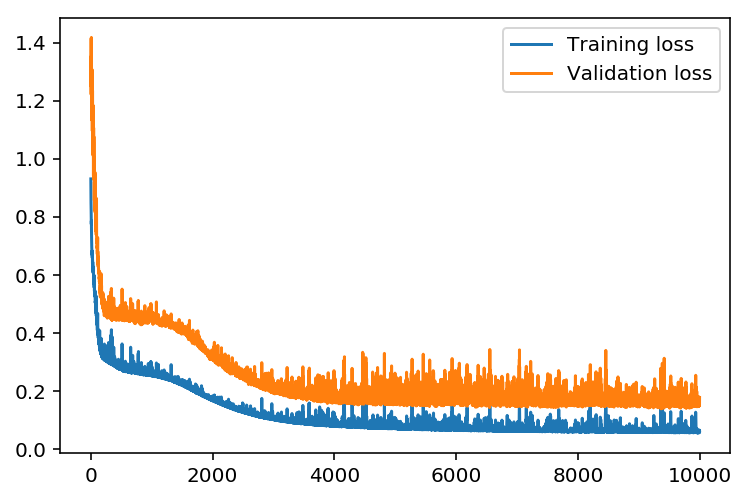

In [95]:
plt.plot(losses['train'], label='Training loss')
plt.plot(losses['validation'], label='Validation loss')
plt.legend()
_ = plt.ylim()

## 检查预测结果

使用测试数据看看网络对数据建模的效果如何。如果完全错了，请确保网络中的每步都正确实现。

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  # Remove the CWD from sys.path while we load stuff.


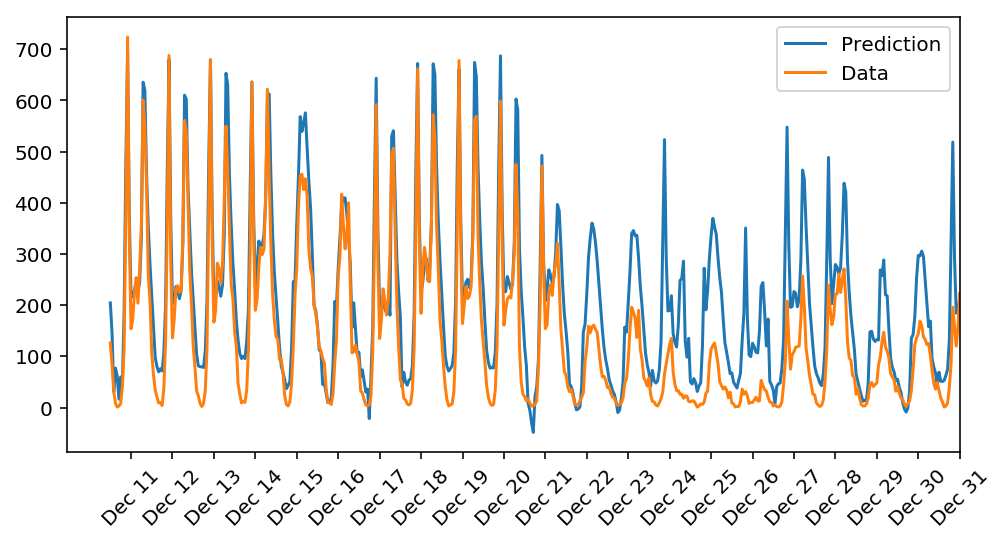

In [96]:
fig, ax = plt.subplots(figsize=(8,4))

mean, std = scaled_features['cnt']
predictions = network.run(test_features).T*std + mean
ax.plot(predictions[0], label='Prediction')
ax.plot((test_targets['cnt']*std + mean).values, label='Data')
ax.set_xlim(right=len(predictions))
ax.legend()

dates = pd.to_datetime(rides.ix[test_data.index]['dteday'])
dates = dates.apply(lambda d: d.strftime('%b %d'))
ax.set_xticks(np.arange(len(dates))[12::24])
_ = ax.set_xticklabels(dates[12::24], rotation=45)

## 可选：思考下你的结果（我们不会评估这道题的答案）

 
请针对你的结果回答以下问题。模型对数据的预测效果如何？哪里出现问题了？为何出现问题呢？

> **注意**：你可以通过双击该单元编辑文本。如果想要预览文本，请按 Control + Enter

#### 请将你的答案填写在下方
#### 设置学习率0.5，隐藏层节点10
- 第一次设置迭代次数为5000，随着迭代次数增加，训练误差与验证误差在不断变小
- 第二次迭代次数为10000次，发现大概在6000次时，训练误差在0.06上下，验证误差在0.16上下，之后误差波动很大，预测结果不是很理想，希望把训练误差控制在0.01以内，验证误差控制在0.1以内

